# Initialisation

In [107]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import statistics
import itertools 
import random
#from sklearn.linear_model import LinearRegression
#from matplotlib.backends.backend_pdf import PdfPages
mm = 25.4


In [58]:
def run(INPUT):
    global step
    step = 0
    y0 = np.concatenate((r0,W0,exc0,alpha0,tag0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,dt)[np.newaxis]);
    return y

In [59]:
def plot_all():
    r = y[index[0][:],:]
    
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(180*mm,200*mm), facecolor='w',frameon=False)
    
    ax1 = fig.add_axes([.05,.7,.9,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.05,.5,.9,.2])
    ax3 = fig.add_axes([.05,.29,.9,.2])


    ax5 = fig.add_axes([.05,.02,.2,.2])
    ax6 = fig.add_axes([.28,.02,.2,.2])
    ax7 = fig.add_axes([.51,.02,.2,.2])
    ax8 = fig.add_axes([.74,.02,.2,.2])
    
    
    im = ax1.imshow(y[index[2][:],:],aspect = nstep/N*2/9,cmap = 'cividis')
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    #cbar1 = plt.colorbar(im,cax = plt.axes([0, 0.71, 0.01, 0.18]))
    #cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=.05,x=4)
    
    im = ax2.imshow(r,aspect = nstep/N*2/9,cmap = 'cividis')
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    #cbar2 = plt.colorbar(im,cax = plt.axes([0, 0.51, 0.01, 0.18]))
    #cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.05,x=4)

        
    for n in range(N):
        ax3.plot(r[n,:],'k',linewidth = 1)
    for n in np.where(TAG!=0):
        ax3.plot(r[n,:],color = color[5],linewidth = 1)
        
    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')
    
    ax3.set_xlim([0,nstep])
    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    #cbar3 = plt.colorbar(im,cax = plt.axes([0, 0.1, 0.01, 0.18]))
    #cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=.05,x=4)
    #plt.savefig('all.pdf')

    #plt.show()

In [60]:
color = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]
color = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

In [61]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [62]:
def get_weights_TAG_avg(y,TAG):
    weights = np.reshape(y[index[1][:],:],(N,N,nstep))
    TAG_list = list(itertools.product(np.where(TAG != 0)[0], np.where(TAG != 0)[0]))
    weights_TAG_avg = np.zeros(nstep)
    for i,j in TAG_list:
        #print(i,j,weights[i,j,3000])
        weights_TAG_avg += weights[i,j,:]
    weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
    return weights_TAG_avg

In [63]:
def get_weights_TAG_avg_bis(y,TAG):
    weights = np.reshape(y[index[1][:],:],(N,N,nstep))
    TAG_list = list(itertools.product(np.where(TAG != 0)[0], np.where(TAG != 0)[0]))
    weights_TAG_avg_cross = np.zeros(nstep)
    weights_TAG_avg_auto = np.zeros(nstep)
    
    for i,j in TAG_list:
        #print(i,j,weights[i,j,3000])
        if i != j:
            weights_TAG_avg_cross += weights[i,j,:]
        else:
            weights_TAG_avg_auto += weights[i,j,:]
            
    weights_TAG_avg_cross =  weights_TAG_avg_cross / (len(TAG_list) - len(TAG))
    weights_TAG_avg_auto =  weights_TAG_avg_auto / len(TAG)
    return weights_TAG_avg_cross, weights_TAG_avg_auto

# 2 memories w/ better priming curve

## Main function

In [64]:
def run(INPUT):
    global step
    global TAG
    global TAG_r
    TAG = np.zeros(N)[np.newaxis].T
    TAG_r = np.zeros(N)[np.newaxis].T
    step = 0
    y0 = np.concatenate((r0,W0,exc0,alpha0,tag0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,dt)[np.newaxis]);
    return y

In [65]:
# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)

    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 

    #exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE * alpha

    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur

    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))

    #dalphadt = np.zeros(N)[np.newaxis].T
    #dalphadt += (t>6000)*(TAG!=0) * (1 - alpha) * (t > TAG + delay_alpha) * (t < TAG + delay_alpha + delay_alpha_2) / tau_alpha_up 
    #dalphadt += (TAG!=0) * (0 - alpha) * (t > TAG + delay_alpha + delay_alpha_2) / tau_alpha_down

    dalphadt = np.zeros(N)[np.newaxis].T
    dalphadt += (TAG!=0) * (t >= 3000) * (t <= 3100) * (TAG < 3000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 6000) * (t <= 6100) * (TAG > 3000) * (TAG < 6000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t > 3100) * (TAG < 3000) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 6100) * (TAG > 3000) * (TAG < 6000) * (1 - alpha) / tau_alpha


    # excitability
    #exc = yt[index[2]][np.newaxis].T
    dexcdt = np.zeros(N)
    dexcdt = (r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE 
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t

    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt

In [66]:
N = 50
r0 = np.zeros(N)
W0 = np.zeros(N*N)
tag0  = np.zeros(N)
index = [range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N),range(N + N*N +N+N,N + N*N +N+N+N)]

## Parameters

In [67]:
## ok
threshold = 2
threshold_alpha = 2

decayL = [4000]
tauwL = [1500]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.5]
EL = [0]
y0L = [2]
sigmaL = [1]
INL = [16]
seedL = range(10)

tau_alpha = 1000

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 1
scaleE = 0#1
scaleW = 0#1
 
overlap = 5/100

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


base = 0

In [68]:
# with new input
threshold = 2
threshold_alpha = 2

decayL = [4000]
tauwL = [1500]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.5]
EL = [0]
y0L = [2]
sigmaL = [1]
INL = [16]
seedL = range(10)

tau_alpha = 1000

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 1
scaleE = 0#1
scaleW = 0#1
 
overlap = 5/100

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


base = 0

In [69]:
# with new input
threshold = 2
threshold_alpha = 2

decayL = [4000]
tauwL = [2500]
taurL = [20]
tauthetaL = [100]
I0L = [7]
I1L = [.5]
EL = [0]
y0L = [2]
sigmaL = [1]
INL = [16]
seedL = range(10)

tau_alpha = 1000

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 10
scaleE = 0#1
scaleW = 0#1
 
overlap = 5/100

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


base = 0

## Protocol 1 memory

In [2035]:
seq = []
nstep = 30000
dt = 1
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000


seqA = []
seqB = []
Nevent = 5

for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)

#for i in range(Nstim):
#    seqB.append(pause + i*stim + delay)
#    seqB.append(pause + i*stim + delay + duration)

    
for ev in range(1,Nevent+1):

        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)
        
 #       seqB.append(pause*2 + delay + 2*delay*ev)
  #      seqB.append(pause*2 + duration + delay + 2*delay*ev)
        
ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)

base = 0
def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return (IN-base) * ctx * L/2 + base


In [2036]:
seqA

[1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 8000,
 8100,
 14000,
 14100,
 20000,
 20100,
 26000,
 26100,
 32000,
 32100]

In [982]:
seqB

[]

In [983]:
#PA = np.zeros((N,nstep))
#for t in range(nstep):
#    PA[:,t] = INPUT(t,ctxA,seqA)
    
#PB = np.zeros((N,nstep))
#for t in range(nstep):
#    PB[:,t] = INPUT(t,ctxB,seqB)

In [984]:
#plt.imshow(PA,aspect = 100)
#plt.colorbar()

## Run

In [2037]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)

 # initialisation

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]

# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
theta = y[index[3][:],:]


#plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
#plt.show()

0


### figure

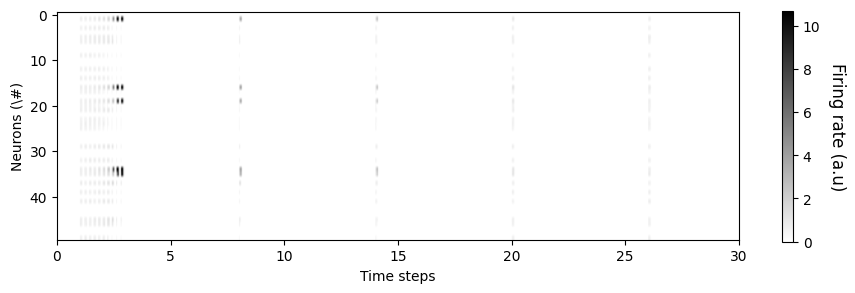

In [2038]:
r = y[index[0][:],:]

plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')

plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )
plt.savefig('fr1.pdf', dpi = 500, bbox_inches = 'tight')

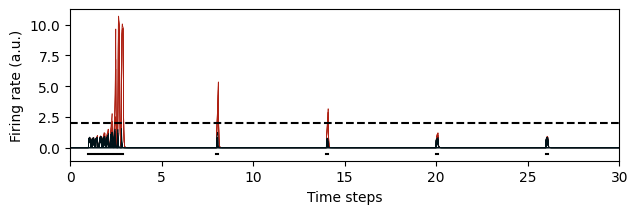

In [2039]:
plt.figure(figsize = (180/mm,50/mm))
lw = .5

for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[8],linewidth = lw)
for n in np.where(TAG==0)[0]:
    plt.plot(r[n,:],color = color[0],linewidth = lw)
    
h = -.5
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim(0,30)
plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Firing rate (a.u.)')

#plt.savefig('fr2.png',dpi=500,bbox_inches='tight')
plt.savefig('fr2.pdf', dpi = 500, bbox_inches = 'tight')

Text(4, 0.2, 'Synaptic weights (a.u)')

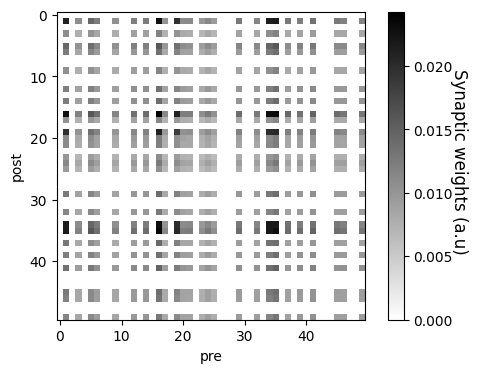

In [2040]:
W = np.reshape(y[index[1][:],:],(N,N,nstep))
plt.figure(figsize = (6,4))
plt.imshow(W[:,:,-1], cmap = 'binary')
plt.xlabel('pre')
plt.ylabel('post')
cbar = plt.colorbar()
cbar.ax.set_title('Synaptic weights (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('weightsf.png',dpi=500,bbox_inches='tight' )

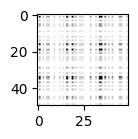

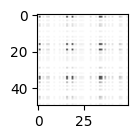

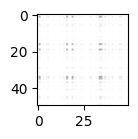

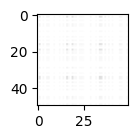

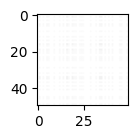

In [2041]:
W = np.reshape(y[index[1][:],:],(N,N,nstep))
for t in [2900,8100,14100,20100,26100]:
    plt.figure(figsize = (30/mm,30/mm))
    plt.imshow(W[:,:,t], cmap = 'binary', vmin = 0, vmax = 1)
    #plt.xlabel('pre')
    #plt.ylabel('post')
    #cbar = plt.colorbar()
    #cbar.ax.set_title('Synaptic weights (a.u)', rotation=270,loc='left',y=.2,x=4)
    #plt.savefig('weights'+str(t)+'.png',dpi=500,bbox_inches='tight' )    
    plt.savefig('weights'+str(t)+'.pdf',dpi=500,bbox_inches='tight' )

In [2042]:
np.where(TAG!=0)[0]

array([ 1, 16, 19, 34, 35])

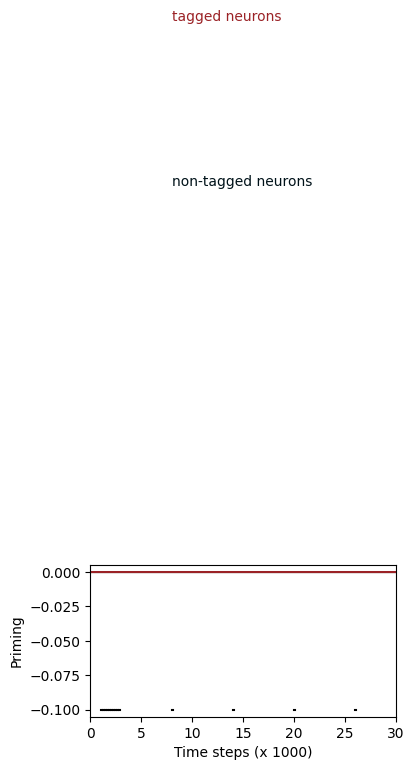

In [2043]:
plt.figure(figsize = (100/mm,50/mm))

for n in [0]:
    alpha = y[index[3][n],:]+0/100
    plt.plot(alpha, color = color[0])

for n in [6]:
    alpha = y[index[3][n],:]+0/100
    plt.plot(alpha, color = color[-1])
    
    
h = -.1
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
plt.xlim([0,30000])
plt.xticks(np.arange(0,35000,5000),np.arange(0,35,5))
plt.xlabel('Time steps (x 1000)')
plt.ylabel('Priming')

plt.text(8000,0.28,'non-tagged neurons', color = color[0])
plt.text(8000,0.4,'tagged neurons', color = color[-1])

plt.savefig('priming_course.png',dpi=500,bbox_inches='tight' )
plt.savefig('priming_course.pdf',dpi=500,bbox_inches='tight' )

### figure

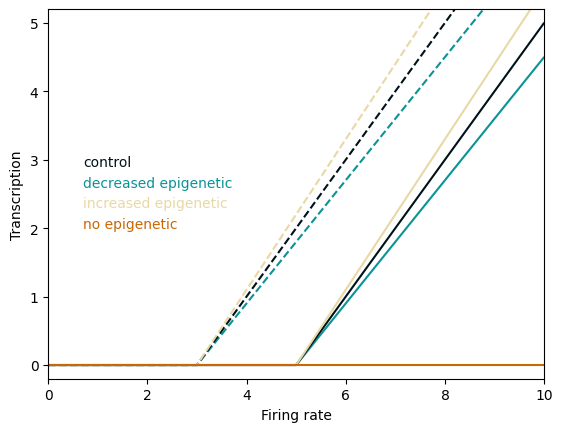

In [2044]:
X = np.arange(0,10,.01)
c = [color[2],color[0],color[4]]
for i in range(3):
    Y = np.maximum(0,X-5)*(.9+.1*i)
    plt.plot(X,Y, color = c[i])
    
for i in range(3):
    Y = np.maximum(0,X-3)*(.9+.1*i)
    plt.plot(X,Y, color = c[i],linestyle = '--')
    
Y = 0*X
plt.plot(X,Y, color = color[6])
    
plt.text(.7,2.9,'control', color = color[0])
plt.text(.7,2.6,'decreased epigenetic', color = color[2])
plt.text(.7,2.3,'increased epigenetic', color = color[4])
plt.text(.7,2,'no epigenetic', color = color[6])

plt.ylim(-.2,5.2)
plt.xlim(0,10)
plt.xlabel('Firing rate')
plt.ylabel('Transcription')
plt.savefig('explain_priming.pdf',dpi=500,bbox_inches='tight' )

## Loop on seeds

In [ ]:
Nseed = 10
Ns = 2

weights_A = np.zeros((Nseed,Ns,nstep))
rates_A = np.zeros((Nseed,Ns,nstep))
priming_A = np.zeros((Nseed,Ns,nstep))

weights_B = np.zeros((Nseed,Ns,nstep))
rates_B = np.zeros((Nseed,Ns,nstep))
priming_B = np.zeros((Nseed,Ns,nstep))

rates = np.zeros((Nseed,Ns,N,nstep))

encod_A = np.zeros((Nseed,Ns,N))
encod_B = np.zeros((Nseed,Ns,N))
recall_A = np.zeros((Nseed,Ns,N))
recall_B = np.zeros((Nseed,Ns,N))


for seed in range(Nseed):
#for seed in [4]:
    np.random.seed(seed)
    random.seed(seed)
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    
    for scaleE, scaleW in [[0,0],[.9,.9]]:
    
        print('seed = '+str(seed)+', scale = '+ str([scaleE, scaleW]))


        #for scaleE in [0,1]:
        #    for scaleW in [0]:
        #        for threshold_alpha in [0,2]:



            #for I0b in [9.5,10,10.5]:
            #for scaleW in [0,2,5]:
                # run
        y = run(INPUT)
        #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
        TAG_A = TAG * (TAG < 3000)
        TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

        weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
        rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
        priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

        weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
        rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
        priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

        #rates[seed,scenario,:,:] = y[index[0]]

        encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
        encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
        recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
        recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

        #n = 3
        #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
        #rates[seed,scenario,:] = y[index[0][n],:]
        #priming[seed,scenario,:] = y[index[3][n],:]

        overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
        overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
        #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
        #print(overlap_encod)
        #print(overlap_recall)
        #plt.show()

        #n = np.where(TAG != 0)[0][0]

        if seed == 9990:

            for n in range(N):
                rate = y[index[0][n],:]
                plt.plot(rate)
            plt.show()


            for n in range(N):
                alpha = y[index[3][n],:]
                plt.plot(alpha)
            plt.show()

            plt.plot(weights_A[seed,scenario,:])
            plt.show()

            plt.plot(weights_B[seed,scenario,:])
            plt.show()

            plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
            plt.show()

            plot_all()
            plt.show()
        scenario +=1 


seed = 0, scale = [0, 0]
seed = 0, scale = [0.9, 0.9]
seed = 1, scale = [0, 0]
seed = 1, scale = [0.9, 0.9]
seed = 2, scale = [0, 0]


### figure

In [ ]:
plt.figure(figsize = (100/mm,50/mm))

plt.plot(np.mean(weights_A[:,0,:],axis = 0), color = color[0],linestyle = '--')
plt.plot(np.mean(weights_A[:,1,:],axis = 0), color = color[0])
for seed in range(Nseed):
    plt.plot(weights_A[seed,0,:], color = color[0], alpha = 1/20)
    plt.plot(weights_A[seed,1,:], color = color[0], alpha = 1/20)
plt.xlabel('Time steps')
plt.ylabel('Averaged synaptic weights of tagged neurons')
#plt.text(5000,.06,'no epigenetic', color = color[0])
#plt.text(5000,0,'epigenetic', color = color[0])

plt.xlim([0,30000])
plt.ylim([-.05,1.05])

plt.xticks(np.arange(0,35000,10000),np.arange(0,35,10))

plt.savefig('weights_course.png',dpi=500,bbox_inches='tight' )
plt.savefig('weights_course.pdf',dpi=500,bbox_inches='tight' )


## Protocol 2 memories

In [70]:
# protocol
seq = []
nstep = 30000
dt = 1
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000
Nevent = 5



seqA = []
seqB = []
for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)
for i in range(Nstim):
    seqB.append(pause + i*stim + delay)
    seqB.append(pause + i*stim + delay + duration)
for ev in range(1,Nevent+1):
        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)
        seqB.append(pause*2 + delay + 2*delay*ev)
        seqB.append(pause*2 + duration + delay + 2*delay*ev)



def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return (IN-base) * ctx * L/2 + base

def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 +  IN * (1-ctx) * L/2 / 10


In [18]:
PA = np.zeros((N,nstep))
for t in range(nstep):
    PA[:,t] = INPUT(t,ctxA,seqA)
    
#PB = np.zeros((N,nstep))
#for t in range(nstep):
#    PB[:,t] = INPUT(t,ctxB,seqB)

NameError: name 'ctxA' is not defined

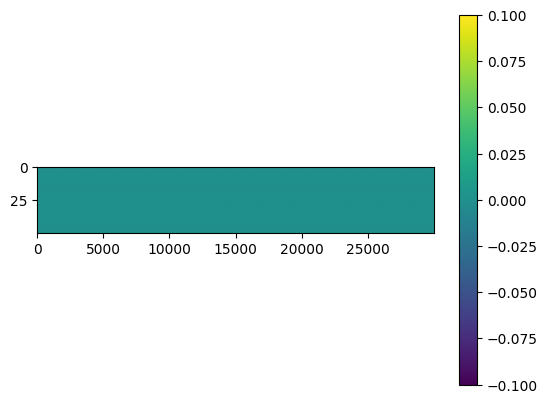

In [19]:
plt.imshow(PA,aspect = 100)
plt.colorbar()

In [20]:
#plt.imshow(PB,aspect = 100)

## Run

In [71]:
threshold_alpha = 0

In [72]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)

# initialisation
r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]

# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
theta = y[index[3][:],:]


#plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
#plt.show()

0


### figure

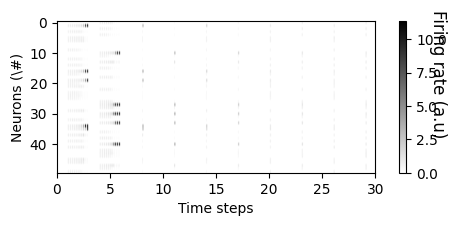

In [79]:
r = y[index[0][:],:]
plt.figure(figsize = (155/mm,50/mm))

plt.imshow(r,aspect = nstep/N*50/105, cmap = 'binary')

plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )
plt.savefig('fr1_2m.pdf', dpi = 500, bbox_inches = 'tight')

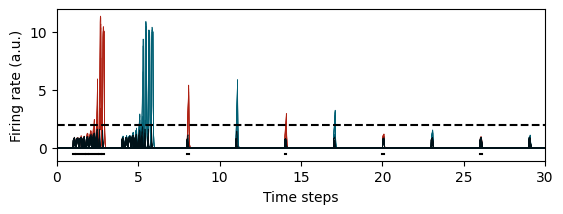

In [24]:
plt.figure(figsize = (160/mm,50/mm))
lw = .5

for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[8],linewidth = lw)
for n in np.where(np.logical_and(TAG>3000,TAG<6000))[0]:
    plt.plot(r[n,:],color = color[1],linewidth = lw)
for n in np.where(TAG==0)[0]:
    plt.plot(r[n,:],color = color[0],linewidth = lw)
    
h = -.5
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim(0,30)
plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Firing rate (a.u.)')

#plt.savefig('fr2.png',dpi=500,bbox_inches='tight')
plt.savefig('fr2_2m.pdf', dpi = 500, bbox_inches = 'tight')

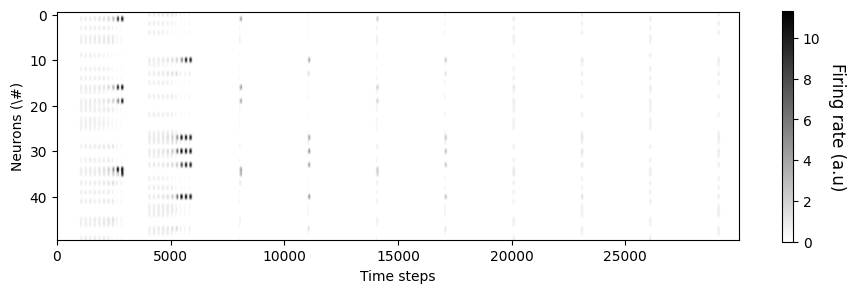

In [25]:
plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
plt.savefig('fr1_2m.png',dpi=500,bbox_inches='tight' )

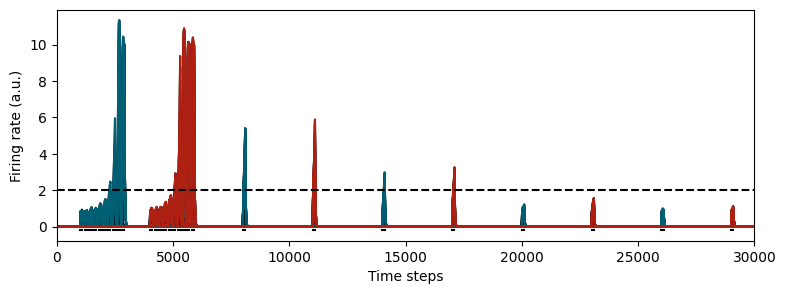

In [26]:
plt.figure(figsize = (9,3))
for n in range(N):
    plt.plot(r[n,:],color = color[0])   
for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[1])
for n in np.where(np.logical_and(TAG>3000,TAG<6000))[0]:
    plt.plot(r[n,:],color = color[8])
    
h = -.2
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
for s in range(int(len(seqB)/2)):
    plt.plot([seqB[2*s],seqB[2*s+1]],[h,h],'k')
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim([0,30000])
plt.xlabel('Time steps')
plt.ylabel('Firing rate (a.u.)')


plt.savefig('fr2_2m.png',dpi=500,bbox_inches='tight' )

## Loop on seeds

In [27]:
Nseed = 10
Ns = 2

weights_A = np.zeros((Nseed,Ns,nstep))
rates_A = np.zeros((Nseed,Ns,nstep))
priming_A = np.zeros((Nseed,Ns,nstep))

weights_B = np.zeros((Nseed,Ns,nstep))
rates_B = np.zeros((Nseed,Ns,nstep))
priming_B = np.zeros((Nseed,Ns,nstep))

rates = np.zeros((Nseed,Ns,N,nstep))

encod_A = np.zeros((Nseed,Ns,N))
encod_B = np.zeros((Nseed,Ns,N))
recall_A = np.zeros((Nseed,Ns,N))
recall_B = np.zeros((Nseed,Ns,N))


for seed in range(Nseed):
#for seed in [4]:
    np.random.seed(seed)
    random.seed(seed)
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    
    for scaleE, scaleW in [[0,0],[.9,.9]]:
    
        print('seed = '+str(seed)+', scale = '+ str([scaleE, scaleW]))


        #for scaleE in [0,1]:
        #    for scaleW in [0]:
        #        for threshold_alpha in [0,2]:



            #for I0b in [9.5,10,10.5]:
            #for scaleW in [0,2,5]:
                # run
        y = run(INPUT)
        #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
        TAG_A = TAG * (TAG < 3000)
        TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

        weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
        rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
        priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

        weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
        rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
        priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

        #rates[seed,scenario,:,:] = y[index[0]]

        encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
        encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
        recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
        recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

        #n = 3
        #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
        #rates[seed,scenario,:] = y[index[0][n],:]
        #priming[seed,scenario,:] = y[index[3][n],:]

        overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
        overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
        #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
        #print(overlap_encod)
        #print(overlap_recall)
        #plt.show()

        #n = np.where(TAG != 0)[0][0]

        if seed == 9990:

            for n in range(N):
                rate = y[index[0][n],:]
                plt.plot(rate)
            plt.show()


            for n in range(N):
                alpha = y[index[3][n],:]
                plt.plot(alpha)
            plt.show()

            plt.plot(weights_A[seed,scenario,:])
            plt.show()

            plt.plot(weights_B[seed,scenario,:])
            plt.show()

            plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
            plt.show()

            plot_all()
            plt.show()
        scenario +=1 


seed = 0, scale = [0, 0]
seed = 0, scale = [0.9, 0.9]
seed = 1, scale = [0, 0]
seed = 1, scale = [0.9, 0.9]
seed = 2, scale = [0, 0]
seed = 2, scale = [0.9, 0.9]
seed = 3, scale = [0, 0]
seed = 3, scale = [0.9, 0.9]
seed = 4, scale = [0, 0]
seed = 4, scale = [0.9, 0.9]
seed = 5, scale = [0, 0]
seed = 5, scale = [0.9, 0.9]
seed = 6, scale = [0, 0]
seed = 6, scale = [0.9, 0.9]
seed = 7, scale = [0, 0]
seed = 7, scale = [0.9, 0.9]
seed = 8, scale = [0, 0]
seed = 8, scale = [0.9, 0.9]
seed = 9, scale = [0, 0]
seed = 9, scale = [0.9, 0.9]


### figure

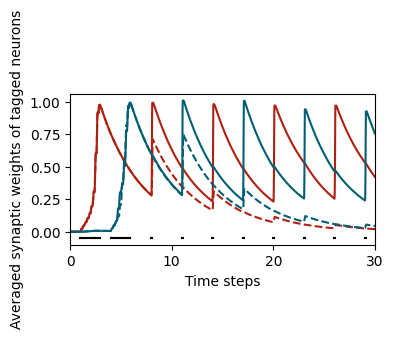

In [56]:
plt.figure(figsize = (100/mm,50/mm))

plt.plot(np.mean(weights_A[:,0,:],axis = 0), color = color[8],linestyle = '--')
plt.plot(np.mean(weights_A[:,1,:],axis = 0), color = color[8])
plt.plot(np.mean(weights_B[:,0,:],axis = 0), color = color[1],linestyle = '--')
plt.plot(np.mean(weights_B[:,1,:],axis = 0), color = color[1])
#for seed in range(Nseed):
#    plt.plot(weights_A[seed,0,:], color = color[0], alpha = 1/20)
#    plt.plot(weights_A[seed,1,:], color = color[0], alpha = 1/20)
#    plt.plot(weights_B[seed,0,:], color = color[0], alpha = 1/20)
#    plt.plot(weights_B[seed,1,:], color = color[0], alpha = 1/20)
plt.xlabel('Time steps')
plt.ylabel('Averaged synaptic weights of tagged neurons')
#plt.text(5000,.06,'no epigenetic', color = color[0])
#plt.text(5000,0,'epigenetic', color = color[0])

plt.xlim([0,30000])
#plt.ylim([-.05,1.05])

plt.xticks(np.arange(0,35000,10000),np.arange(0,35,10))
h = -.05
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
for s in range(int(len(seqB)/2)):
    plt.plot([seqB[2*s],seqB[2*s+1]],[h,h],'k')
plt.savefig('weights_course.png',dpi=500,bbox_inches='tight' )
plt.savefig('weights_course.pdf',dpi=500,bbox_inches='tight' )


## Loop

In [1901]:
scaleEL = np.arange(.5,1.5,.1)
scaleWL = np.arange(0,.4,.05)
threshold_alphaL = [0,2]
Nseed = 100
down = [3,1]
control = [4,2]
up =[5,3]
print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[0.8999999999999999, 0.1]
[0.7999999999999999, 0.05]
[0.9999999999999999, 0.15000000000000002]


In [1902]:
scaleE,scaleW = scaleEL[control[0]], scaleWL[control[1]]
print([scaleE,scaleW ])

[0.8999999999999999, 0.1]


In [815]:
threshold

2

In [816]:
threshold_alpha_set

2

In [817]:
threshold_alpha_set = 2
threshold_alpha_set

2

In [818]:
scaleE,scaleW = 1.5,.6

In [819]:
scaleE,scaleW = .9,.6

In [820]:
scaleE,scaleW = .5,.1

In [821]:
scaleE,scaleW = .9, .9

seed = 0, threshold_alpha = 0
0.9 0.9
[25.0, 1.0, 25.0, 1.0]
[4.0, 2.0, 4.0, 2.0]


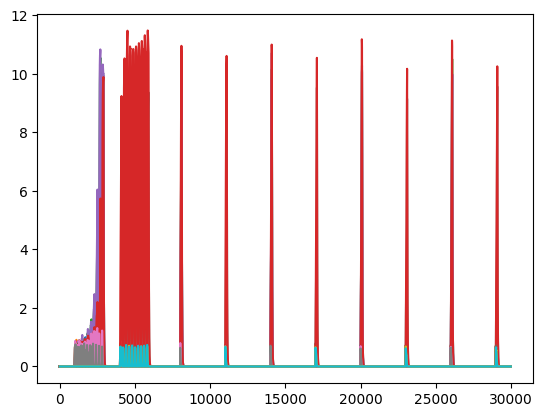

seed = 0, threshold_alpha = 2
0.9 0.9
[25.0, 1.0, 25.0, 1.0]
[4.0, 3.0, 4.0, 2.0]


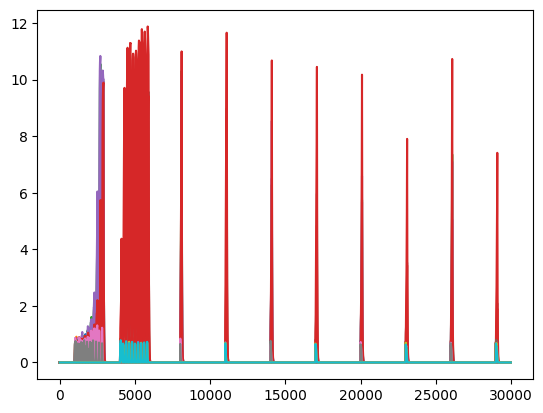

seed = 1, threshold_alpha = 0
0.9 0.9
[0.0, 0.0, 14.285714285714285, 1.0]
[8.0, 4.0, 7.0, 4.0]


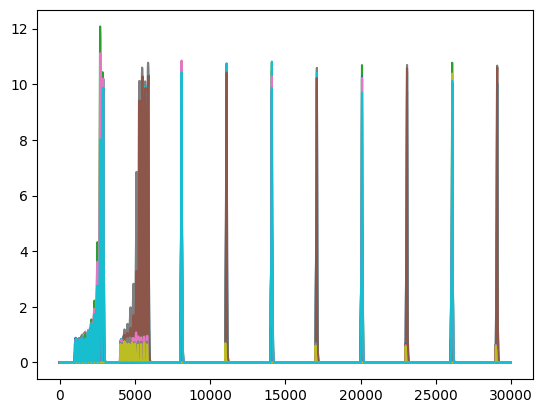

seed = 1, threshold_alpha = 2
0.9 0.9


KeyboardInterrupt: 

In [822]:
Nseed = 10
Ns = 2

weights_A = np.zeros((Nseed,Ns,nstep))
rates_A = np.zeros((Nseed,Ns,nstep))
priming_A = np.zeros((Nseed,Ns,nstep))

weights_B = np.zeros((Nseed,Ns,nstep))
rates_B = np.zeros((Nseed,Ns,nstep))
priming_B = np.zeros((Nseed,Ns,nstep))

rates = np.zeros((Nseed,Ns,N,nstep))

encod_A = np.zeros((Nseed,Ns,N))
encod_B = np.zeros((Nseed,Ns,N))
recall_A = np.zeros((Nseed,Ns,N))
recall_B = np.zeros((Nseed,Ns,N))


overlap_encod = np.zeros((Nseed,Ns))
overlap_recall = np.zeros((Nseed,Ns))
overlap_encod_1 = np.zeros((Nseed,Ns))
overlap_recall_1 = np.zeros((Nseed,Ns))
overlap_encod_2 = np.zeros((Nseed,Ns))
overlap_recall_2 = np.zeros((Nseed,Ns))

for seed in range(Nseed):
#for seed in [4]:
    np.random.seed(seed+2*Nseed)
    random.seed(seed+2*Nseed)
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)

    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    
    for threshold_alpha in [0,threshold_alpha_set]:
    
        print('seed = '+str(seed)+', threshold_alpha = '+ str(threshold_alpha))

        # run
        print(scaleE,scaleW)
        y = run(INPUT)



        #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
        TAG_A = TAG * (TAG < 3000)
        TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

        weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
        rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
        priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

        weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
        rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
        priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

        #rates[seed,scenario,:,:] = y[index[0]]

        encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
        encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
        recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
        recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

        #n = 3
        #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
        #rates[seed,scenario,:] = y[index[0][n],:]
        #priming[seed,scenario,:] = y[index[3][n],:]

        overlap_encod[seed,scenario] =  100 * np.divide(np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:])), np.sum(encod_A[seed,scenario,:]) )
        overlap_recall[seed,scenario] = 100 * np.divide(np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:])), np.sum(recall_A[seed,scenario,:]))
        overlap_encod_1[seed,scenario] =  100 * np.divide(np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:])), np.sum(encod_B[seed,scenario,:]) )
        overlap_recall_1[seed,scenario] = 100 * np.divide(np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:])), np.sum(recall_B[seed,scenario,:]))
        overlap_encod_2[seed,scenario] = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
        overlap_recall_2[seed,scenario] = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
      
        #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
        print([overlap_encod[seed,scenario], overlap_encod_2[seed,scenario], overlap_recall[seed,scenario],overlap_recall_2[seed,scenario]])
        print([np.sum(encod_A[seed,scenario,:]),np.sum(encod_B[seed,scenario,:]),np.sum(recall_A[seed,scenario,:]),np.sum(recall_B[seed,scenario,:])])
        #print(overlap_recall)
        #plt.show()

        #n = np.where(TAG != 0)[0][0]
        
        for n in range(N):
                rate = y[index[0][n],:]
                plt.plot(rate)
        plt.show()
            
        if seed == 9990:

            


            for n in range(N):
                alpha = y[index[3][n],:]
                plt.plot(alpha)
            plt.show()

            plt.plot(weights_A[seed,scenario,:])
            plt.show()

            plt.plot(weights_B[seed,scenario,:])
            plt.show()

            plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
            plt.show()

            #plot_all()
            #plt.show()
        scenario +=1

In [1918]:
overlap_recall_2

In [1919]:
overlap_recall

In [1920]:
overlap_recall_1

In [ ]:
r = y[index[0][:],:]
plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )

## Plot upregulate/downregulate

### weights

In [98]:
results = np.load('results_weights_9_f.npy')
np.shape(results)

(16, 16, 2, 100, 6, 5)

In [99]:
## _9
scaleEL = np.arange(0,1.6,.1)
scaleWL = np.arange(0,1.6,.1)
threshold_alphaL = [0,2]
Nseed = 100
down = [9,6]
control = [10,7]
up =[13,10]


print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[1.0, 0.7000000000000001]
[0.9, 0.6000000000000001]
[1.3, 1.0]


In [100]:
## _9, test high epig.
scaleEL = np.arange(0,1.6,.1)
scaleWL = np.arange(0,1.6,.1)
threshold_alphaL = [0,2]
Nseed = 100
down = [8,8]
control = [9,9]
up =[10,10]


print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[0.9, 0.9]
[0.8, 0.8]
[1.0, 1.0]


In [101]:
weights_A = results[:,:,:,:,0,:]
rates_A   = results[:,:,:,:,1,:]
priming_A = results[:,:,:,:,2,:]
weights_B = results[:,:,:,:,3,:]
rates_B   = results[:,:,:,:,4,:]
priming_B = results[:,:,:,:,5,:]

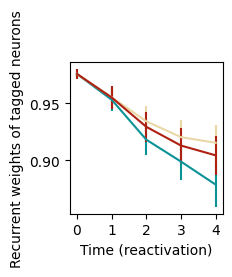

In [105]:
plt.figure(figsize = (50/mm,50/mm))

w = 0
th = -1
c = 0
cc = [2,4,8]
for [e,w] in [down,up,control]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(weights_A[e,w,th,:,:],axis = 0), stats.sem(weights_A[e,w,th,:,:],axis = 0),marker = '', color = color[cc[c]])
    c+=1
    
#plt.legend(scaleEL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Recurrent weights of tagged neurons')

#plt.legend(['decreased epigenetic', 'control', 'increased epigenetic'])

plt.xticks([0,1,2,3,4])
#plt.text(1,0.48,'control', color = color[0])
#plt.text(1,0.44,'decreased epigenetic', color = color[2])
#plt.text(1,0.4,'increased epigenetic', color = color[4])
#plt.ylim(.72,1)
plt.savefig('weights_high_epi.pdf',dpi=500,bbox_inches='tight' )




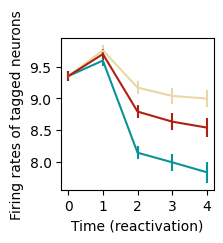

In [106]:
plt.figure(figsize = (50/mm,50/mm))

w = 0
th = -1
c = 0
cc = [2,4,8]
for [e,w] in [down,up,control]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(rates_A[e,w,th,:,:],axis = 0), stats.sem(rates_A[e,w,th,:,:],axis = 0),marker = '', color = color[cc[c]])
    c+=1
    
#plt.legend(scaleEL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Firing rates of tagged neurons')

#plt.legend(['decreased epigenetic', 'control', 'increased epigenetic'])

plt.xticks([0,1,2,3,4])
#plt.text(0,4.5,'control', color = color[0])
#plt.text(0,4.1,'decreased epigenetic', color = color[2])
#plt.text(0,3.7,'increased epigenetic', color = color[4])

plt.savefig('rates.pdf_high_epi.pdf',dpi=500,bbox_inches='tight' )


Text(0, 0.5, 'weights_A of tagged neurons')

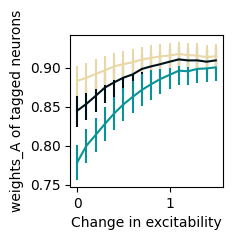

In [736]:
plt.figure(figsize = (50/mm,50/mm))

e,w = control
ts = -1
c = 0
for [e,w] in [control,down,up]:
    plt.errorbar(scaleEL, np.mean(weights_A[:,w,th,:,ts],axis = 1), stats.sem(weights_A[:,w,th,:,ts],axis = 1),marker = '', color = color[2*c])
    c+=1

plt.xlabel('Change in excitability')
plt.ylabel('weights_A of tagged neurons')

#plt.savefig('rates.pdf',dpi=500,bbox_inches='tight' )


Text(0, 0.5, 'weights of tagged neurons')

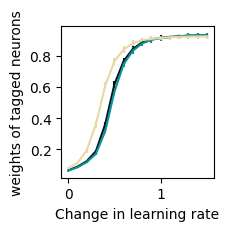

In [561]:
plt.figure(figsize = (50/mm,50/mm))

e,w = control
ts = -1
c = 0
for [e,w] in [control,down,up]:
    plt.errorbar(scaleWL, np.mean(weights_A[e,:,th,:,ts],axis = 1), stats.sem(weights_A[e,:,th,:,ts],axis = 1),marker = '', color = color[2*c])
    c+=1
plt.xlabel('Change in learning rate')
plt.ylabel('weights of tagged neurons')

#plt.savefig('rates.pdf',dpi=500,bbox_inches='tight' )


Text(0, 0.5, 'rates of tagged neurons')

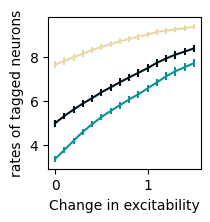

In [535]:
plt.figure(figsize = (50/mm,50/mm))

e,w = control
ts = -1
c = 0
for [e,w] in [control,down,up]:
    plt.errorbar(scaleEL, np.mean(rates_A[:,w,th,:,ts],axis = 1), stats.sem(rates_A[:,w,th,:,ts],axis = 1),marker = '', color = color[2*c])
    c+=1

plt.xlabel('Change in excitability')
plt.ylabel('rates of tagged neurons')

#plt.savefig('rates.pdf',dpi=500,bbox_inches='tight' )


Text(0, 0.5, 'rates of tagged neurons')

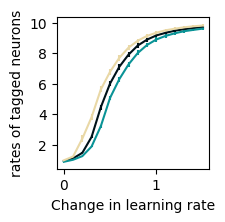

In [141]:
plt.figure(figsize = (50/mm,50/mm))

e,w = control
ts = -1
c = 0
for [e,w] in [control,down,up]:
    plt.errorbar(scaleWL, np.mean(rates_A[e,:,th,:,ts],axis = 1), stats.sem(rates_A[e,:,th,:,ts],axis = 1),marker = '', color = color[2*c])
    c+=1
plt.xlabel('Change in learning rate')
plt.ylabel('rates of tagged neurons')

#plt.savefig('rates.pdf',dpi=500,bbox_inches='tight' )


### test

In [1172]:
results = np.load('results_overlap_8.npy')
np.shape(results)

(1, 1, 2, 100, 8)

In [1173]:
p = 1

size_encod_A = results[:,:,p,:,0]
size_encod_B = results[:,:,p,:,1]
size_recall_A = results[:,:,p,:,2]
size_recall_B = results[:,:,p,:,3]

size_encod_A_th0 = results[:,:,0,:,0]
size_encod_B_th0 = results[:,:,0,:,1]
size_recall_A_th0 = results[:,:,0,:,2]
size_recall_B_th0 = results[:,:,0,:,3]

overlap_encod = results[:,:,p,:,4]
overlap_recall = results[:,:,p,:,5]
overlap_encod_th0 = results[:,:,0,:,4]
overlap_recall_th0 = results[:,:,0,:,5]

In [1174]:
control = [0,0]
up = control
down = control

In [1175]:
size_recall_A[e,w,:]

array([ 6.,  6.,  5.,  2.,  5.,  6.,  4.,  4.,  6.,  5.,  5.,  4.,  5.,
        5.,  5.,  4.,  5.,  6.,  9.,  4.,  5.,  5.,  5.,  5.,  6.,  5.,
        5.,  5.,  6.,  9.,  5.,  5.,  6.,  5.,  2.,  8.,  4.,  9.,  6.,
        9.,  9.,  5.,  5.,  2.,  4.,  4.,  9.,  9.,  6.,  5.,  4.,  5.,
       10.,  9.,  5.,  5.,  9.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,
        6.,  9.,  9.,  9.,  3.,  5.,  4.,  6.,  2.,  5.,  6.,  5.,  5.,
        2.,  4.,  4.,  2.,  6.,  5.,  9.,  4.,  4.,  9.,  5.,  5.,  9.,
        4.,  4.,  6.,  4.,  3.,  5.,  5.,  9.,  5.])

In [1176]:
overlap_recall_th0[e,w,:] - overlap_recall[e,w,:]

array([ 100.        ,  100.        ,   -5.71428571,  -66.66666667,
        100.        ,  100.        ,    0.        ,    0.        ,
          0.        ,    0.        ,  100.        ,    0.        ,
          0.        ,    0.        ,  100.        ,  -10.71428571,
          0.        ,  100.        ,    0.        ,  -12.5       ,
         -5.71428571,  100.        ,  100.        ,    0.        ,
        100.        ,   14.28571429,   80.        ,    0.        ,
          0.        ,    0.        ,    0.        ,   -5.71428571,
        100.        ,    0.        ,  -66.66666667,    0.        ,
         75.        ,    0.        ,  100.        ,    0.        ,
          0.        ,    0.        ,  100.        ,  -60.        ,
        -10.71428571,    0.        ,    0.        ,    0.        ,
          0.        ,  100.        ,  -10.71428571,  100.        ,
          0.        ,    0.        ,  100.        ,  100.        ,
          0.        ,  100.        ,    0.        ,   -5.71428

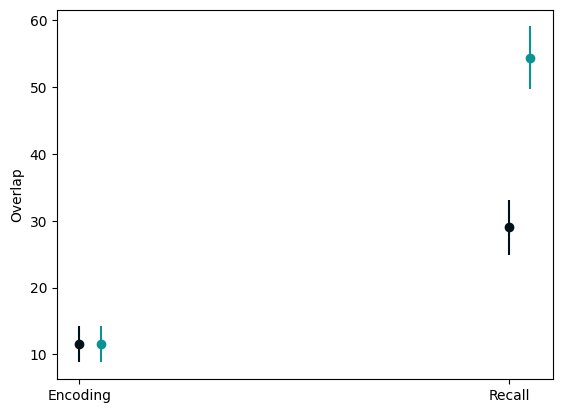

In [1177]:
[e,w] = control
c = 0
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod[e,w,:]),
                        np.mean(overlap_recall[e,w,:])],
                       [stats.sem(overlap_encod[e,w,:]),
                        stats.sem(overlap_recall[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod_th0[e,w,:]),
                        np.mean(overlap_recall_th0[e,w,:])],
                       [stats.sem(overlap_encod_th0[e,w,:]),
                        stats.sem(overlap_recall_th0[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.savefig('overlap_threshold.png',dpi = 500,bbox_inches='tight')
plt.savefig('overlap_threshold.pdf',dpi = 500,bbox_inches='tight')

### overlap

In [777]:
results = np.load('results_overlap_9_noB_f.npy')
np.shape(results)

(16, 16, 2, 100, 8)

In [36]:
results = np.load('results_overlap_9_f.npy')
np.shape(results)

(16, 16, 2, 100, 12)

In [37]:
p = 1

size_encod_A = results[:,:,p,:,0] / 50 * 100
size_encod_B = results[:,:,p,:,1] / 50 * 100
size_recall_A = results[:,:,p,:,2] / 50 * 100
size_recall_B = results[:,:,p,:,3] / 50 * 100

size_encod_A_th0 = results[:,:,0,:,0] / 50 * 100
size_encod_B_th0 = results[:,:,0,:,1] / 50 * 100
size_recall_A_th0 = results[:,:,0,:,2] / 50 * 100
size_recall_B_th0 = results[:,:,0,:,3] / 50 * 100

overlap_encod = results[:,:,p,:,4]
overlap_recall = results[:,:,p,:,5]
overlap_encod_th0 = results[:,:,0,:,4]
overlap_recall_th0 = results[:,:,0,:,5]

In [38]:
ov = 4

overlap_encod = results[:,:,p,:,ov]
overlap_recall = results[:,:,p,:,ov+1]
overlap_encod_th0 = results[:,:,0,:,ov]
overlap_recall_th0 = results[:,:,0,:,ov+1]

In [39]:
## _9
scaleEL = np.arange(0,1.6,.1)
scaleWL = np.arange(0,1.6,.1)
threshold_alphaL = [0,2]
Nseed = 100
down = [9,6]
control = [10,7]
up =[13,10]


print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[1.0, 0.7000000000000001]
[0.9, 0.6000000000000001]
[1.3, 1.0]


In [40]:
## _9, test high epig.
scaleEL = np.arange(0,1.6,.1)
scaleWL = np.arange(0,1.6,.1)
threshold_alphaL = [0,2]
Nseed = 100
down = [8,8]
control = [9,9]
up =[10,10]


print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[0.9, 0.9]
[0.8, 0.8]
[1.0, 1.0]


In [41]:
[e,w] = control

overlap_recall_cut = overlap_recall[e,w,:]
overlap_recall_cut = np.delete(overlap_recall_cut,np.where(size_recall_A[e,w,:] == 0))

overlap_encod_cut = overlap_encod[e,w,:]
overlap_encod_cut = np.delete(overlap_encod_cut,np.where(size_encod_A[e,w,:] == 0))

overlap_recall_th0_cut = overlap_recall_th0[e,w,:]
overlap_recall_th0_cut = np.delete(overlap_recall_th0_cut,np.where(size_recall_A_th0[e,w,:] == 0))

overlap_encod_th0_cut = overlap_encod_th0[e,w,:]
overlap_encod_th0_cut = np.delete(overlap_encod_th0_cut,np.where(size_encod_A_th0[e,w,:] == 0))

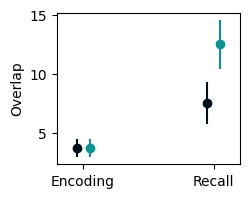

In [54]:
plt.figure(figsize = (60/mm,50/mm))
#plt.figure(figsize = (60/mm,100/mm))
c = 0
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_cut),
                        np.mean(overlap_recall_cut)],
                       [stats.sem(overlap_encod_cut),
                        stats.sem(overlap_recall_cut)], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_th0_cut),
                        np.mean(overlap_recall_th0_cut)],
                       [stats.sem(overlap_encod_th0_cut),
                        stats.sem(overlap_recall_th0_cut)], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0.05,1.05],['Encoding','Recall']);
plt.xlim(-.15,1.25)
plt.savefig('overlap_threshold_high_epi.pdf',dpi = 500,bbox_inches='tight')

In [797]:
np.shape(scaleEL)

(16,)

#### vs E and W

In [798]:
[e,w] = control

In [799]:
size_recall_A[e,w,:]

array([10., 12.,  8., 12.,  8., 12., 12.,  8., 12., 10., 12., 12., 12.,
       12., 12., 12., 10., 10., 12., 14., 12., 12., 10., 14., 10., 10.,
       12., 12., 10., 10., 10., 12., 10.,  8.,  8., 10., 10., 12., 12.,
       14., 10., 10., 10.,  6., 10., 12., 10., 14., 10., 14., 10., 12.,
       12., 12., 12., 12., 12., 10., 10., 10., 12., 10., 12., 10., 10.,
       12., 12., 10., 10., 12., 12., 10., 12., 12.,  8., 12., 10., 10.,
        4., 12., 10.,  4., 12., 12., 10., 10., 10., 10., 12., 12., 12.,
       10., 12., 14., 12., 10., 10., 10., 12., 14.])

In [800]:
overlap_recall_th0[e,w,:] - overlap_recall[e,w,:]

array([  0.        ,   0.        ,   0.        , 100.        ,
        20.        ,  -2.38095238,   0.        ,   0.        ,
         0.        ,  16.66666667,   0.        ,  25.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        , 100.        ,   0.        ,   0.        ,
        16.66666667,  16.66666667,   0.        ,   0.        ,
         0.        ,   0.        ,  16.66666667,  14.28571429,
        16.66666667,   0.        , -16.66666667,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  28.57142857,  16.66666667, -33.33333333,
        -3.33333333,   0.        ,   0.        ,   0.        ,
        16.66666667,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  28.57142857,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [801]:
overlap_recall[e,w,:]

array([  0.        ,   0.        ,  25.        ,   0.        ,
         0.        ,  16.66666667,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  16.66666667,
         0.        ,   0.        ,   0.        ,  14.28571429,
        16.66666667,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  50.        ,   0.        ,
        20.        ,   0.        ,   0.        ,  14.28571429,
         0.        ,   0.        ,   0.        ,  66.66666667,
        20.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  20.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  20.        ,
         0.        ,   0.        ,   0.        ,   0.  

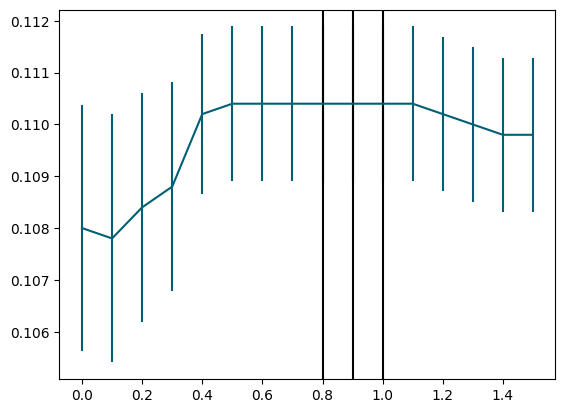

In [762]:
[e,w] = control
plt.errorbar(scaleEL,np.mean(size_recall_A[:,w,:],axis = 1), stats.sem(size_recall_A[:,w,:],axis = 1),color = color[1])
#plt.errorbar(scaleEL,np.mean(size_recall_B[:,w,:],axis = 1), stats.sem(size_recall_B[:,w,:],axis = 1),color = color[8])
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')

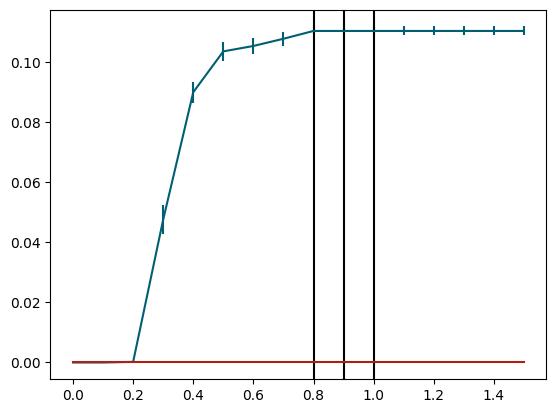

In [763]:
[e,w] = control
plt.errorbar(scaleWL,np.mean(size_recall_A[e,:,:],axis = 1), stats.sem(size_recall_A[e,:,:],axis = 1),color = color[1])
plt.errorbar(scaleWL,np.mean(size_recall_B[e,:,:],axis = 1), stats.sem(size_recall_B[e,:,:],axis = 1),color = color[8])
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

[9, 9]
[8, 8]
[10, 10]


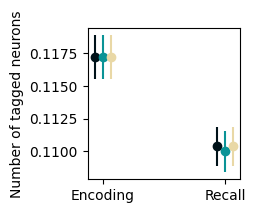

In [764]:
c = 0
plt.figure(figsize = (50/mm,50/mm))

for [e,w] in [control,down,up]:
    print([e,w])
    plt.errorbar(np.array([0,.5]) + c/30,[np.mean(size_encod_A[e,w,:]),
                              np.mean(size_recall_A[e,w,:])],
                             [stats.sem(size_encod_A[e,w,:]),
                              stats.sem(size_recall_A[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])
    c+=1
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks(np.array([0,.5]) + 1/30,['Encoding','Recall']);
plt.ylabel('Number of tagged neurons')
#plt.legend(['control','decreased epigenetic', 'increased epigenetic'])

#plt.text(.2,5.7,'control', color = color[0])
#plt.text(.2,5.55,'decreased epigenetic', color = color[2])
#plt.text(.2,5.4,'increased epigenetic', color = color[4])



plt.savefig('size_3C_high_epi.pdf',dpi = 500,bbox_inches='tight')

In [765]:
print(np.where(size_recall_A[e,w,:] == 0))
print(np.where(size_encod_A[e,w,:] == 0))
print(np.where(size_recall_A_th0[e,w,:] == 0))
print(np.where(size_encod_A_th0[e,w,:] == 0))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [766]:
[e,w] = control

overlap_recall_cut = overlap_recall[e,w,:]
overlap_recall_cut = np.delete(overlap_recall_cut,np.where(size_recall_A[e,w,:] == 0))

overlap_encod_cut = overlap_encod[e,w,:]
overlap_encod_cut = np.delete(overlap_encod_cut,np.where(size_encod_A[e,w,:] == 0))

overlap_recall_th0_cut = overlap_recall_th0[e,w,:]
overlap_recall_th0_cut = np.delete(overlap_recall_th0_cut,np.where(size_recall_A_th0[e,w,:] == 0))

overlap_encod_th0_cut = overlap_encod_th0[e,w,:]
overlap_encod_th0_cut = np.delete(overlap_encod_th0_cut,np.where(size_encod_A_th0[e,w,:] == 0))

#### figure

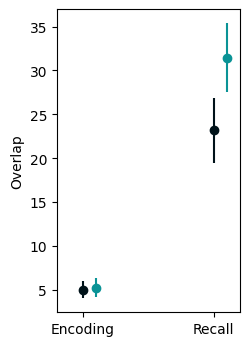

In [509]:
plt.figure(figsize = (60/mm,100/mm))
c = 0
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_cut),
                        np.mean(overlap_recall_cut)],
                       [stats.sem(overlap_encod_cut),
                        stats.sem(overlap_recall_cut)], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_th0_cut),
                        np.mean(overlap_recall_th0_cut)],
                       [stats.sem(overlap_encod_th0_cut),
                        stats.sem(overlap_recall_th0_cut)], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.xlim(-.2,1.2)
plt.savefig('overlap_threshold.png',dpi = 500,bbox_inches='tight')
plt.savefig('overlap_threshold.pdf',dpi = 500,bbox_inches='tight')

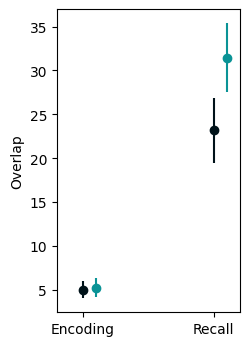

In [510]:
plt.figure(figsize = (60/mm,100/mm))
c = 0
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_cut),
                        np.mean(overlap_recall_cut)],
                       [stats.sem(overlap_encod_cut),
                        stats.sem(overlap_recall_cut)], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/10,[np.mean(overlap_encod_th0_cut),
                        np.mean(overlap_recall_th0_cut)],
                       [stats.sem(overlap_encod_th0_cut),
                        stats.sem(overlap_recall_th0_cut)], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.xlim(-.2,1.2)
plt.savefig('overlap_threshold.png',dpi = 500,bbox_inches='tight')
plt.savefig('overlap_threshold.pdf',dpi = 500,bbox_inches='tight')

Text(0.5, 1.0, 'Encoding A, exc')

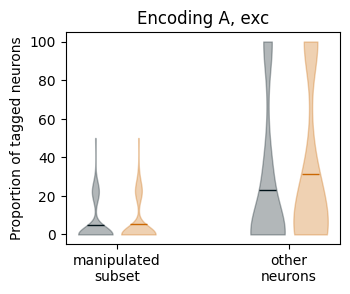

In [511]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A


cc = 6
for p in [0,1]:
    X = np.array([0,1]) + p/4
    if p == 0:
        parts = plt.violinplot([overlap_encod_cut,overlap_recall_cut],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    else:
        parts = plt.violinplot([overlap_encod_th0_cut,overlap_recall_th0_cut],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)
        
plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
#plt.ylim([0,1])

plt.title('Encoding A, exc')
#plt.savefig('primed_before_encodA_exc.pdf',dpi = 500,bbox_inches='tight')

In [512]:
np.where(size_recall_A == 0)

(array([ 0,  0,  0, ..., 20, 20, 20]),
 array([ 0,  0,  0, ...,  9,  9, 10]),
 array([ 0,  1,  2, ...,  7, 33, 33]))

In [513]:
overlap_encod_cut = overlap_encod

In [514]:
[e,w] = control
c = 0
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod_cut[e,w,:]),
                        np.mean(overlap_recall_cut[e,w,:])],
                       [stats.sem(overlap_encod_cut[e,w,:]),
                        stats.sem(overlap_recall_cut[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod_th0_cut[e,w,:]),
                        np.mean(overlap_recall_th0_cut[e,w,:])],
                       [stats.sem(overlap_encod_th0_cut[e,w,:]),
                        stats.sem(overlap_recall_th0_cut[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.savefig('overlap_threshold.png',dpi = 500,bbox_inches='tight')
plt.savefig('overlap_threshold.pdf',dpi = 500,bbox_inches='tight')

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

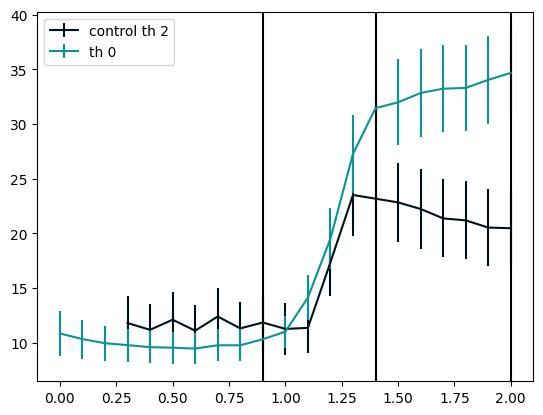

In [515]:
[e,w] = control
plt.errorbar(scaleEL,np.mean(overlap_recall[:,w,:],axis = 1), stats.sem(overlap_recall[:,w,:],axis = 1),color = color[0])
plt.errorbar(scaleEL,np.mean(overlap_recall_th0[:,w,:],axis = 1), stats.sem(overlap_recall_th0[:,w,:],axis = 1),color = color[2])
plt.legend(['control th 2','th 0'])
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')


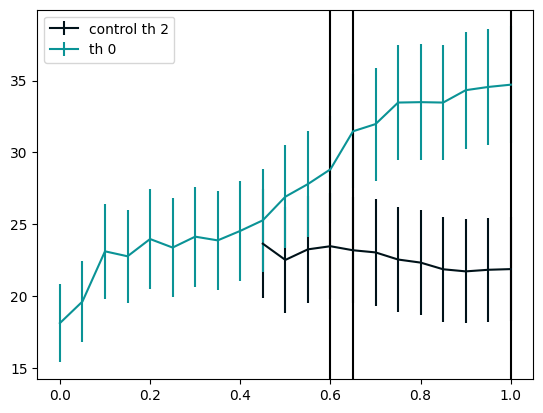

In [516]:
[e,w] = control
plt.errorbar(scaleWL,np.mean(overlap_recall[e,:,:],axis = 1), stats.sem(overlap_recall[e,:,:],axis = 1),color = color[0])
plt.errorbar(scaleWL,np.mean(overlap_recall_th0[e,:,:],axis = 1), stats.sem(overlap_recall_th0[e,:,:],axis = 1),color = color[2])
plt.legend(['control th 2','th 0'])
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

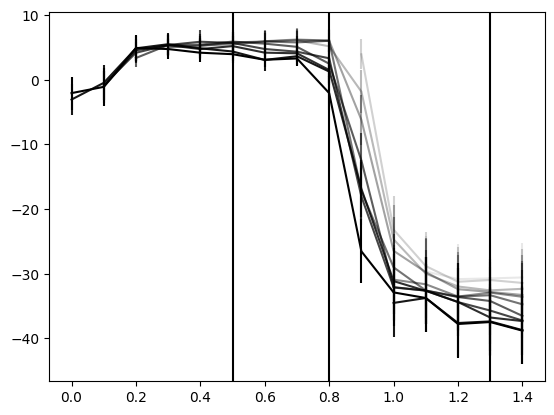

In [1440]:
[e,w] = control
for w in range(len(scaleWL)):
    plt.errorbar(scaleEL,np.mean(overlap_recall[:,w,:]-overlap_recall_th0[:,w,:],axis = 1), stats.sem(overlap_recall[:,w,:]-overlap_recall_th0[:,w,:],axis = 1), color = 'k', alpha = (w+1)/11)
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')


In [ ]:
[e,w] = control
for e in range(len(scaleEL)):
    plt.errorbar(scaleWL,np.mean(overlap_recall[e,:,:]-overlap_recall_th0[e,:,:],axis = 1), stats.sem(overlap_recall[e,:,:]-overlap_recall_th0[e,:,:],axis = 1), color = 'k', alpha = (e+1)/11)
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

#### manipulation

In [1442]:
[e,w] = control

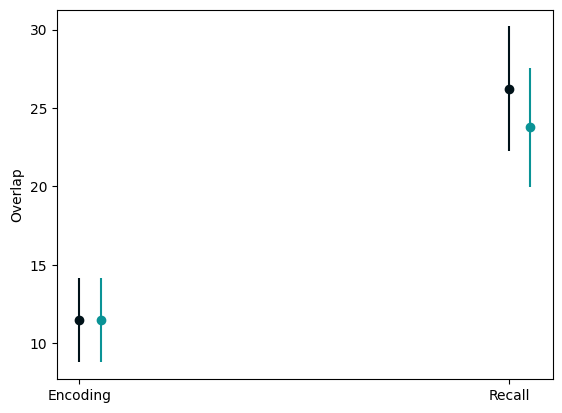

In [1443]:
c = 0
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod[e,w,:]),
                        np.mean(overlap_recall[e,w,:])],
                       [stats.sem(overlap_encod[e,w,:]),
                        stats.sem(overlap_recall[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod_th0[e,w,:]),
                        np.mean(overlap_recall_th0[e,w,:])],
                       [stats.sem(overlap_encod_th0[e,w,:]),
                        stats.sem(overlap_recall_th0[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')

#plt.text(.3,20,'control (theta = 2)', color = color[0])
#plt.text(.3,17,'non-specific priming (theta = 0)', color = color[2])
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.savefig('overlap_threshold.png',dpi = 500,bbox_inches='tight')

[8, 6]
[5, 2]
[13, -1]


Text(1, 4.9, 'increased epigenetic')

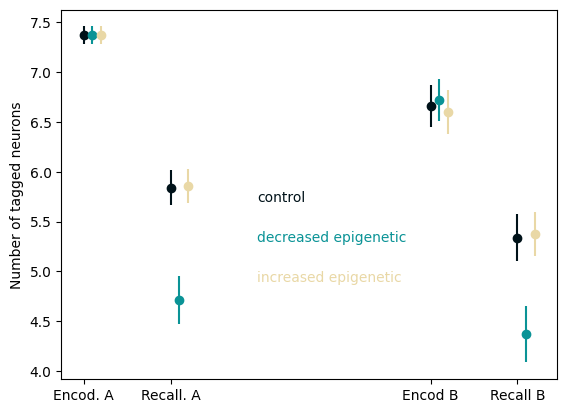

In [1444]:
c = 0
for [e,w] in [control,down,up]:
    print([e,w])
    plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A[e,w,:]),
                              np.mean(size_recall_A[e,w,:]),
                              np.mean(size_encod_B[e,w,:]),
                              np.mean(size_recall_B[e,w,:])],
                             [stats.sem(size_encod_A[e,w,:]),
                              stats.sem(size_recall_A[e,w,:]),
                              stats.sem(size_encod_B[e,w,:]),
                              stats.sem(size_recall_B[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])
    c+=1
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0,.5,2,2.5],['Encod. A','Recall. A','Encod B','Recall B']);
plt.ylabel('Number of tagged neurons')
#plt.legend(['control','decreased epigenetic', 'increased epigenetic'])

plt.text(1,5.7,'control', color = color[0])
plt.text(1,5.3,'decreased epigenetic', color = color[2])
plt.text(1,4.9,'increased epigenetic', color = color[4])



#plt.savefig('size_3C.png',dpi = 500,bbox_inches='tight')

[9, 6]
[5, 2]
[13, -1]


Text(0.2, 5.4, 'increased epigenetic')

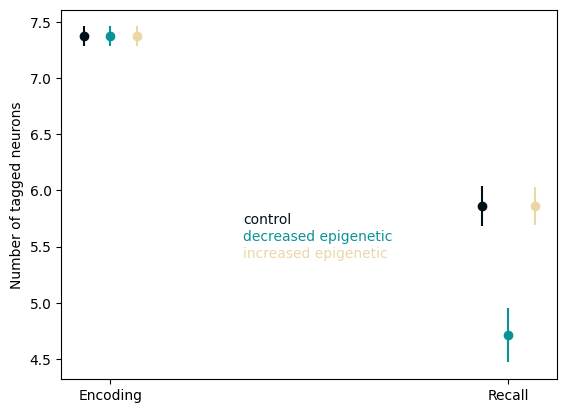

In [1427]:
c = 0
for [e,w] in [control,down,up]:
    print([e,w])
    plt.errorbar(np.array([0,.5]) + c/30,[np.mean(size_encod_A[e,w,:]),
                              np.mean(size_recall_A[e,w,:])],
                             [stats.sem(size_encod_A[e,w,:]),
                              stats.sem(size_recall_A[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])
    c+=1
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks(np.array([0,.5]) + 1/30,['Encoding','Recall']);
plt.ylabel('Number of tagged neurons')
#plt.legend(['control','decreased epigenetic', 'increased epigenetic'])

plt.text(.2,5.7,'control', color = color[0])
plt.text(.2,5.55,'decreased epigenetic', color = color[2])
plt.text(.2,5.4,'increased epigenetic', color = color[4])



#plt.savefig('size_3C_bis.png',dpi = 500,bbox_inches='tight')

#### figure

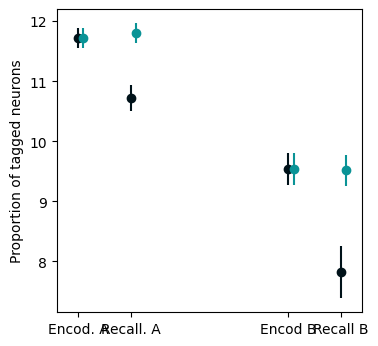

In [781]:
plt.figure(figsize = (100/mm,100/mm))

[e,w] = control
c = 0
plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A[e,w,:]),
                          np.mean(size_recall_A[e,w,:]),
                          np.mean(size_encod_B[e,w,:]),
                          np.mean(size_recall_B[e,w,:])],
                         [stats.sem(size_encod_A[e,w,:]),
                          stats.sem(size_recall_A[e,w,:]),
                          stats.sem(size_encod_B[e,w,:]),
                          stats.sem(size_recall_B[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])

c = 1
plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A_th0[e,w,:]),
                          np.mean(size_recall_A_th0[e,w,:]),
                          np.mean(size_encod_B_th0[e,w,:]),
                          np.mean(size_recall_B_th0[e,w,:])],
                         [stats.sem(size_encod_A_th0[e,w,:]),
                          stats.sem(size_recall_A_th0[e,w,:]),
                          stats.sem(size_encod_B_th0[e,w,:]),
                          stats.sem(size_recall_B_th0[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])

#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0,.5,2,2.5],['Encod. A','Recall. A','Encod B','Recall B']);
plt.ylabel('Proportion of tagged neurons')


#plt.text(.8,5.6,'control (theta = 2)', color = color[0])
#plt.text(.8,5.45,'non-specific priming (theta = 0)', color = color[2])

plt.xlim(-.2,2.7)
plt.savefig('size_threshold.pdf',dpi = 500,bbox_inches='tight')

#### figure

In [627]:
results = np.load('results_overlap_10_f.npy')
np.shape(results)

(21, 21, 2, 100, 12)

In [689]:
results = np.load('results_overlap_10_noB_f.npy')
np.shape(results)

(21, 21, 2, 100, 12)

In [690]:
p = 1

size_encod_A = results[:,:,p,:,0]
size_encod_B = results[:,:,p,:,1]
size_recall_A = results[:,:,p,:,2]
size_recall_B = results[:,:,p,:,3]

size_encod_A_th0 = results[:,:,0,:,0]
size_encod_B_th0 = results[:,:,0,:,1]
size_recall_A_th0 = results[:,:,0,:,2]
size_recall_B_th0 = results[:,:,0,:,3]

overlap_encod = results[:,:,p,:,4]
overlap_recall = results[:,:,p,:,5]
overlap_encod_th0 = results[:,:,0,:,4]
overlap_recall_th0 = results[:,:,0,:,5]

In [691]:
## _10, f, same param as 9, more precise
scaleEL = np.arange(0,2.1,.1)
scaleWL = np.arange(0,1.05,.05)

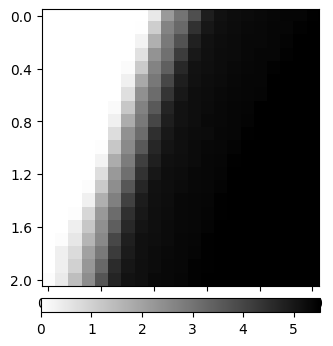

In [704]:
plt.figure(figsize = (100/mm,100/mm))
[e,w] = control

plt.imshow(np.mean(size_recall_A[:,:,:], axis = 2), cmap = 'binary')
plt.xticks(range(0,21,4),[round(scaleWL[i],1) for i in range(0,21,4)])
plt.yticks(range(0,21,4),[round(scaleEL[i],1) for i in range(0,21,4)])

plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")

plt.savefig('heatmap_size.pdf',dpi = 500,bbox_inches='tight')

In [693]:
results = np.load('results_weights_10_f.npy')
np.shape(results)

(21, 21, 2, 100, 6, 5)

In [694]:
th = 1
t = -1
weights_A = results[:,:,th,:,0,t]
rates_A   = results[:,:,th,:,1,t]
priming_A = results[:,:,th,:,2,t]
weights_B = results[:,:,th,:,3,t]
rates_B   = results[:,:,th,:,4,t]
priming_B = results[:,:,th,:,5,t]

In [695]:
np.shape(weights_A)

(21, 21, 100)

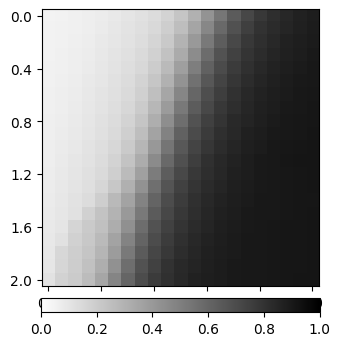

In [706]:
plt.figure(figsize = (100/mm,100/mm))
[e,w] = control

plt.imshow(np.mean(weights_A[:,:,:], axis = 2), cmap = 'binary', vmin = 0, vmax = 1)
plt.xticks(range(0,21,4),[round(scaleWL[i],1) for i in range(0,21,4)])
plt.yticks(range(0,21,4),[round(scaleEL[i],1) for i in range(0,21,4)])

plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")

plt.savefig('heatmap_weights.pdf',dpi = 500,bbox_inches='tight')

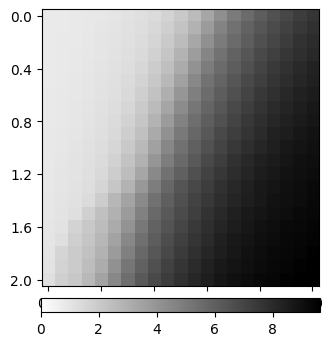

In [707]:
plt.figure(figsize = (100/mm,100/mm))
[e,w] = control

plt.imshow(np.mean(rates_A[:,:,:], axis = 2), cmap = 'binary', vmin = 0)
plt.xticks(range(0,21,4),[round(scaleWL[i],1) for i in range(0,21,4)])
plt.yticks(range(0,21,4),[round(scaleEL[i],1) for i in range(0,21,4)])

plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal")

plt.savefig('heatmap_rates.pdf',dpi = 500,bbox_inches='tight')

## Priming before, w/ and w/o exc

In [961]:
primed_before = True

In [962]:
extra = True

In [963]:
scaleE,scaleW = .9,.9 # control

In [975]:
# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)
        
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 
        
    #exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE*alpha

    dalphadt = np.zeros(N)[np.newaxis].T
    if primed_before:
        TAG[:int(N/5)] = 1
        
    # up
    dalphadt += (TAG == 1) * (t >= 100) * (t <= 200) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 3000) * (t <= 3100) * (TAG >= 1000) * (TAG <= 3000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 6000) * (t <= 6100) * (TAG >= 4000) * (TAG <= 6000) * (2 - alpha) / 10
    # down
    dalphadt += (TAG == 1) * (t > 200) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 3100) * (TAG >= 1000) * (TAG <= 3000) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 6100) * (TAG >= 4000) * (TAG <= 6000) * (1 - alpha) / tau_alpha
    
    
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur
    
    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
      
 

    # excitability
    dexcdt = np.zeros(N)[np.newaxis].T
    if extra: 
        dexcdt += (t > 3000) * ((r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE) 
        dexcdt[:int(N/5)] += (t <= 3000) * (scaleE - exc[:int(N/5)] + exc0[np.newaxis].T[:int(N/5)]) / tauE
        dexcdt[int(N/5):] += (t <= 3000) * (0 - exc[int(N/5):] + exc0[np.newaxis].T[int(N/5):]) / tauE
    else:
        dexcdt += (r >= threshold_alpha) * (scaleE * alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE
    
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t
        
    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt

In [976]:
### no B

seqA = []
seqB = []
for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)
for ev in range(1,Nevent+1):
        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)

base = 0
def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 +  IN * (1-ctx) * L/2 / 10


In [977]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)
# initialisation

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]



# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
alpha = y[index[3][:],:]


#plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
#plt.show()

0


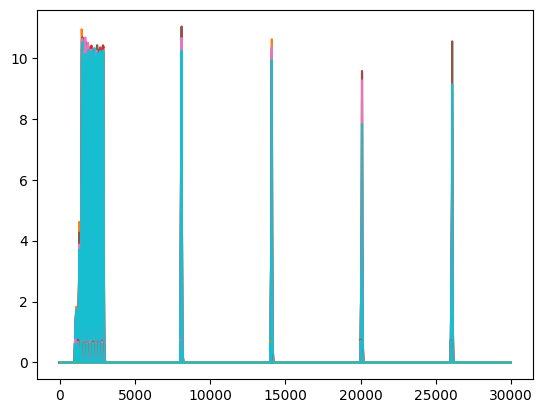

In [978]:
for n in range(N):
    rate = y[index[0][n],:]
    plt.plot(rate)
plt.show()

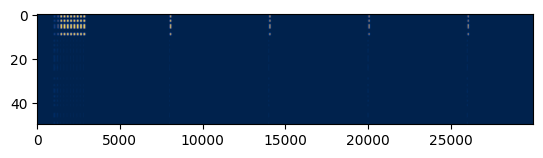

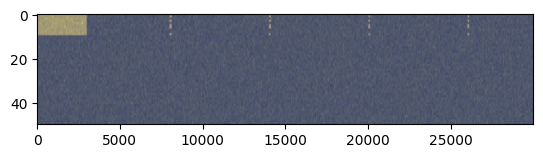

In [979]:
plt.imshow(y[index[0][:],:],aspect = nstep/N*2/9,cmap = 'cividis')
plt.show()
plt.imshow(y[index[2][:],:],aspect = nstep/N*2/9,cmap = 'cividis')
plt.show()

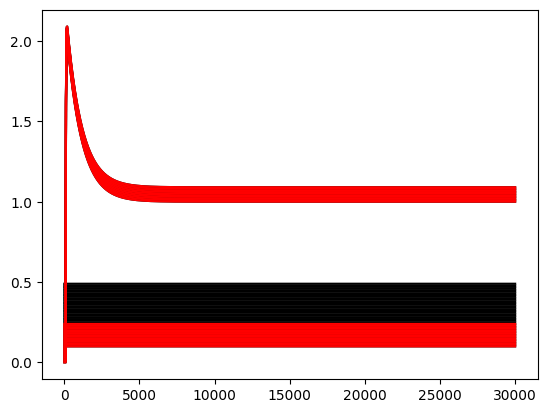

In [980]:
for n in range(N):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'k')

for n in range(int(N/2)):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'r')
plt.show()

### loop

seed = 0
primed_before = False, extra = False


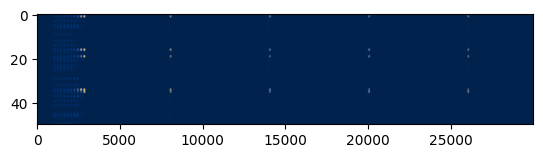

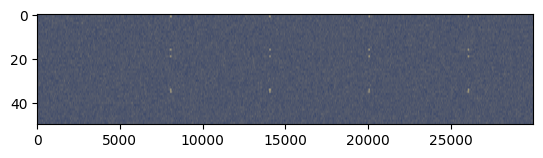

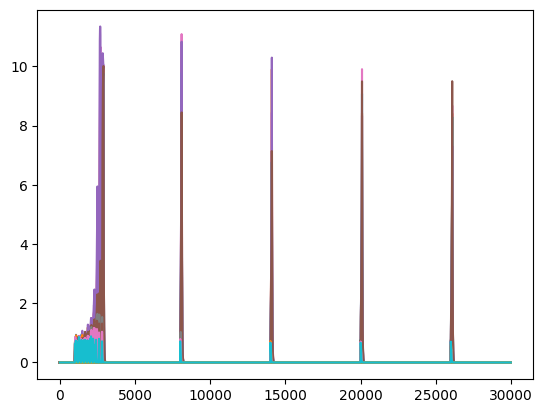

primed_before = False, extra = True


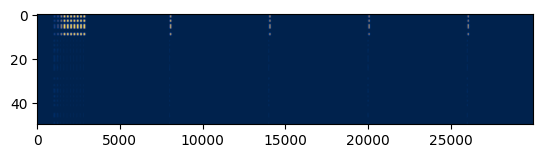

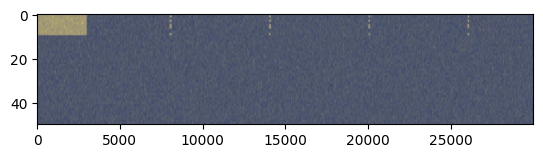

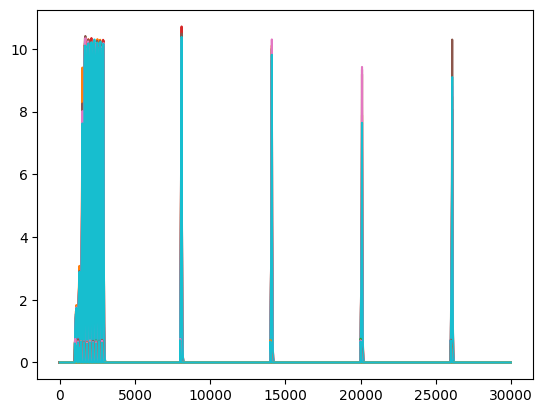

primed_before = True, extra = False


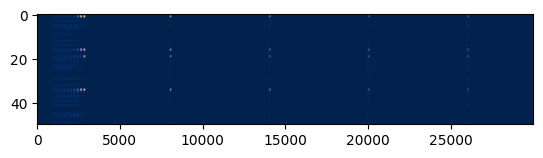

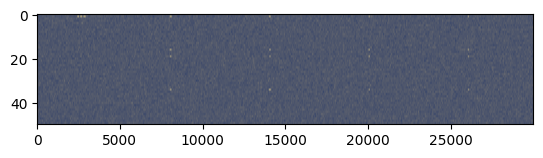

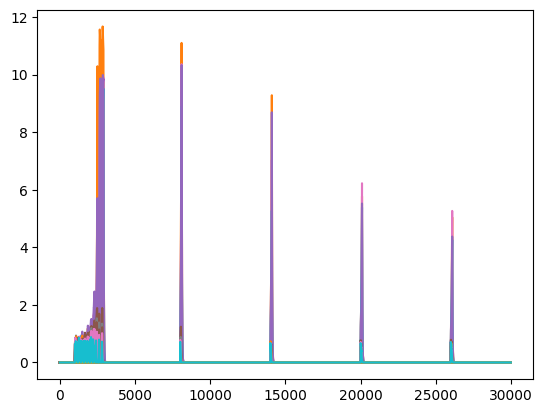

primed_before = True, extra = True


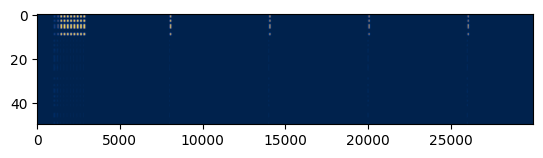

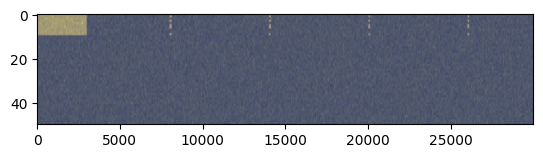

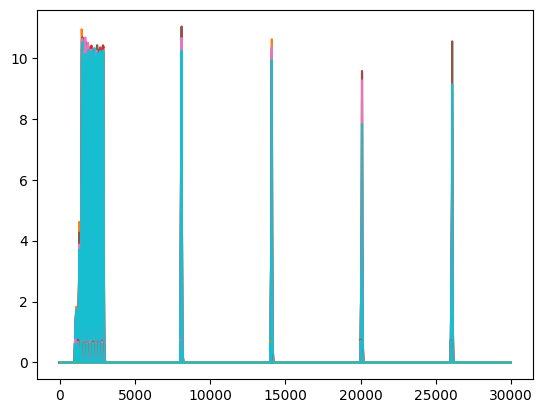

seed = 1
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 2
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 3
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 4
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 5
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 6
primed_before = False, extra = False
primed_before = False, extra = True
primed_before = True, extra = False
primed_before = True, extra = True
seed = 7
primed_before = False, extra = False
primed_before = False, extra = True


In [981]:
Nseed = 10

rates = np.zeros((Nseed,4,N,nstep))
excitability = np.zeros((Nseed,4,N,nstep))
priming = np.zeros((Nseed,4,N,nstep))



for seed in range(Nseed):
#for seed in [1]:
    
    np.random.seed(seed)
    random.seed(seed)
    print('seed = '+str(seed))
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    

    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA) 
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

        
    scenario = 0
    for primed_before in [False, True]:
        for extra in [False, True]:
            print('primed_before = '+str(primed_before)+', extra = '+str(extra))
            
            y = run(INPUT)
    
            priming[seed,scenario,:,:] = y[index[3][:],:]
            excitability[seed,scenario,:,:] = y[index[2][:],:]
            scenario +=1 

            
            if seed == 0:

                plt.imshow(y[index[0][:],:],aspect = nstep/N*2/9,cmap = 'cividis')
                plt.show()
                plt.imshow(y[index[2][:],:],aspect = nstep/N*2/9,cmap = 'cividis')
                plt.show()

                for n in range(N):
                    rate = y[index[0][n],:]
                    plt.plot(rate)
                plt.show()


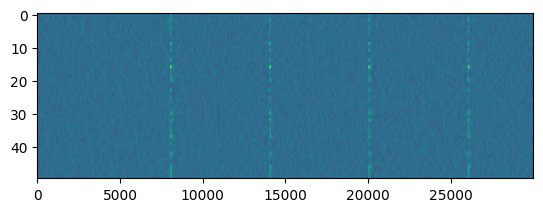

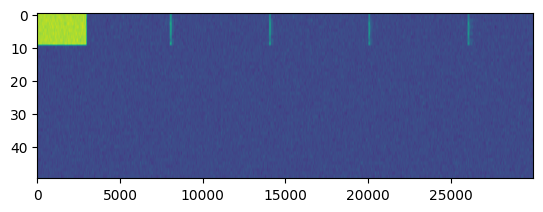

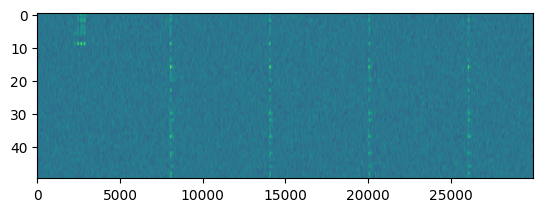

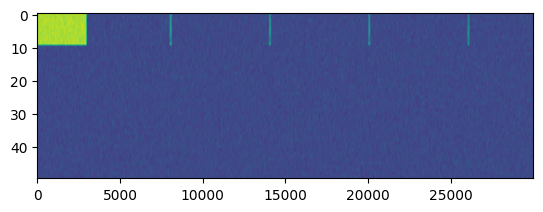

In [986]:
for scenario in range(4):
    plt.figure()
    plt.imshow(np.mean(excitability[:,scenario,:,:],axis = 0), aspect = 200)
    #plt.imshow(excitability[0,scenario,:,:], aspect = 200)

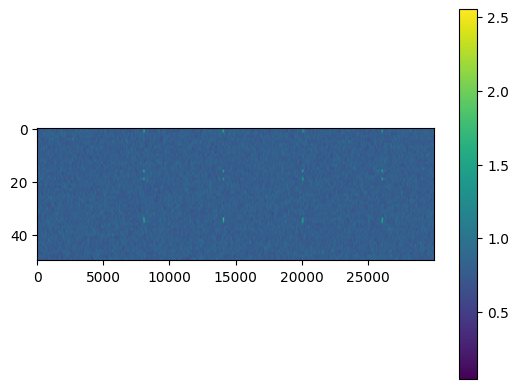

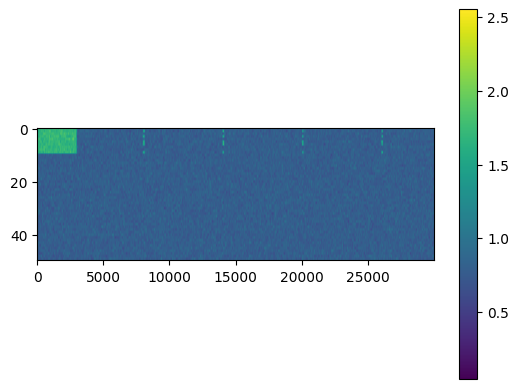

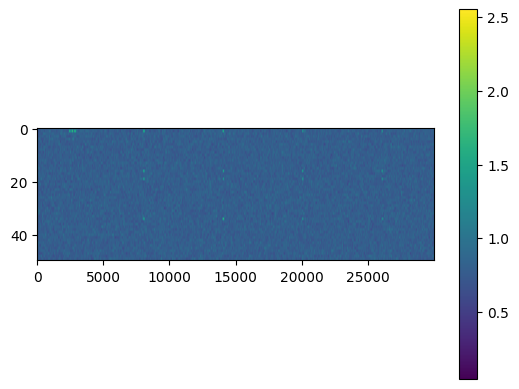

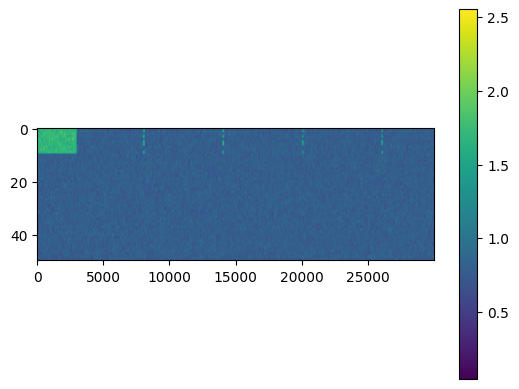

In [989]:
s = 0
for scenario in range(4):
    plt.figure()
    plt.imshow(excitability[s,scenario,:,:], aspect = 200)
    #plt.imshow(excitability[0,scenario,:,:], aspect = 200)
    plt.colorbar()

In [1005]:
np.mean((rates[:,:,:,:3000]>threshold))

0.0

In [1002]:
tagged = np.sum((rates[:,:,:,:3000]>threshold),axis = 3)>0
np.where(tagged)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

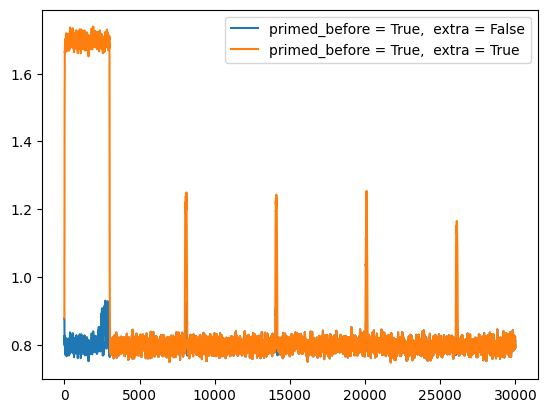

In [987]:
for scenario in range(2,4):
    plt.plot(np.mean(np.mean(excitability[:,scenario,:10,:],axis = 1),axis = 0))
    
plt.legend(['primed_before = True,  extra = False',
            'primed_before = True,  extra = True',])

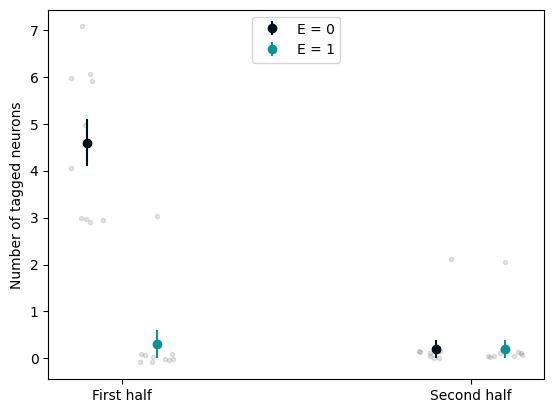

In [984]:
first =  np.sum(encod_A[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_A[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

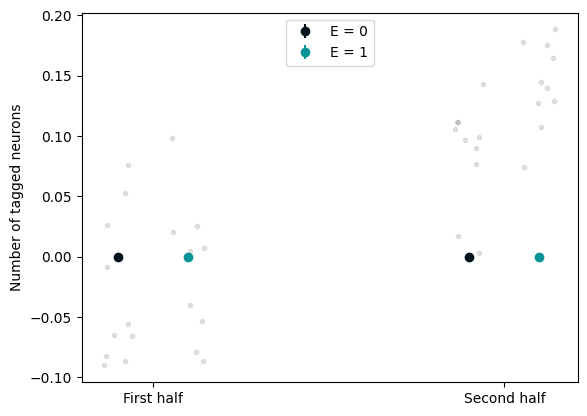

In [985]:
first =  np.sum(encod_B[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_B[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

### Loop python half primed

In [108]:
R = np.load('results_allocation_10_noB.npy')
Nseed = 100

Nf = 10
Ns = 40

#### figure Johannes

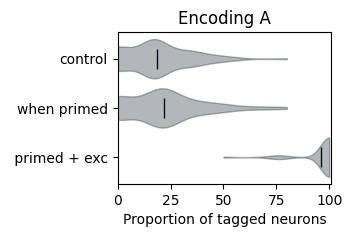

In [114]:
plt.figure(figsize = (70/mm,50/mm))

w = .8


e = 0

first = R[:,e,:,0]
second = R[:,e,:,1]

cc = 0
for p in [0,1]:
    X = np.array([0]) + 2 - p
    
    parts = plt.violinplot([100*first[p,:]/(first[p,:]+second[p,:])], X, vert = False, widths = w,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc])
        pc.set_edgecolor(color[cc])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc])
        vp.set_linewidth(1)
        
        
        
e = 1

first = R[:,e,:,0]
second = R[:,e,:,1]

X = [0] 
parts = plt.violinplot([100*first[1,:]/(first[1,:]+second[1,:])], X, vert = False, widths = w,showmeans=True, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor(color[cc])
    pc.set_edgecolor(color[cc])
    #pc.set_alpha(1)

for partname in ['cmeans']:
    vp = parts[partname]
    vp.set_edgecolor(color[cc])
    vp.set_linewidth(1)
        

plt.yticks([2,1,0],['control','when primed', ' primed + exc' ]);
plt.xlabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.xlim([0,101])

plt.title('Encoding A')
plt.savefig('primed_before_encodA.pdf',dpi = 500,bbox_inches='tight')

In [110]:
chance

array([0.02 , 0.024, 0.024, 0.024, 0.012, 0.012, 0.012, 0.02 , 0.024,
       0.016, 0.016, 0.028, 0.024, 0.02 , 0.016, 0.016, 0.024, 0.02 ,
       0.028, 0.024, 0.028, 0.024, 0.012, 0.016, 0.02 , 0.016, 0.012,
       0.016, 0.024, 0.024, 0.02 , 0.024, 0.016, 0.024, 0.012, 0.016,
       0.02 , 0.024, 0.016, 0.016, 0.028, 0.02 , 0.024, 0.024, 0.016,
       0.016, 0.012, 0.012, 0.016, 0.016, 0.02 , 0.02 , 0.028, 0.02 ,
       0.02 , 0.016, 0.024, 0.024, 0.012, 0.024, 0.02 , 0.024, 0.02 ,
       0.012, 0.02 , 0.02 , 0.02 , 0.016, 0.012, 0.024, 0.02 , 0.016,
       0.012, 0.024, 0.028, 0.02 , 0.024, 0.012, 0.012, 0.02 , 0.016,
       0.016, 0.028, 0.02 , 0.016, 0.024, 0.02 , 0.016, 0.024, 0.016,
       0.016, 0.028, 0.024, 0.028, 0.024, 0.02 , 0.012, 0.02 , 0.016,
       0.024])

In [111]:
first[p,:]/N

array([0.08, 0.1 , 0.08, 0.08, 0.06, 0.06, 0.06, 0.06, 0.12, 0.08, 0.08,
       0.1 , 0.08, 0.08, 0.06, 0.08, 0.08, 0.08, 0.12, 0.1 , 0.12, 0.08,
       0.06, 0.08, 0.1 , 0.06, 0.06, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
       0.08, 0.06, 0.08, 0.08, 0.06, 0.08, 0.08, 0.14, 0.08, 0.1 , 0.1 ,
       0.08, 0.08, 0.06, 0.06, 0.08, 0.08, 0.08, 0.06, 0.08, 0.1 , 0.08,
       0.08, 0.1 , 0.08, 0.06, 0.1 , 0.1 , 0.08, 0.06, 0.04, 0.1 , 0.08,
       0.08, 0.08, 0.06, 0.08, 0.08, 0.08, 0.04, 0.06, 0.08, 0.1 , 0.08,
       0.06, 0.06, 0.08, 0.08, 0.06, 0.08, 0.08, 0.08, 0.1 , 0.1 , 0.08,
       0.08, 0.08, 0.06, 0.08, 0.08, 0.1 , 0.08, 0.08, 0.04, 0.08, 0.08,
       0.08])

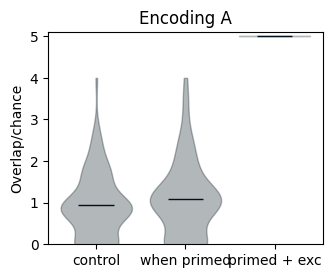

In [96]:
plt.figure(figsize = (90/mm,70/mm))

w = .8


e = 0

first = R[:,e,:,0]
second = R[:,e,:,1]

cc = 0
for p in [0,1]:
    X = np.array([0]) + p
    
    chance = 10 / N * (first[p,:]+second[p,:]) / N
    parts = plt.violinplot([first[p,:]/N/chance], X, vert = True, widths = w,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc])
        pc.set_edgecolor(color[cc])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc])
        vp.set_linewidth(1)
        
        
        
e = 1

first = R[:,e,:,0]
second = R[:,e,:,1]

X = [2] 
p = 1
chance = 10 / N * (first[p,:]+second[p,:]) / N
parts = plt.violinplot([first[p,:]/N/chance], X, vert = True, widths = w,showmeans=True, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor(color[cc])
    pc.set_edgecolor(color[cc])
    #pc.set_alpha(1)

for partname in ['cmeans']:
    vp = parts[partname]
    vp.set_edgecolor(color[cc])
    vp.set_linewidth(1)
        

plt.xticks([0,1,2],['control','when primed', 'primed + exc' ]);
plt.ylabel('Overlap/chance')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,5.1])

plt.title('Encoding A')
plt.savefig('primed_before_encodA.pdf',dpi = 500,bbox_inches='tight')

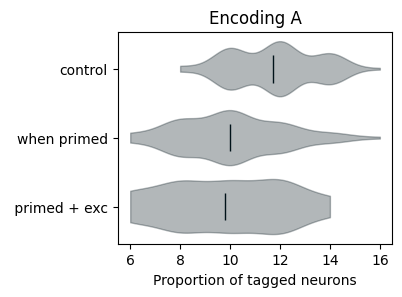

In [960]:
plt.figure(figsize = (90/mm,70/mm))

w = .8


e = 0

first = R[:,e,:,0]
second = R[:,e,:,1]

cc = 0
for p in [0,1]:
    X = np.array([0]) + 2 - p
    
    parts = plt.violinplot([100 * (first[p,:]+second[p,:]) / 50], X, vert = False, widths = w,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc])
        pc.set_edgecolor(color[cc])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc])
        vp.set_linewidth(1)
        
        
        
e = 1

first = R[:,e,:,0]
second = R[:,e,:,1]

X = [0] 
parts = plt.violinplot([100 * (first[1,:]+second[1,:]) / 50], X, vert = False, widths = w,showmeans=True, showmedians=False, showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor(color[cc])
    pc.set_edgecolor(color[cc])
    #pc.set_alpha(1)

for partname in ['cmeans']:
    vp = parts[partname]
    vp.set_edgecolor(color[cc])
    vp.set_linewidth(1)
        

plt.yticks([2,1,0],['control','when primed', ' primed + exc' ]);
plt.xlabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
#plt.xlim([0,101])

plt.title('Encoding A')
plt.savefig('primed_before_encodA_size.pdf',dpi = 500,bbox_inches='tight')

#### increased exc: Extra = False

In [907]:
e = 0

first_encod_A = R[:,e,:,0]
second_encod_A = R[:,e,:,1]
first_encod_B = R[:,e,:,2]
second_encod_B = R[:,e,:,3]

first_recall_A = R[:,e,:,4]
second_recall_A = R[:,e,:,5]
first_recall_B = R[:,e,:,6]
second_recall_B = R[:,e,:,7]

In [908]:
np.sum(second_recall_A == second_encod_A)

147

##### figure Johannes

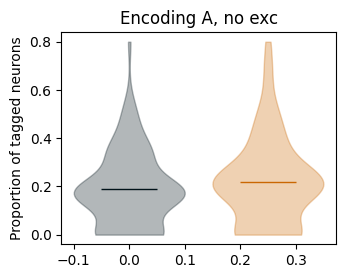

In [909]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A

cc = 6
for p in [0,1]:
    X = np.array([0]) + p/4
    
    parts = plt.violinplot([first[p,:]/(first[p,:]+second[p,:])],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)

#plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
#plt.ylim([-.01,1.01])

plt.title('Encoding A, no exc')
plt.savefig('primed_before_encodA_noexc.pdf',dpi = 500,bbox_inches='tight')

##### figure

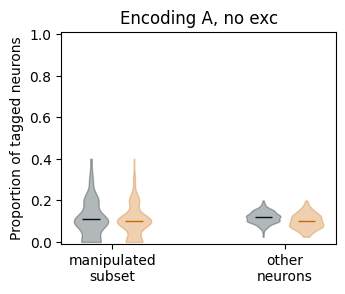

In [911]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A

cc = 6
for p in [0,1]:
    X = np.array([0,1]) + p/4
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)

plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([-.01,1.01])

plt.title('Encoding A, no exc')
plt.savefig('primed_before_encodA_noexc.pdf',dpi = 500,bbox_inches='tight')

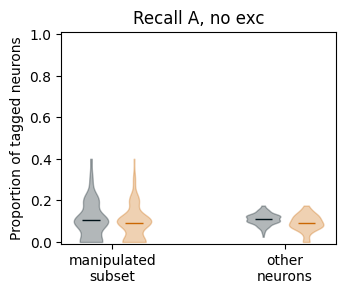

In [912]:
plt.figure(figsize = (90/mm,70/mm))

first = first_recall_A
second = second_recall_A

cc = 6
for p in [0,1]:
    X = np.array([0,1]) + p/4
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)

plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])
plt.ylim([-.01,1.01])

plt.title('Recall A, no exc')
plt.savefig('primed_before_recallA_noexc.pdf',dpi = 500,bbox_inches='tight')

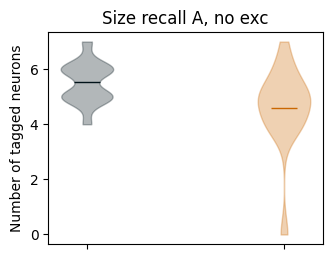

In [913]:
plt.figure(figsize = (90/mm,70/mm))

first = first_recall_A
second = second_recall_A

cc = 6
for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
    #                              second_encod_A[p,seed]])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

plt.xticks([0,.75],[]);
plt.title('Size recall A, no exc')
plt.savefig('primed_before_size_recallA_noexc.pdf',dpi = 500,bbox_inches='tight')

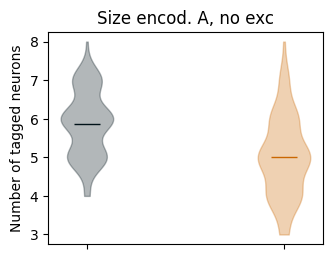

In [914]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A

cc = 6
for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
    #                              second_encod_A[p,seed]])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

plt.xticks([0,.75],[]);
plt.title('Size encod. A, no exc')
plt.savefig('primed_before_size_encodA_noexc.pdf',dpi = 500,bbox_inches='tight')

#### increased exc: Extra = True

In [915]:
e = 1

first_encod_A = R[:,e,:,0]
second_encod_A = R[:,e,:,1]
first_encod_B = R[:,e,:,2]
second_encod_B = R[:,e,:,3]

first_recall_A = R[:,e,:,4]
second_recall_A = R[:,e,:,5]
first_recall_B = R[:,e,:,6]
second_recall_B = R[:,e,:,7]

##### figure

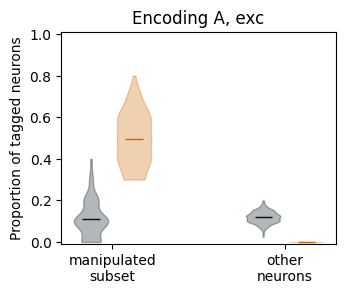

In [916]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A


cc = 6
for p in [0,1]:
    X = np.array([0,1]) + p/4
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)
        
plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
#plt.ylim([0,1])
plt.ylim([-.01,1.01])

plt.title('Encoding A, exc')
plt.savefig('primed_before_encodA_exc.pdf',dpi = 500,bbox_inches='tight')

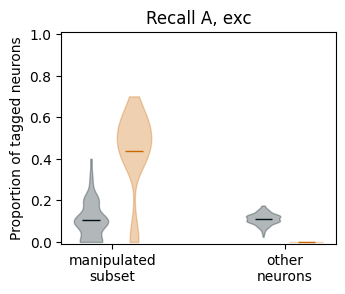

In [917]:
plt.figure(figsize = (90/mm,70/mm))

first = first_recall_A
second = second_recall_A

cc = 6
for p in [0,1]:
    X = np.array([0,1]) + p/4
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)

plt.xticks([0.125,1.125],['manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
#plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
#plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])
plt.ylim([-.01,1.01])

plt.title('Recall A, exc')
plt.savefig('primed_before_recallA_exc.pdf',dpi = 500,bbox_inches='tight')

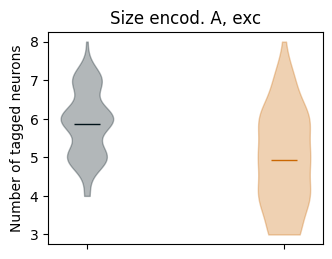

In [918]:
plt.figure(figsize = (90/mm,70/mm))

first = first_encod_A
second = second_encod_A

cc = 6
for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
    #                              second_encod_A[p,seed]])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

plt.xticks([0,.75],[]);
plt.title('Size encod. A, exc')
plt.savefig('primed_before_size_encodA_exc.pdf',dpi = 500,bbox_inches='tight')

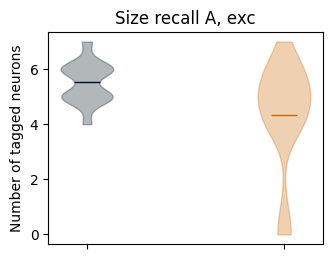

In [919]:
plt.figure(figsize = (90/mm,70/mm))

first = first_recall_A
second = second_recall_A

cc = 6
for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[cc*p])
        pc.set_edgecolor(color[cc*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[cc*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
    #                              second_encod_A[p,seed]])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

plt.xticks([0,.75],[]);
plt.title('Size recall A, exc')
plt.savefig('primed_before_size_recallA_exc.pdf',dpi = 500,bbox_inches='tight')

## Priming before, allocation

In [176]:
primed_before = True

In [177]:
threshold_alpha = 0

In [179]:
scaleE = .9
scaleW = .1

In [123]:
# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)
        
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 
        
    exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE*alpha

    dalphadt = np.zeros(N)[np.newaxis].T
    if primed_before:
        TAG[:int(N/5)] = 1
    # up
    dalphadt += (TAG == 1) * (t >= 100) * (t <= 200) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 3000) * (t <= 3100) * (TAG >= 1000) * (TAG <= 3000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 6000) * (t <= 6100) * (TAG >= 4000) * (TAG <= 6000) * (2 - alpha) / 10
    # down
    dalphadt += (TAG == 1) * (t > 200) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 3100) * (TAG >= 1000) * (TAG <= 3000) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 6100) * (TAG >= 4000) * (TAG <= 6000) * (1 - alpha) / tau_alpha
    
    
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur
    
    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
      
 

    # excitability
    exc = yt[index[2]][np.newaxis].T
    dexcdt = np.zeros(N)
    dexcdt = (r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE 
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t
        
    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt

0


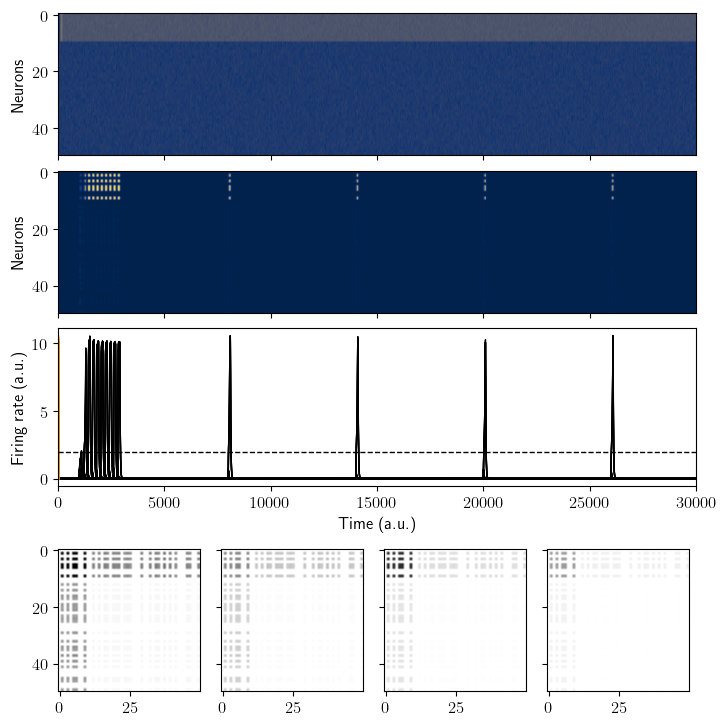

In [97]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)
# initialisation

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]



# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
alpha = y[index[3][:],:]


plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
plt.show()

In [98]:
alpha = y[index[3][:],:]

In [99]:
np.shape(alpha)

(50, 30000)

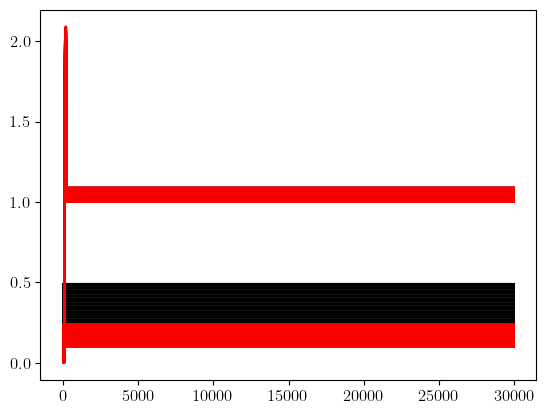

In [100]:
for n in range(N):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'k')

for n in range(int(N/2)):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'r')
plt.show()

### loop

seed = 0
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


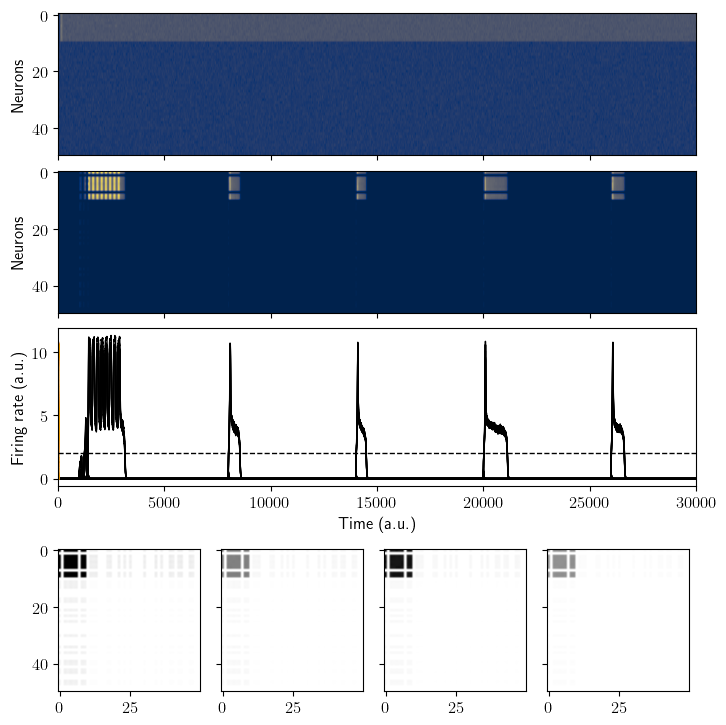

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


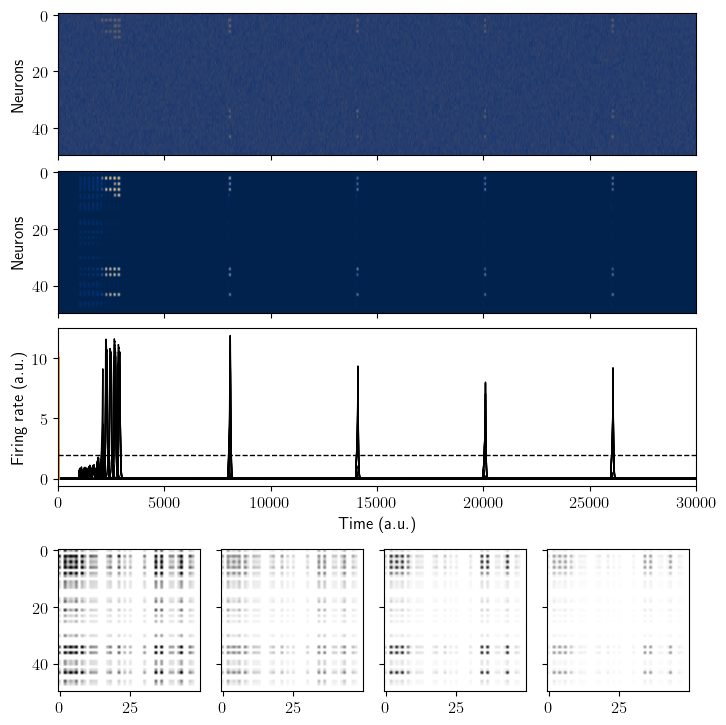

seed = 1
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


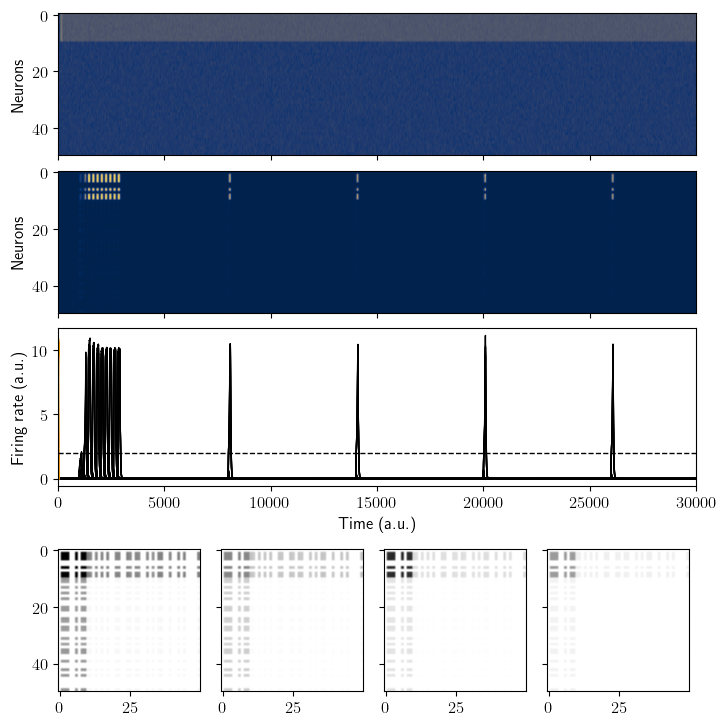

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


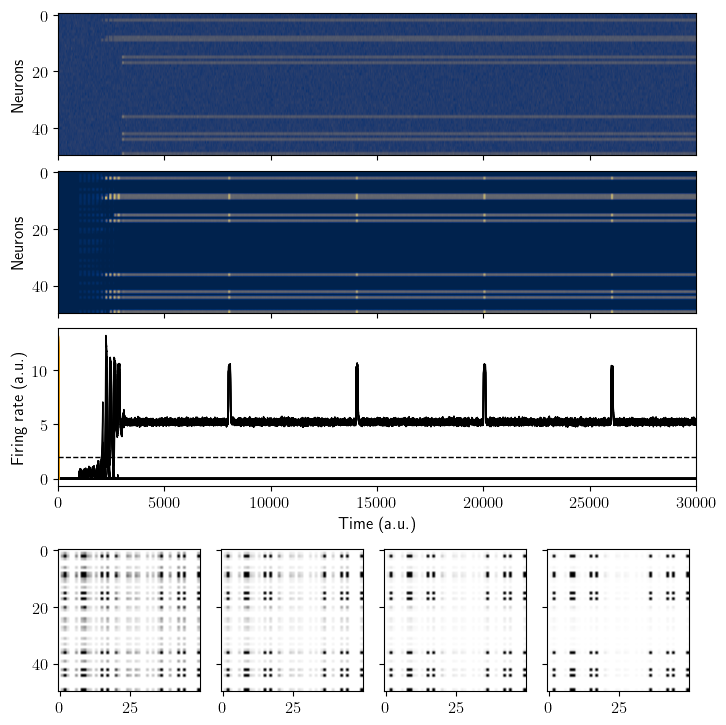

seed = 2
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


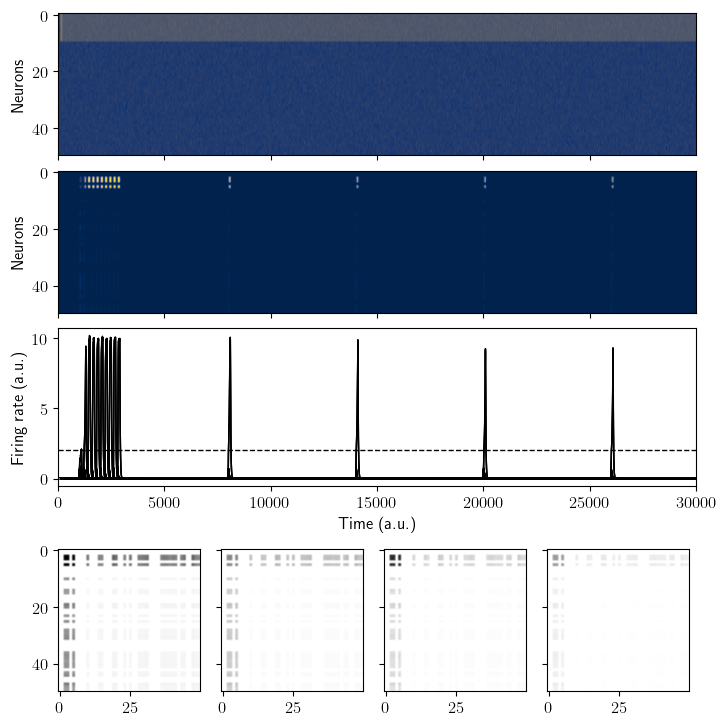

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


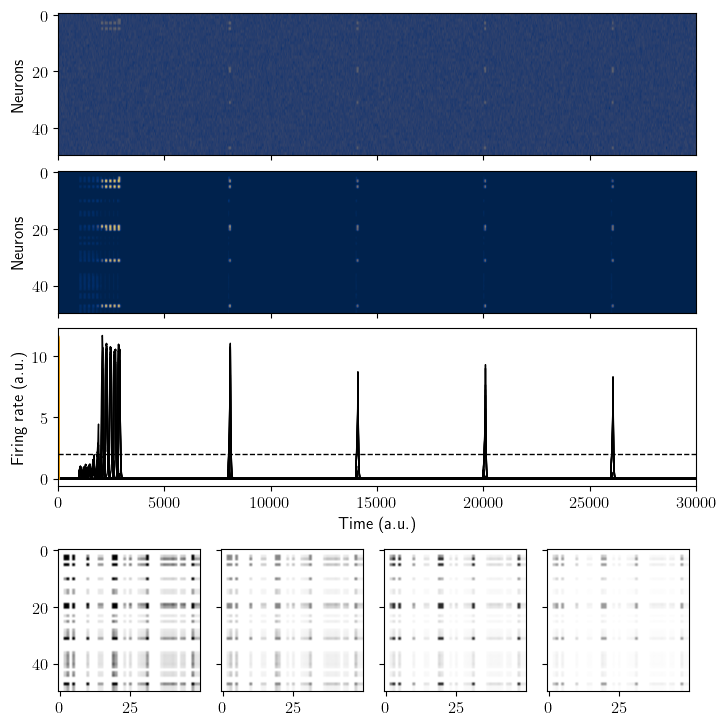

seed = 3
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


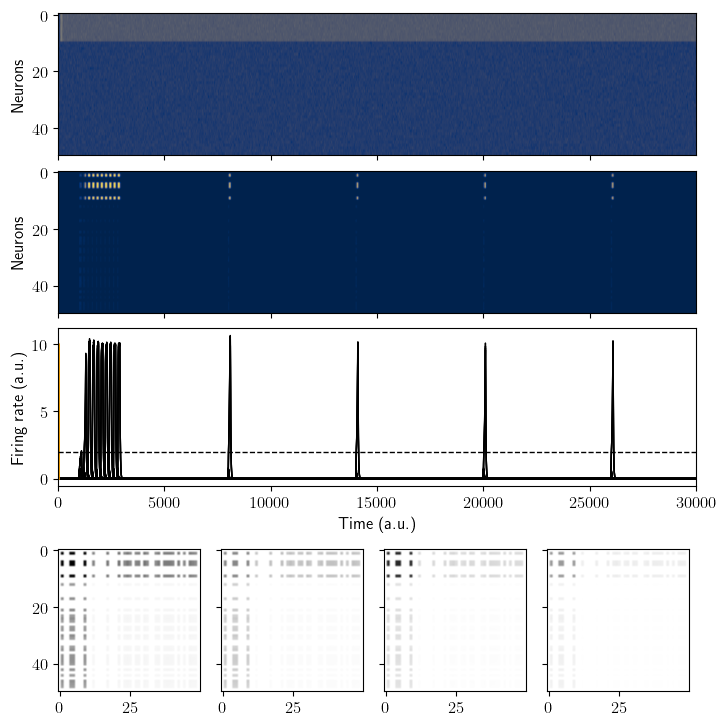

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


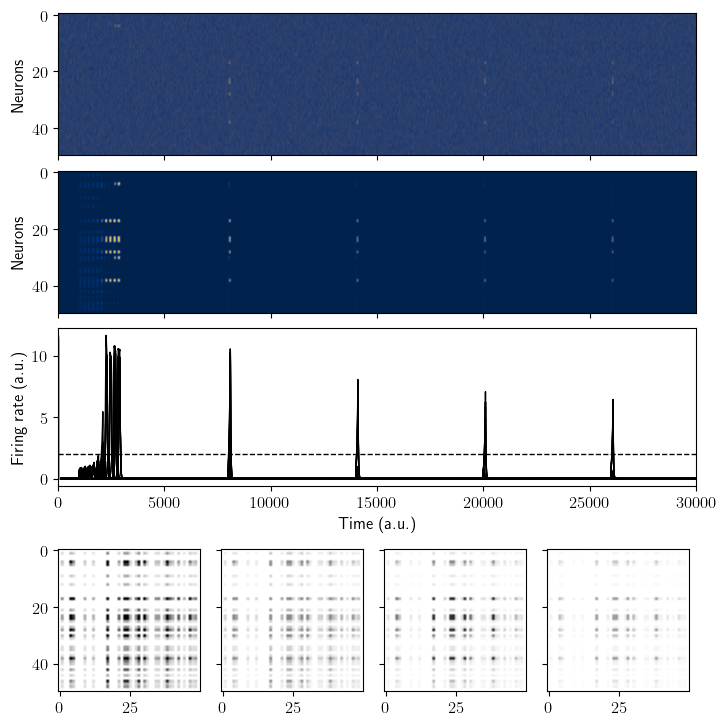

seed = 4
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


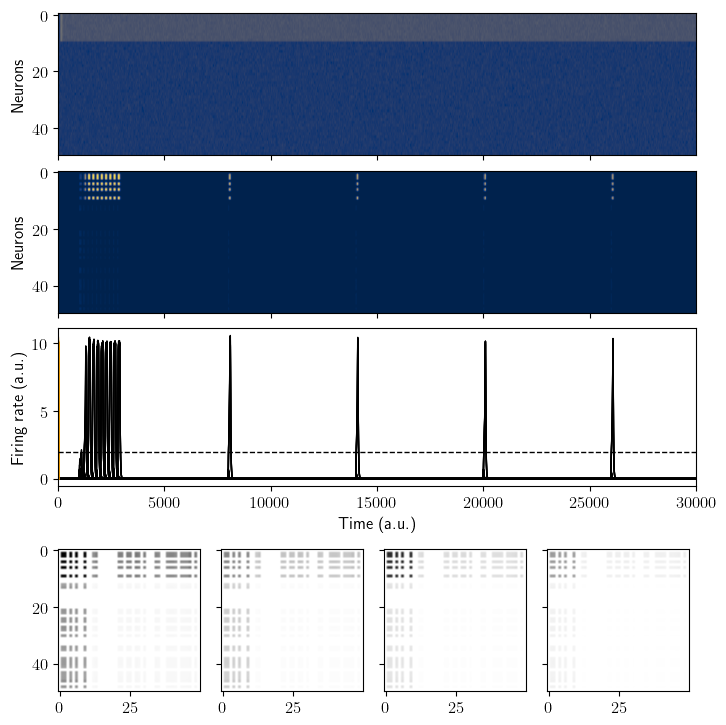

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


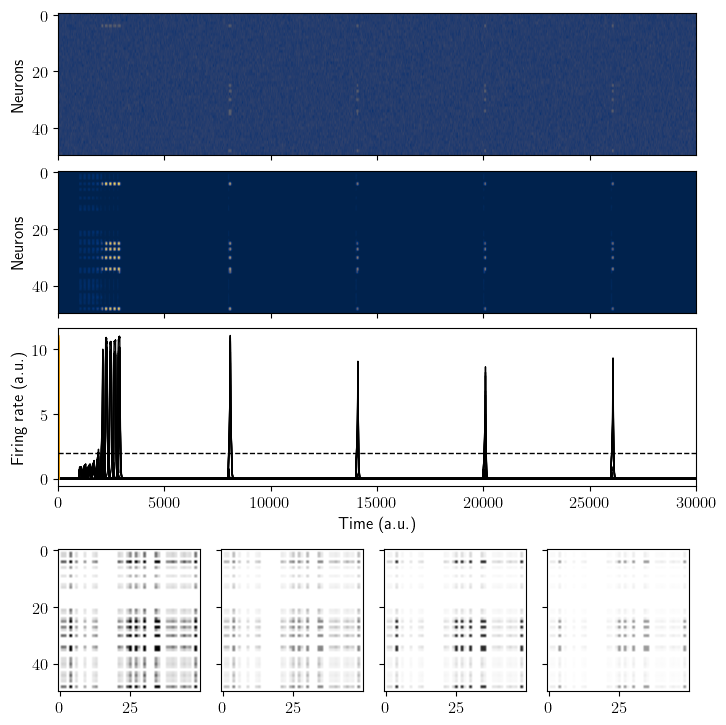

seed = 5
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


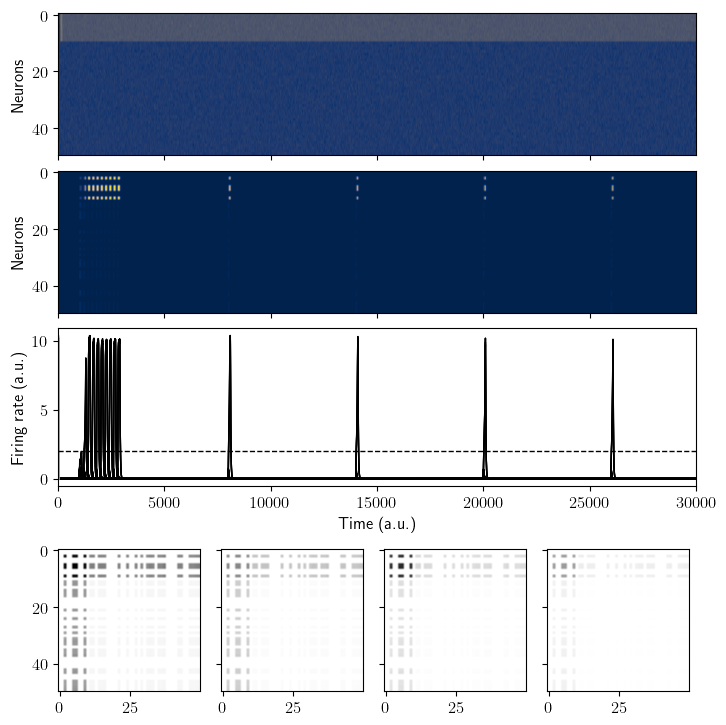

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


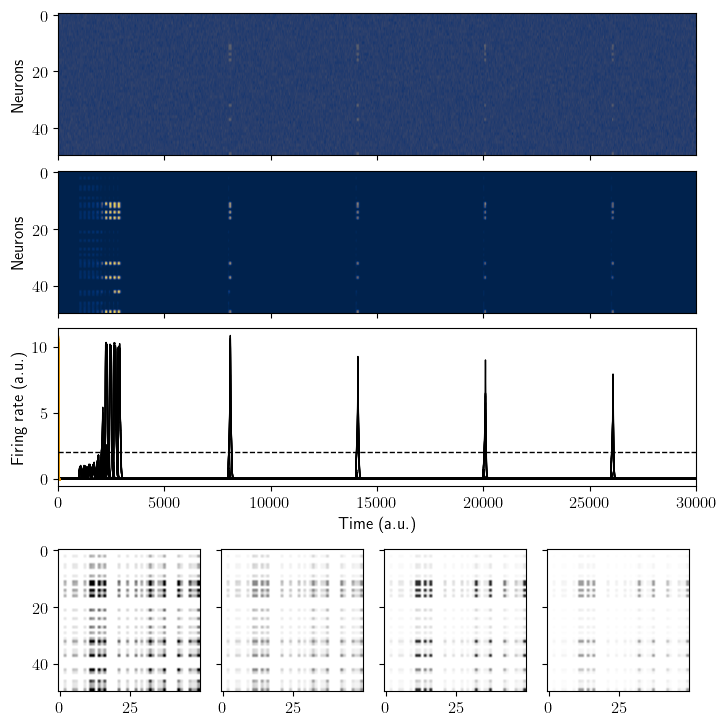

seed = 6
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


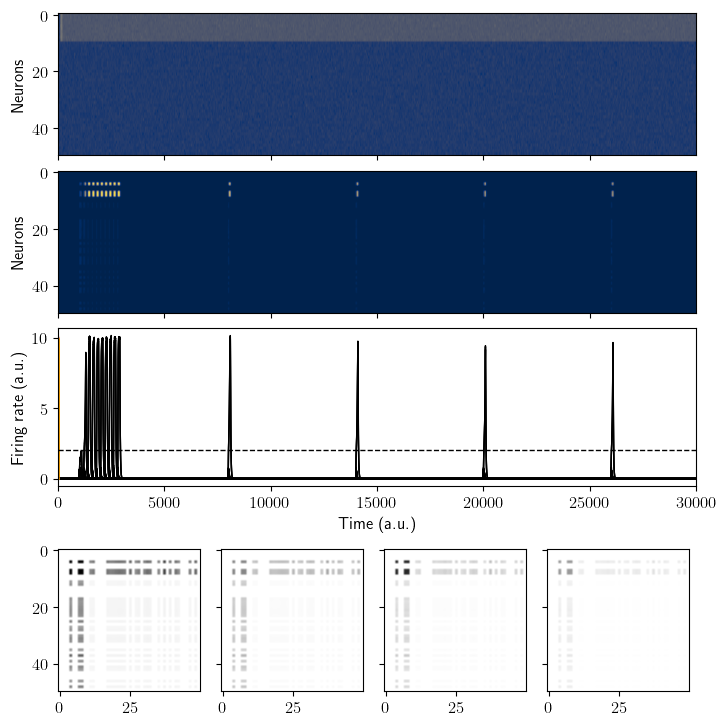

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


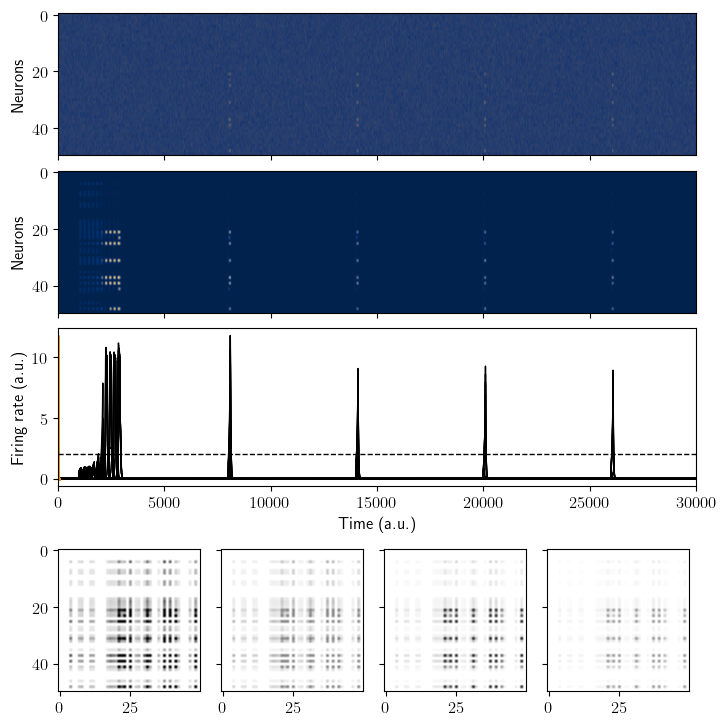

seed = 7
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


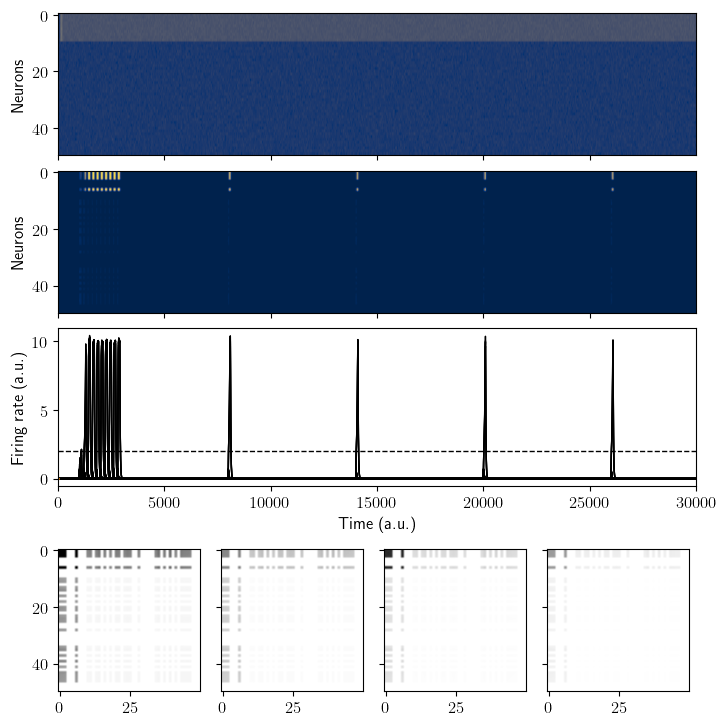

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


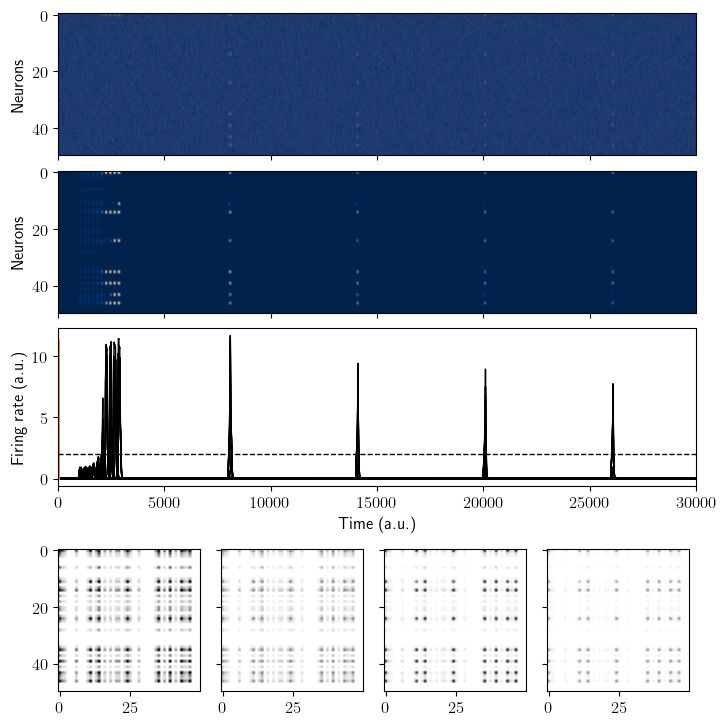

seed = 8
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


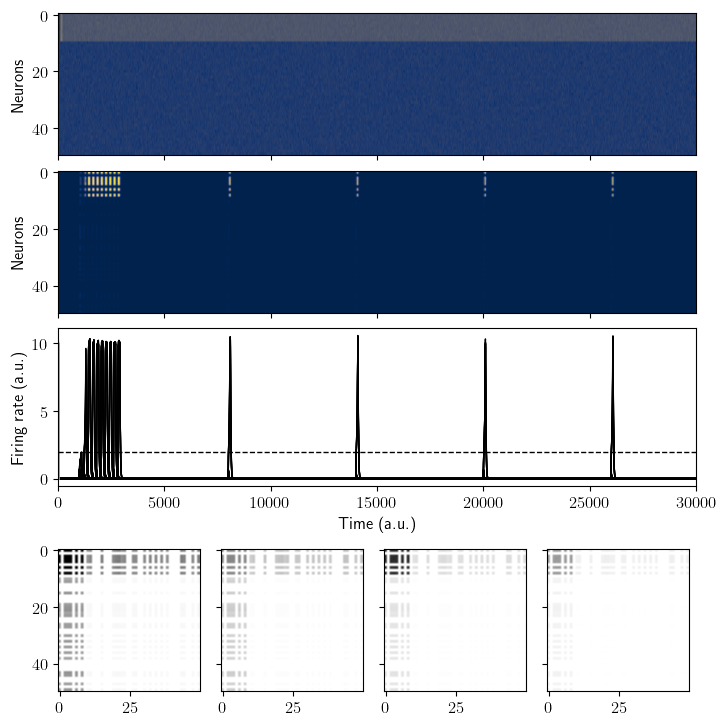

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


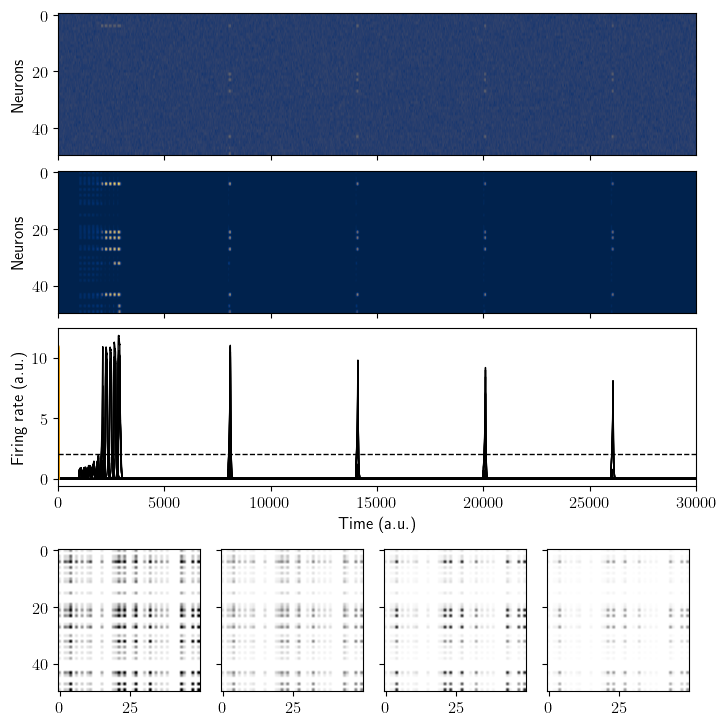

seed = 9
[0.9, 0]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


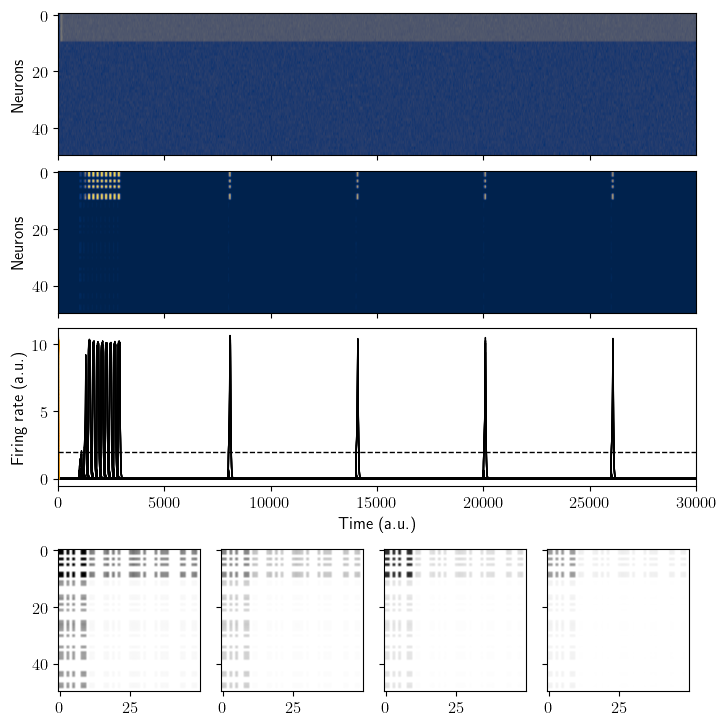

[0.9, 2]


/tmp/ipykernel_12311/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


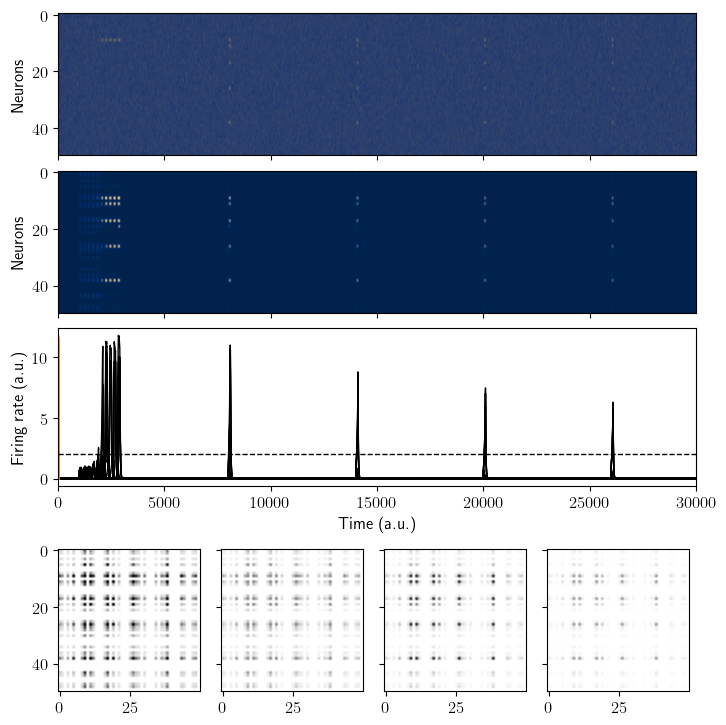

In [124]:
Nseed = 10

weights_A = np.zeros((Nseed,4,nstep))
rates_A = np.zeros((Nseed,4,nstep))
priming_A = np.zeros((Nseed,4,nstep))

weights_B = np.zeros((Nseed,4,nstep))
rates_B = np.zeros((Nseed,4,nstep))
priming_B = np.zeros((Nseed,4,nstep))

rates = np.zeros((Nseed,4,N,nstep))

encod_A = np.zeros((Nseed,4,N))
encod_B = np.zeros((Nseed,4,N))
recall_A = np.zeros((Nseed,4,N))
recall_B = np.zeros((Nseed,4,N))
test = np.zeros((4,Nseed))

for seed in range(Nseed):
#for seed in [1]:
    
    np.random.seed(seed)
    random.seed(seed+2*Nseed)
    print('seed = '+str(seed))
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    

    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA) 
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    test[:,seed] = np.array([sum(ctxA[:int(N/2)]),sum(ctxA[int(N/2):]),sum(ctxB[:int(N/2)]),sum(ctxB[int(N/2):])])
    for scaleE in [.9]:
        for scaleW in [.2]:
            for threshold_alpha in [0,2]:
   # for scaleE in [0]:
    #    for scaleW in [0]:
    #        for threshold_alpha in [0]:
        #for I0b in [9.5,10,10.5]:
        #for scaleW in [0,2,5]:
            # run
                print([scaleE,threshold_alpha])
                y = run(INPUT)
                #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
                TAG_A = TAG * (TAG < 3000)
                TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

                weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
                rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
                priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

                weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
                rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
                priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

                #rates[seed,scenario,:,:] = y[index[0]]

                encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
                encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
                recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
                recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

                #n = 3
                #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
                #rates[seed,scenario,:] = y[index[0][n],:]
                #priming[seed,scenario,:] = y[index[3][n],:]

                overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
                overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
                #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
                #print(overlap_encod)
                #print(overlap_recall)
                #plt.show()

                #n = np.where(TAG != 0)[0][0]

                if seed == 990:

                    for n in range(N):
                        rate = y[index[0][n],:]
                        plt.plot(rate)
                    plt.show()


                    for n in range(N):
                        alpha = y[index[3][n],:]+n/100
                        plt.plot(alpha, 'k')
                        
                    for n in range(int(N/2)):
                        alpha = y[index[3][n],:]+n/100
                        plt.plot(alpha, 'r')
                    plt.show()

                    plt.plot(weights_A[seed,scenario,:])
                    plt.show()

                    plt.plot(weights_B[seed,scenario,:])
                    plt.show()

                    plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
                    plt.show()
                    
                plot_all()
                plt.show()
                scenario +=1 


In [ ]:
first =  np.sum(encod_A[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_A[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

In [ ]:
first =  np.sum(encod_B[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_B[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

### Loop python half primed

In [181]:
R = np.load('results_allocation_2_noB.npy')
Nseed = 1000
threshold_alphaL = np.arange(0,2.1,.1)
threshold_alphaL = [0,2]
scaleE,scaleW = .9,.1 # control
np.shape(R)

Nf = 10
Ns = 40

Text(0, 0.5, 'Number of tagged neurons')

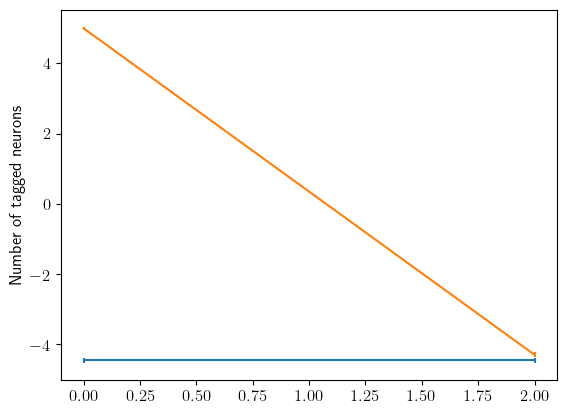

In [182]:
for p in [0,1]:
    Y = R[p,:,:,0] - R[p,:,:,1]
    plt.errorbar(threshold_alphaL, np.mean(Y, axis =1), stats.sem(Y, axis =1))

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
#plt.text(.4,1,'control', color = color[0])
#plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


#plt.savefig('primed_before_encodA.png',dpi = 500)

Text(0, 0.5, 'Number of tagged neurons')

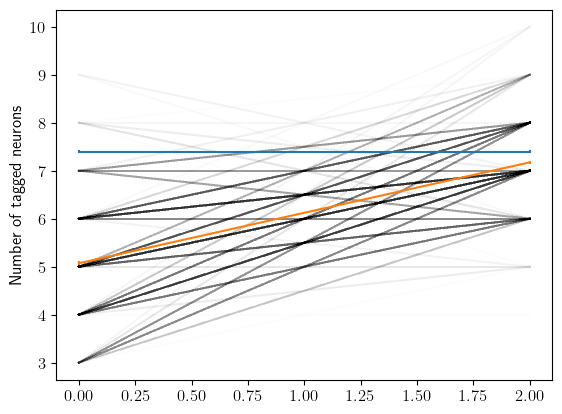

In [183]:
for p in [0,1]:
    Y = R[p,:,:,0] + R[p,:,:,1]
    plt.errorbar(threshold_alphaL, np.mean(Y, axis =1), stats.sem(Y, axis =1))

for seed in range(Nseed):
    for p in [1]:
        Y = R[p,:,seed,0] + R[p,:,seed,1]
        plt.plot(threshold_alphaL, Y,'k', alpha = 1/100)
    
plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
#plt.text(.4,1,'control', color = color[0])
#plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


#plt.savefig('primed_before_encodA.png',dpi = 500)

#### Threshold = 0

In [184]:
th = 0

first_encod_A = R[:,th,:,0]
second_encod_A = R[:,th,:,1]
first_encod_B = R[:,th,:,2]
second_encod_B = R[:,th,:,3]

first_recall_A = R[:,th,:,4]
second_recall_A = R[:,th,:,5]
first_recall_B = R[:,th,:,6]
second_recall_B = R[:,th,:,7]

In [185]:
np.sum(second_recall_A == second_encod_A)

1962

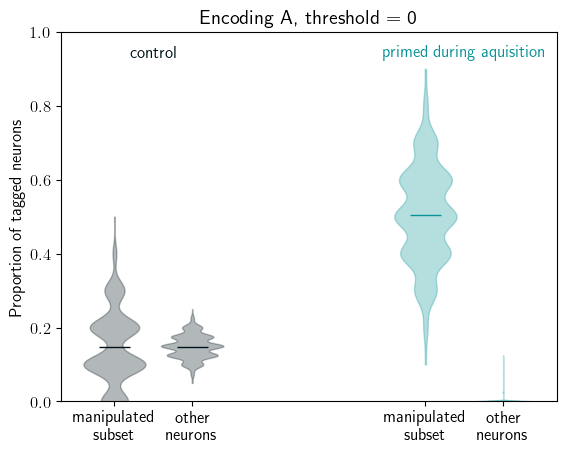

In [186]:
first = first_encod_A
second = second_encod_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]/Nf,
    #                              second_encod_A[p,seed]/Nf])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['manipulated\nsubset','other\nneurons','manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])

plt.title('Encoding A, threshold = 0')
plt.savefig('primed_before_encodA_th0.png',dpi = 500,bbox_inches='tight')

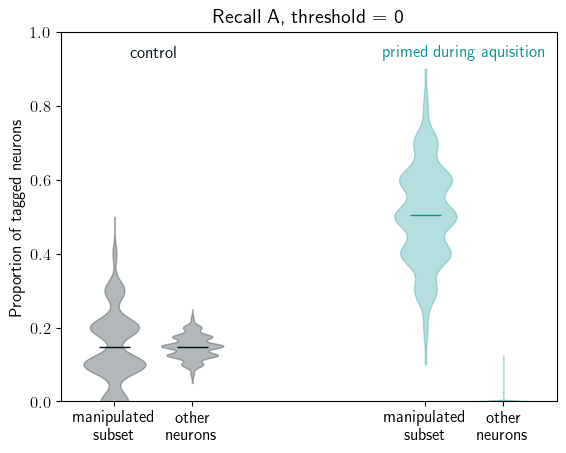

In [187]:
first = first_recall_A
second = second_recall_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)

plt.xticks([0,.25,1,1.25],['manipulated\nsubset','other\nneurons','manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])


plt.title('Recall A, threshold = 0')
plt.savefig('primed_before_recallA_th0.png',dpi = 500,bbox_inches='tight')

Text(0.5, 1.0, 'Encoding B, threshold = 0')

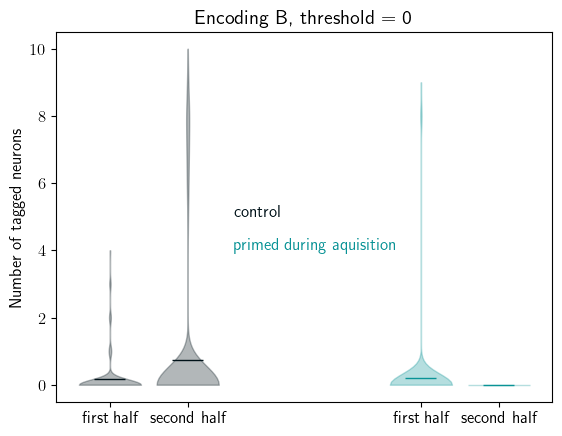

In [188]:
first = first_encod_B
second = second_encod_B

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
    #                              second_encod_A[p,seed]])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,5,'control', color = color[0])
plt.text(.4,4,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.title('Encoding B, threshold = 0')
#plt.savefig('primed_before_encodB_th0.png',dpi = 500,bbox_inches='tight')

Text(0.5, 1.0, 'Recall B, threshold = 0')

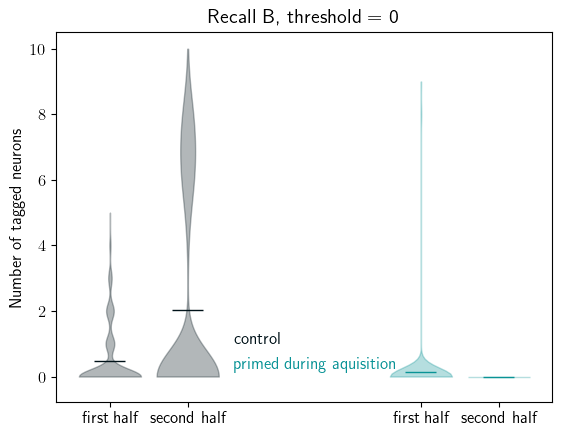

In [189]:
first = first_recall_B
second = second_recall_B

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,1,'control', color = color[0])
plt.text(.4,.2,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])



plt.title('Recall B, threshold = 0')
#plt.savefig('primed_before_recallB_th0.png',dpi = 500,bbox_inches='tight')

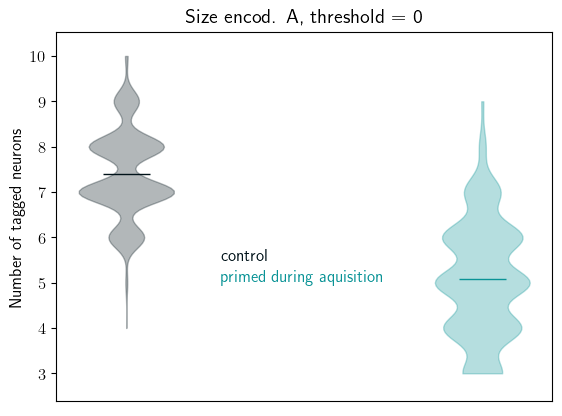

In [190]:
first = first_encod_A
second = second_encod_A

for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.2,5.5,'control', color = color[0])
plt.text(.2,5.0,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])

plt.xticks([],[]);
plt.title('Size encod. A, threshold = 0')
plt.savefig('primed_before_size_encodA_th0.png',dpi = 500,bbox_inches='tight')

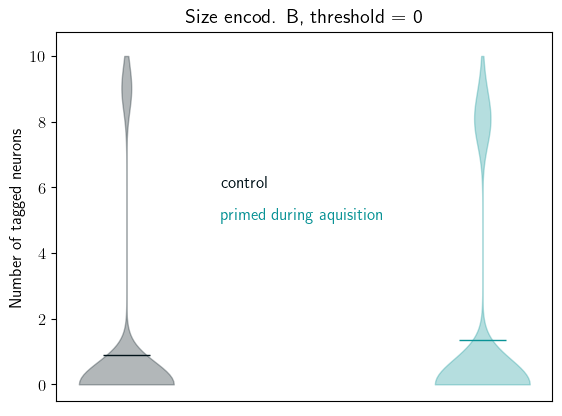

In [111]:
first = first_encod_B
second = second_encod_B

for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.2,6,'control', color = color[0])
plt.text(.2,5.0,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])

plt.xticks([],[]);
plt.title('Size encod. B, threshold = 0')
plt.savefig('primed_before_size_encodB_th0.png',dpi = 500,bbox_inches='tight')

#### Threshold = 2

In [191]:
th = -1

first_encod_A = R[:,th,:,0]
second_encod_A = R[:,th,:,1]
first_encod_B = R[:,th,:,2]
second_encod_B = R[:,th,:,3]

first_recall_A = R[:,th,:,4]
second_recall_A = R[:,th,:,5]
first_recall_B = R[:,th,:,6]
second_recall_B = R[:,th,:,7]

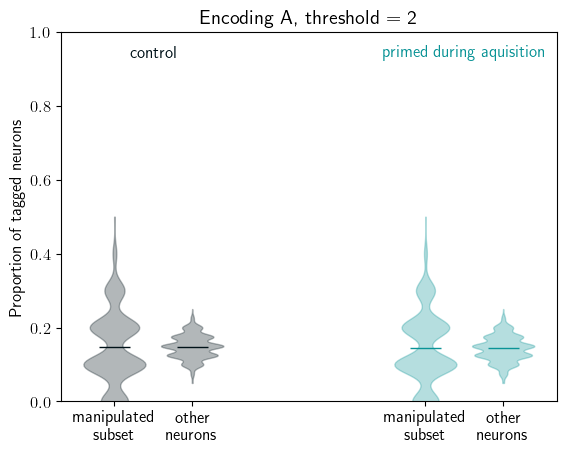

In [192]:
first = first_encod_A
second = second_encod_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    #for seed in range(Nseed):
    #    plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]/Nf,
    #                              second_encod_A[p,seed]/Nf])+random.random()/2-1/4
    #                             ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['manipulated\nsubset','other\nneurons','manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])

plt.title('Encoding A, threshold = 2')
plt.savefig('primed_before_encodA_th2.png',dpi = 500,bbox_inches='tight')

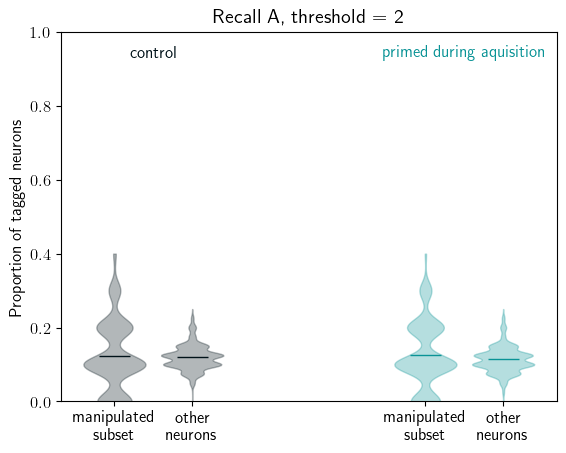

In [193]:
first = first_recall_A
second = second_recall_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:]/Nf,second[p,:]/Ns],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)

plt.xticks([0,.25,1,1.25],['manipulated\nsubset','other\nneurons','manipulated\nsubset','other\nneurons']);
plt.ylabel('Proportion of tagged neurons')
plt.text(0.125,.93,'control', color = color[0],horizontalalignment='center')
plt.text(1.125,.93,'primed during aquisition', color = color[2],horizontalalignment='center')
plt.ylim([0,1])


plt.title('Recall A, threshold = 2')
plt.savefig('primed_before_recallA_th2.png',dpi = 500,bbox_inches='tight')

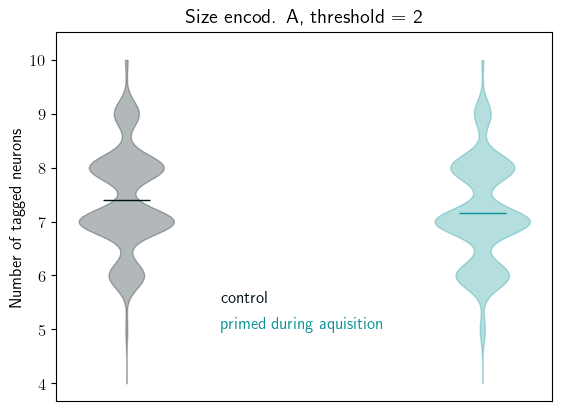

In [248]:
first = first_encod_A
second = second_encod_A

for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.2,5.5,'control', color = color[0])
plt.text(.2,5.0,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])

plt.xticks([],[]);

plt.title('Size encod. A, threshold = 2')
plt.savefig('primed_before_size_encodA_th2.png',dpi = 500,bbox_inches='tight')

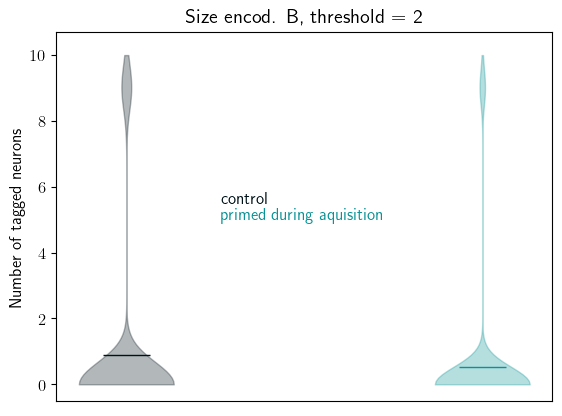

In [118]:
first = first_encod_B
second = second_encod_B

for p in [0,1]:
    X = np.array([p])*.75
    
    parts = plt.violinplot([first[p,:]+second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed]+
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.2,5.5,'control', color = color[0])
plt.text(.2,5.0,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])

plt.xticks([],[]);
plt.title('Size encod. B, threshold = 2')
plt.savefig('primed_before_size_encodB_th2.png',dpi = 500,bbox_inches='tight')

effect of competition of primed neurons: that's why decrease of size with E\
also, bigger range of size with memory B because of overlap: some neurons are similar to A, others are inversted and total is not 50/50

# END

try impose priming during encoding

try several stimulation instead of just one during recall

make list of predictions/findings

notes for Geoffroy [30 May]\
Albert: are you not worried about runaway plasticity.\
albert: whats the reason for decay of firing rate?\
G: recurrent waits decay over time\
Joel: might be interesting to look at the number of neurons that fall below the priming threshold at different onsets of priming (i.e. after 1 2 or 3 reactivations). It might also be that there is a critical number of neurons in an essembly necessary for stability\
Albert: elephant in the room is how can you have this sort of priming without merging of multiple engrams. Joel: rephrase of the same point, how much overlap between engrams leads to merging.\
Colleen: could random priming fluctuations (unrelated to activity) explain pattern separation and association?\
Albert: what does this add, beyond just having a higher baseline learning rate\
G: efficiency (metabolic)\
Colleen: multiple different mechanisms in parallel, through the diversity of points that can be acetylated.\
Joanna: cell type specificity of priming effects, maybe there is some consistency within a cell type which might change in “unison”\
Joanna: different timescales of priming would be interesting to look at.\

Meeting Johannes
artificially primed neuron: excitability increased shown, LTD alsoopening of "chromatine" actually very high after neutron experience  and then decay to the primed statespecificity: 2 lines of evidence
- shown by increasing epigenetic in A and test in B
- coupled epigenetic manipulation with rhodopsin, only context A is affectedquestion a lot and never been address: if we primed the system, will the memory last longer.


could you also constrained the priming further: something negative? loss of function\
primed neurons: change allocation?memory longer lasting could be an outcome of the paper\\

better primed curve\
loss of function\
allocation\
memory last longer: hammer a bit better\


# test

In [83]:
scaleE,scaleW,threshold_alpha,seed = [.9,.1,2,0]
noB = False
print('seed = ' + str(seed) + ', scaleE = ' + str(scaleE) + ', scaleW = ' + str(scaleW) + ', threshold_alpha = ' + str(threshold_alpha))

def run(INPUT):
    global step
    global TAG
    global TAG_r
    TAG = np.zeros(N)[np.newaxis].T
    TAG_r = np.zeros(N)[np.newaxis].T
    step = 0
    y0 = np.concatenate((r0,W0,exc0,alpha0,tag0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,dt)[np.newaxis]);
    return y


# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)

    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 

    exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE*alpha

    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur

    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))

    #dalphadt = np.zeros(N)[np.newaxis].T
    #dalphadt += (t>6000)*(TAG!=0) * (1 - alpha) * (t > TAG + delay_alpha) * (t < TAG + delay_alpha + delay_alpha_2) / tau_alpha_up 
    #dalphadt += (TAG!=0) * (0 - alpha) * (t > TAG + delay_alpha + delay_alpha_2) / tau_alpha_down

    dalphadt = np.zeros(N)[np.newaxis].T
    dalphadt += (TAG!=0) * (t >= 3000) * (t <= 3100) * (TAG < 3000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t >= 6000) * (t <= 6100) * (TAG > 3000) * (TAG < 6000) * (2 - alpha) / 10
    dalphadt += (TAG!=0) * (t > 3100) * (TAG < 3000) * (1 - alpha) / tau_alpha
    dalphadt += (TAG!=0) * (t > 6100) * (TAG > 3000) * (TAG < 6000) * (1 - alpha) / tau_alpha



    # excitability
    exc = yt[index[2]][np.newaxis].T
    dexcdt = np.zeros(N)
    dexcdt = (r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE 
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t

    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt


N = 50
r0 = np.zeros(N)
W0 = np.zeros(N*N)
tag0  = np.zeros(N)
index = [range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N),range(N + N*N +N+N,N + N*N +N+N+N)]



# parameters
threshold = 2
decay = 4000
tauw = 1500
taur = 20
tautheta = 100
I0 = 8
I1 = .5
E = 0
y0 = 2
sigma = 1
IN = 16

#tau_alpha_up = 10
#tau_alpha_down = tau_alpha_up
tau_alpha = 1000

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 1
#scaleE = 0#1
#scaleW = 0#1

overlap = 5/100





# protocol
seq = []
nstep = 30000
dt = 1
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000
Nevent = 5


seqA = []
seqB = []
for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)
for i in range(Nstim):
    seqB.append(pause + i*stim + delay)
    seqB.append(pause + i*stim + delay + duration)
for ev in range(1,Nevent+1):
        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)
        seqB.append(pause*2 + delay + 2*delay*ev)
        seqB.append(pause*2 + duration + delay + 2*delay*ev)

if noB:

    seqA = []
    seqB = []
    for i in range(Nstim):
        seqA.append(pause + i*stim)
        seqA.append(pause + i*stim + duration)
    for ev in range(1,Nevent+1):
            seqA.append(pause*2 + 2*delay*ev)
            seqA.append(pause*2 + duration + 2*delay*ev)


base = 0
def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return (IN-base) * ctx * L/2 + base










#scaleE = 0
#scaleW = 0

np.random.seed(seed)
random.seed(seed)

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]



#print([scaleE,threshold_alpha])
y = run(INPUT)

seed = 0, scaleE = 0.9, scaleW = 0.1, threshold_alpha = 2


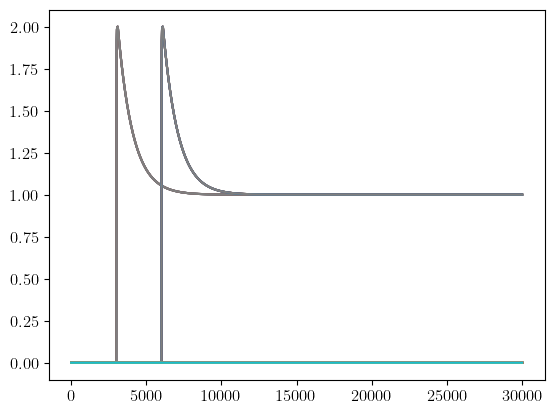

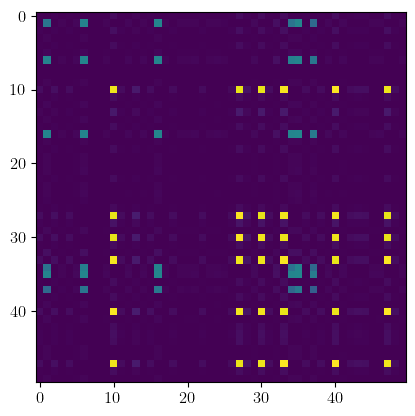

In [84]:
for n in range(N):
    alpha = y[index[3][n],:]
    plt.plot(alpha)
plt.show()

plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
plt.show()


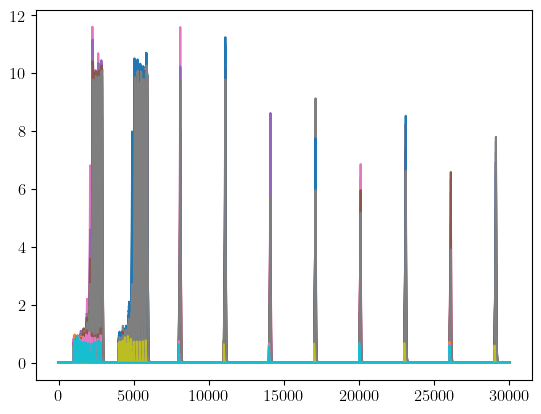

In [85]:
for n in range(N):
    rate = y[index[0][n],:]
    plt.plot(rate)
plt.show()

Text(4, 0.2, 'Firing rate (a.u)')

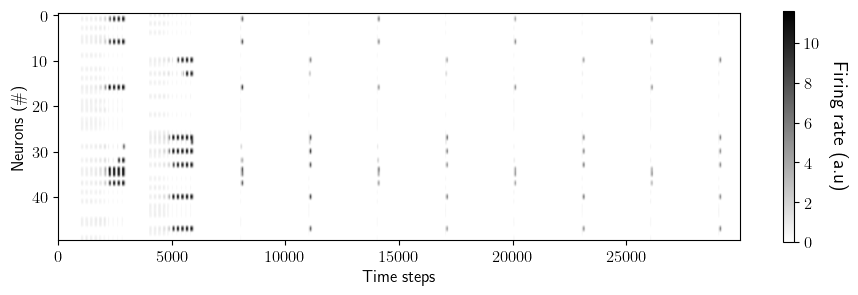

In [44]:
r = y[index[0][:],:]

plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )

# test

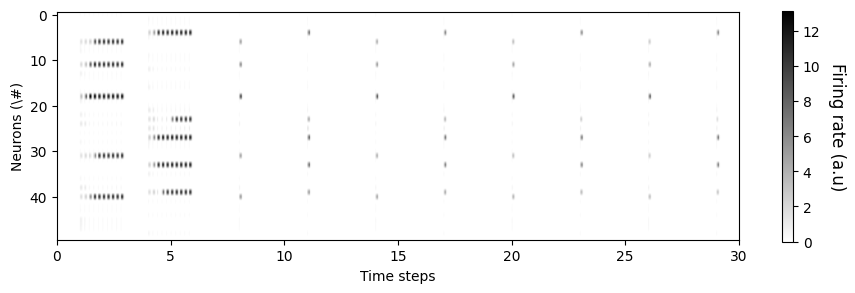

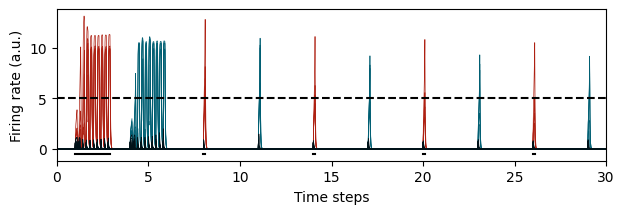

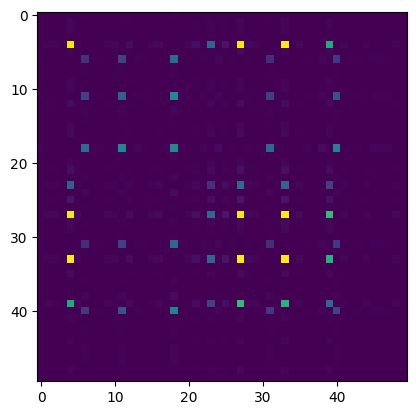

In [21]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import statistics
import itertools 
import random
mm = 25.4
color = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

def run(INPUT):
    global TAG
    TAG = np.zeros(N)[np.newaxis].T
    step = 0
    y0 = np.concatenate((r0,W0,exc0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,dt)[np.newaxis]);
    return y



# main function
def f(yt,t,dt):
    global TAG
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    exc = yt[index[2]][np.newaxis].T
    
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05
    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    dexcdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten()
                           ))
    TAG = TAG + (r >= threshold) * (TAG == 0) * t
    return dydt



# parameters
N = 50
threshold = 5
decay = 4000
tauw = 2500 
taur = 20
I0 = 7
I1 = .5 
IN = 16 
overlap = 5/100
sigma = 1

# protocol
seq = []
nstep = 30000
dt = 1
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000
Nevent = 5
base = 1/10

seqA = []
seqB = []
for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)
for i in range(Nstim):
    seqB.append(pause + i*stim + delay)
    seqB.append(pause + i*stim + delay + duration)
for ev in range(1,Nevent+1):
        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)
        seqB.append(pause*2 + delay + 2*delay*ev)
        seqB.append(pause*2 + duration + delay + 2*delay*ev)

def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 +  IN * (1-ctx) * L/2 * base


ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]

r0 = np.zeros(N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0) 
W0 = np.zeros(N*N)
index = [range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N)]


# run
y = run(INPUT)

#plot rate 1
r = y[index[0][:],:]
plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
#plt.savefig('fr1.pdf', dpi = 500, bbox_inches = 'tight')
plt.show()

#plot rate 2
plt.figure(figsize = (180/mm,50/mm))
lw = .5
for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[8],linewidth = lw)
for n in np.where(np.logical_and(TAG>3000,TAG<6000))[0]:
    plt.plot(r[n,:],color = color[1],linewidth = lw)
for n in np.where(TAG==0)[0]:
    plt.plot(r[n,:],color = color[0],linewidth = lw)
h = -.5
for s in range(int(len(seqA)/2)):
    plt.plot([seqA[2*s],seqA[2*s+1]],[h,h],'k')
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim(0,30)
plt.xticks(np.arange(0,35000,5000), np.arange(0,35,5))
plt.xlabel('Time steps')
plt.ylabel('Firing rate (a.u.)')
#plt.savefig('fr2.pdf', dpi = 500, bbox_inches = 'tight')
plt.show()


#plot final reccurent weights 
plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])


# OLD

# 2 memories
interesting

## Main function

In [8]:
def run(INPUT):
    global step
    global TAG
    global TAG_r
    TAG = np.zeros(N)[np.newaxis].T
    TAG_r = np.zeros(N)[np.newaxis].T
    step = 0
    y0 = np.concatenate((r0,W0,exc0,alpha0,tag0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,dt)[np.newaxis]);
    return y

In [9]:
# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)
        
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 
        
    exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE*alpha
    
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur
    
    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
      
    dalphadt = np.zeros(N)[np.newaxis].T
    dalphadt += (t>6000)*(TAG!=0) * (1 - alpha) * (t > TAG + delay_alpha) * (t < TAG + delay_alpha + delay_alpha_2) / tau_alpha_up 
    dalphadt += (TAG!=0) * (0 - alpha) * (t > TAG + delay_alpha + delay_alpha_2) / tau_alpha_down
    

    # excitability
    exc = yt[index[2]][np.newaxis].T
    dexcdt = np.zeros(N)
    dexcdt = (r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE 
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t
        
    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt

In [10]:
N = 50
I0 = 5
I1 = 1
#taus = 2000


taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)

In [11]:
tag0  = np.zeros(N)
index = [range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N),range(N + N*N +N+N,N + N*N +N+N+N)]

## Protocol 1 memory

In [12]:
seq = []
nstep = 30000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000
Nevent = 5


seqA = []
seqB = []

for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)

for ev in range(1,Nevent+1):
        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)


base = 0
def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return (IN-base) * ctx * L/2 + base


In [13]:
PA = np.zeros((N,nstep))
for t in range(nstep):
    PA[:,t] = INPUT(t,ctxA,seqA)
    
PB = np.zeros((N,nstep))
for t in range(nstep):
    PB[:,t] = INPUT(t,ctxB,seqB)

NameError: name 'ctxA' is not defined

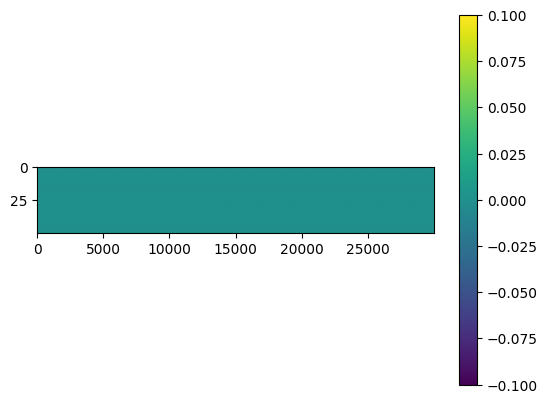

In [14]:
plt.imshow(PA,aspect = 100)
plt.colorbar()

In [15]:
plt.imshow(PB,aspect = 100)

NameError: name 'PB' is not defined

## Parameters

In [16]:
## ok
threshold = 2
threshold_alpha = 2

decayL = [4000]
tauwL = [1500]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [0]
y0L = [2]
sigmaL = [1]
INL = [16]
seedL = range(10)

tau_alpha_up = 10
tau_alpha_down = tau_alpha_up

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 1
scaleE = 0#1
scaleW = 0#1
 
overlap = 5/100

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


## Run

In [17]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)

 # initialisation

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]

# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
theta = y[index[3][:],:]


#plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
#plt.show()

0


### figure

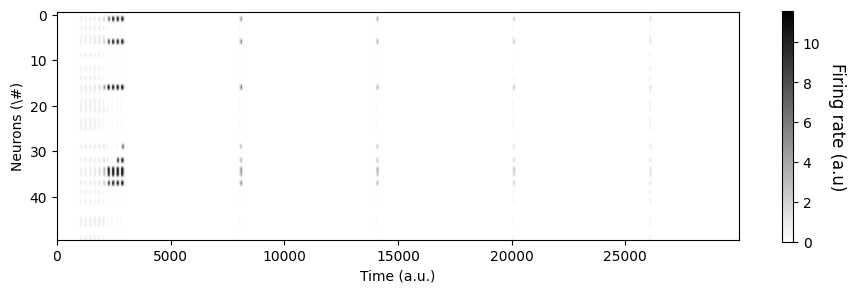

In [18]:
plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xlabel('Time (a.u.)')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )

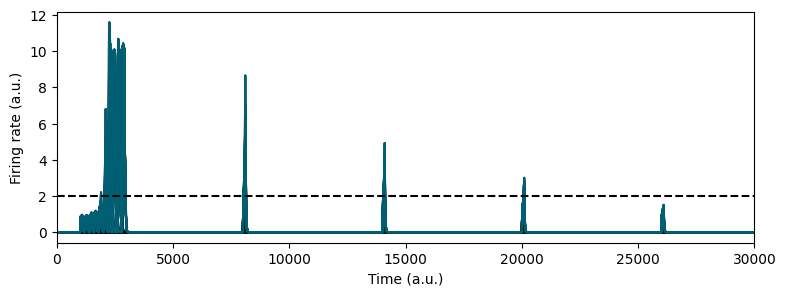

In [19]:
plt.figure(figsize = (9,3))
for n in range(N):
    plt.plot(r[n,:],color = color[0])   
for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[1])
for n in np.where(np.logical_and(TAG>3000,TAG<6000))[0]:
    plt.plot(r[n,:],color = color[8])
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim([0,30000])
plt.xlabel('Time (a.u.)')
plt.ylabel('Firing rate (a.u.)')
plt.savefig('fr2.png',dpi=500,bbox_inches='tight' )

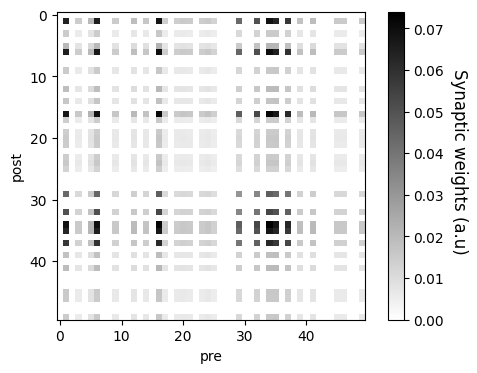

In [20]:
W = np.reshape(y[index[1][:],:],(N,N,nstep))
plt.figure(figsize = (6,4))
plt.imshow(W[:,:,-1], cmap = 'binary')
plt.xlabel('pre')
plt.ylabel('post')
cbar = plt.colorbar()
cbar.ax.set_title('Synaptic weights (a.u)', rotation=270,loc='left',y=.2,x=4)
plt.savefig('weightsf.png',dpi=500,bbox_inches='tight' )

## loop

In [21]:
threshold = 2
threshold_alpha = 2

seed = 0
[0, 2]


/tmp/ipykernel_11743/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


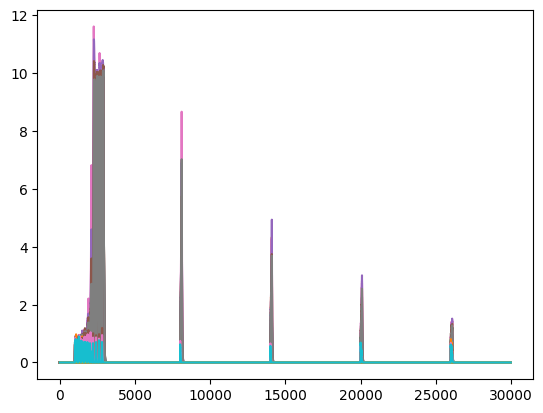

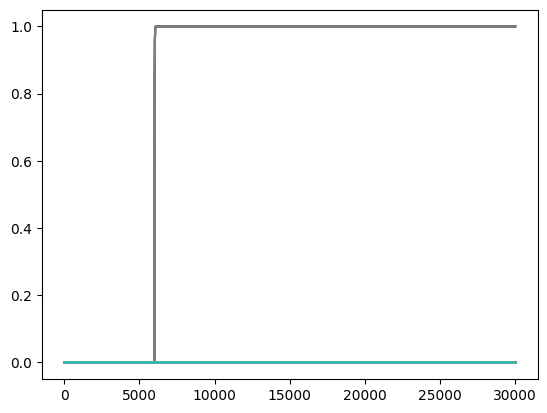

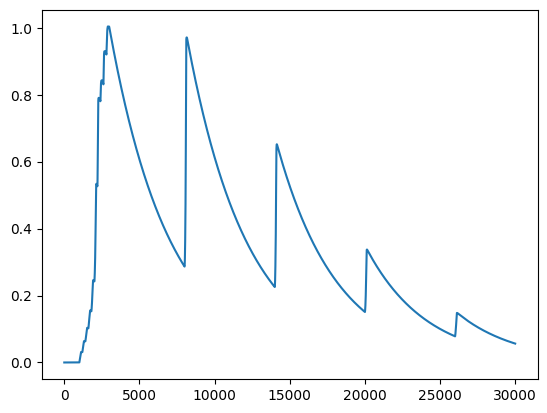

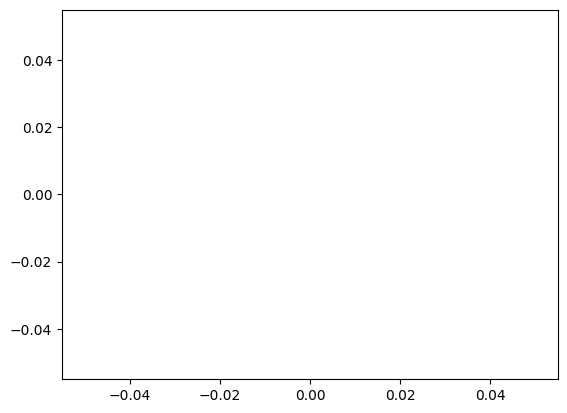

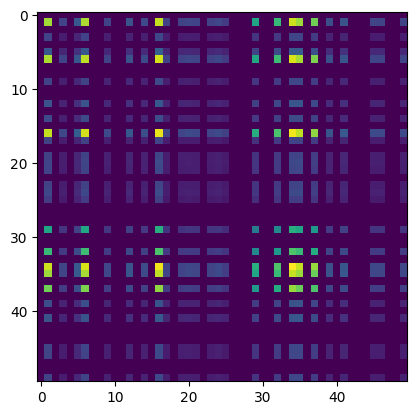

In [ ]:
scaleE = 0
scaleW = 0
Nseed = 1
Ns = 1

weights_A = np.zeros((Nseed,Ns,nstep))
rates_A = np.zeros((Nseed,Ns,nstep))
priming_A = np.zeros((Nseed,Ns,nstep))

weights_B = np.zeros((Nseed,Ns,nstep))
rates_B = np.zeros((Nseed,Ns,nstep))
priming_B = np.zeros((Nseed,Ns,nstep))

rates = np.zeros((Nseed,Ns,N,nstep))

encod_A = np.zeros((Nseed,Ns,N))
encod_B = np.zeros((Nseed,Ns,N))
recall_A = np.zeros((Nseed,Ns,N))
recall_B = np.zeros((Nseed,Ns,N))


for seed in range(Nseed):
#for seed in [4]:
    
    np.random.seed(seed)
    random.seed(seed)
    print('seed = '+str(seed))
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    #ctxB = np.zeros(N)
    #ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
    #ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    
    #for scaleE in [0,1]:
    #    for scaleW in [0]:
    #        for threshold_alpha in [0,2]:
                

                
        #for I0b in [9.5,10,10.5]:
        #for scaleW in [0,2,5]:
            # run
    print([scaleE,threshold_alpha])
    y = run(INPUT)
    #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
    TAG_A = TAG * (TAG < 3000)
    TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

    weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
    rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
    priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

    weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
    rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
    priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

    #rates[seed,scenario,:,:] = y[index[0]]

    encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
    encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
    recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
    recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

    #n = 3
    #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
    #rates[seed,scenario,:] = y[index[0][n],:]
    #priming[seed,scenario,:] = y[index[3][n],:]

    overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
    overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
    #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
    #print(overlap_encod)
    #print(overlap_recall)
    #plt.show()

    #n = np.where(TAG != 0)[0][0]

    if seed == 0:

        for n in range(N):
            rate = y[index[0][n],:]
            plt.plot(rate)
        plt.show()


        for n in range(N):
            alpha = y[index[3][n],:]
            plt.plot(alpha)
        plt.show()

        plt.plot(weights_A[seed,scenario,:])
        plt.show()

        plt.plot(weights_B[seed,scenario,:])
        plt.show()

        plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
        plt.show()

    if seed == 0:
        plot_all()
        plt.show()
    scenario +=1 


### figure

In [ ]:
np.shape(weights_A)

In [ ]:
plt.plot(np.mean(weights_A[:,0,:],axis = 0), color = color[0])
for seed in range(Nseed):
    plt.plot(weights_A[seed,0,:], color = 'k', alpha = 1/Nseed)
plt.xlabel('Time (a.u.)')
plt.ylabel('Averaged synaptic weights of tagged neurons')

## loop

In [1017]:
delayL = np.arange(1000,5100,100)
R = np.load('results_delay.npy')
print(np.shape(R))
Wf = R[:,:,4]
#rates_A = R[:,:,1]
Nseed = 10

(41, 10, 10)


In [1018]:
np.mean(np.mean(R, axis = 1),axis = 1)

array([5.44194455, 5.44032913, 5.43416034, 5.43455364, 5.4340972 ,
       5.44087905, 5.4352444 , 5.43723764, 5.44106429, 5.43358883,
       5.4285924 , 5.43183975, 5.42288057, 5.38964978, 5.32384333,
       5.08146461, 4.62502939, 4.05527655, 3.50731015, 3.06898446,
       2.72088107, 2.42429993, 2.19703737, 2.02440803, 1.89564021,
       1.80800312, 1.74617824, 1.69549147, 1.66351743, 1.62027103,
       1.59723358, 1.56850917, 1.5434703 , 1.52649148, 1.50745445,
       1.48901282, 1.47690047, 1.46484093, 1.45298645, 1.44111171,
       1.42740414])

In [1019]:
np.shape(Wf)

(41, 10)

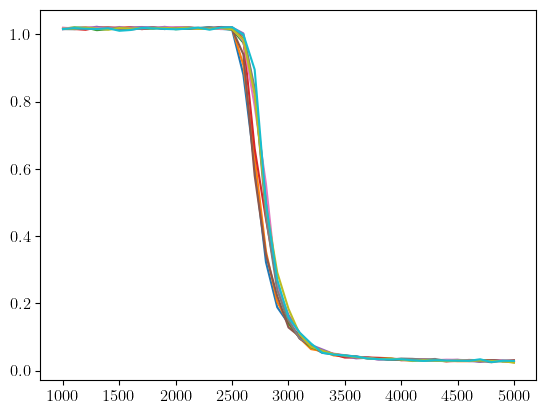

In [1020]:
for seed in range(Nseed):
    plt.plot(delayL,Wf[:,seed])

In [ ]:
plt.plot(np.mean(weights_A[:,:,-1],axis = 0))

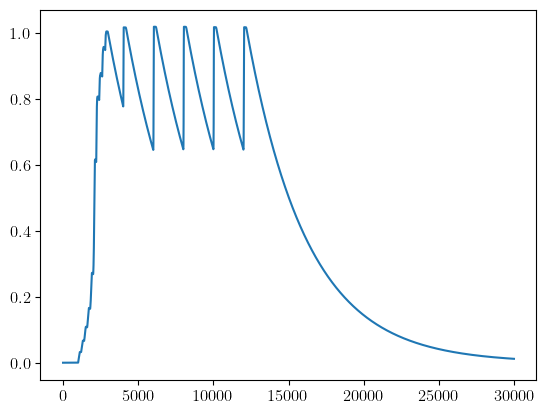

In [953]:
plt.plot(np.mean(weights_A[:,2,:],axis = 0))

## Protocol 2 memories

In [509]:
seq = []
nstep = 30000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000


seqA = []
seqB = []
Nevent = 5

for i in range(Nstim):
    seqA.append(pause + i*stim)
    seqA.append(pause + i*stim + duration)

for i in range(Nstim):
    seqB.append(pause + i*stim + delay)
    seqB.append(pause + i*stim + delay + duration)

    
for ev in range(1,Nevent+1):

        seqA.append(pause*2 + 2*delay*ev)
        seqA.append(pause*2 + duration + 2*delay*ev)
        
        seqB.append(pause*2 + delay + 2*delay*ev)
        seqB.append(pause*2 + duration + delay + 2*delay*ev)
        

base = 0
def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return (IN-base) * ctx * L/2 + base


In [510]:
PA = np.zeros((N,nstep))
for t in range(nstep):
    PA[:,t] = INPUT(t,ctxA,seqA)
    
PB = np.zeros((N,nstep))
for t in range(nstep):
    PB[:,t] = INPUT(t,ctxB,seqB)

In [511]:
#plt.imshow(PA,aspect = 100)
#plt.colorbar()

In [512]:
#plt.imshow(PB,aspect = 100)

## Parameters

In [513]:
## ok
threshold = 2
threshold_alpha = 2

decayL = [4000]
tauwL = [1500]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [0]
y0L = [2]
sigmaL = [1]
INL = [16]
seedL = range(10)

tau_alpha_up = 10
tau_alpha_down = tau_alpha_up

delay_alpha = 100
delay_alpha_2 = 10000000

tauE = 1
scaleE = 0#1
scaleW = 0#1
 
overlap = 5/100

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


## Run

In [309]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)
for I0 in I0L:
    for IN in INL:
        print([I0,IN])
         # initialisation
        
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        alpha0 = np.zeros(N)

        ctxA = np.zeros(N)
        ctxA[:int(N/2)] = 1
        random.shuffle(ctxA)
        #ctxB = np.zeros(N)
        #ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
        #ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
        ov = np.arange(0,N)
        random.shuffle(ov)
        ctxB = 1 - ctxA
        for n in ov[:int(overlap*N)]:
            ctxB[n] = ctxA[n]

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]


        #plot_all()
        #plt.savefig('all.png',dpi=500,bbox_inches='tight' )
        #plt.show()

0
[8, 16]


### figure

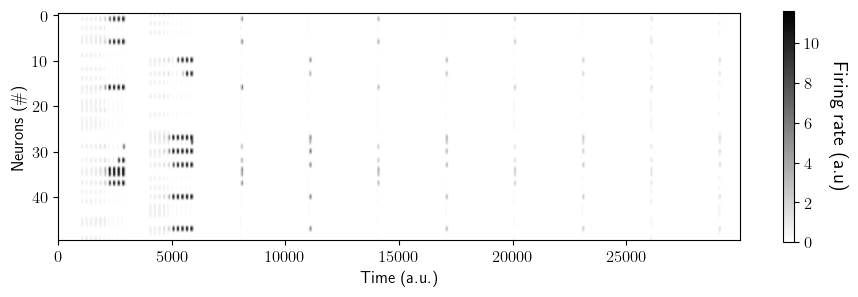

In [310]:
plt.figure(figsize = (11,3))
plt.imshow(r,aspect = 200, cmap = 'binary')
plt.xlabel('Time (a.u.)')
plt.ylabel('Neurons (\#)')
cbar = plt.colorbar()
cbar.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.2,x=4)
plt.savefig('fr1.png',dpi=500,bbox_inches='tight' )

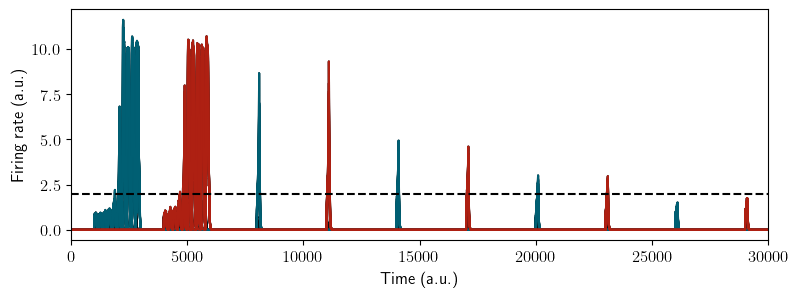

In [311]:
plt.figure(figsize = (9,3))
for n in range(N):
    plt.plot(r[n,:],color = color[0])   
for n in np.where(np.logical_and(TAG>0,TAG<3000))[0]:
    plt.plot(r[n,:],color = color[1])
for n in np.where(np.logical_and(TAG>3000,TAG<6000))[0]:
    plt.plot(r[n,:],color = color[8])
plt.axhline(threshold,color='k',linestyle = '--')
plt.xlim([0,30000])
plt.xlabel('Time (a.u.)')
plt.ylabel('Firing rate (a.u.)')
plt.savefig('fr2.png',dpi=500,bbox_inches='tight' )

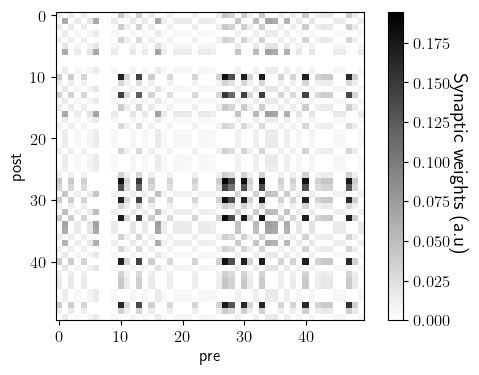

In [312]:
W = np.reshape(y[index[1][:],:],(N,N,nstep))
plt.figure(figsize = (6,4))
plt.imshow(W[:,:,-1], cmap = 'binary')
plt.xlabel('pre')
plt.ylabel('post')
cbar = plt.colorbar()
cbar.ax.set_title('Synaptic weights (a.u)', rotation=270,loc='left',y=.2,x=4)
plt.savefig('weightsf.png',dpi=500,bbox_inches='tight' )

In [129]:
seqB

[4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 11000,
 11100,
 17000,
 17100,
 23000,
 23100,
 29000,
 29100,
 35000,
 35100]

## loop

In [313]:
threshold = 2
threshold_alpha = 2

In [603]:
scaleE = 0
scaleW = 0
Nseed = 10

weights_A = np.zeros((Nseed,4,nstep))
rates_A = np.zeros((Nseed,4,nstep))
priming_A = np.zeros((Nseed,4,nstep))

weights_B = np.zeros((Nseed,4,nstep))
rates_B = np.zeros((Nseed,4,nstep))
priming_B = np.zeros((Nseed,4,nstep))

rates = np.zeros((Nseed,4,N,nstep))

encod_A = np.zeros((Nseed,4,N))
encod_B = np.zeros((Nseed,4,N))
recall_A = np.zeros((Nseed,4,N))
recall_B = np.zeros((Nseed,4,N))


for seed in range(Nseed):
#for seed in [4]:
    
    np.random.seed(seed)
    random.seed(seed)
    print('seed = '+str(seed))
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    #ctxB = np.zeros(N)
    #ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
    #ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    
    #for scaleE in [0,1]:
    #    for scaleW in [0]:
    #        for threshold_alpha in [0,2]:
                
    for scaleE in [.5]:
        for scaleW in [0]:
            for threshold_alpha in [0,2]:
                
        #for I0b in [9.5,10,10.5]:
        #for scaleW in [0,2,5]:
            # run
                print([scaleE,threshold_alpha])
                y = run(INPUT)
                #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
                TAG_A = TAG * (TAG < 3000)
                TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

                weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
                rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
                priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

                weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
                rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
                priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

                #rates[seed,scenario,:,:] = y[index[0]]

                encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
                encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
                recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
                recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

                #n = 3
                #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
                #rates[seed,scenario,:] = y[index[0][n],:]
                #priming[seed,scenario,:] = y[index[3][n],:]

                overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
                overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
                print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
                print(overlap_encod)
                print(overlap_recall)
                #plt.show()

                #n = np.where(TAG != 0)[0][0]

                if seed == 990:

                    for n in range(N):
                        rate = y[index[0][n],:]
                        plt.plot(rate)
                    plt.show()


                    for n in range(N):
                        alpha = y[index[3][n],:]
                        plt.plot(alpha)
                    plt.show()

                    plt.plot(weights_A[seed,scenario,:])
                    plt.show()

                    plt.plot(weights_B[seed,scenario,:])
                    plt.show()

                    plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
                    plt.show()
                    
                if seed == 4:
                    plot_all()
                    plt.show()
                scenario +=1 


seed = 0
[0.5, 0]
[8.0, 8.0, 6.0, 8.0]
0
0
[0.5, 2]


KeyboardInterrupt: 

In [ ]:
size_encod_A = np.sum(encod_A[:,:,:],axis = 2)
size_encod_B = np.sum(encod_B[:,:,:],axis = 2)
size_recall_A = np.sum(recall_A[:,:,:],axis = 2)
size_recall_B = np.sum(recall_B[:,:,:],axis = 2)


for scenario in [0,1,2,3]:
    plt.errorbar(np.array([0,1,2,3]) + scenario/20,[np.mean(size_encod_A[:,scenario]),
                              np.mean(size_encod_B[:,scenario]),
                              np.mean(size_recall_A[:,scenario]),
                              np.mean(size_recall_B[:,scenario])],
                             [stats.sem(size_encod_A[:,scenario]),
                              stats.sem(size_encod_B[:,scenario]),
                              stats.sem(size_recall_A[:,scenario]),
                              stats.sem(size_recall_B[:,scenario])],marker = 'o', linestyle='None', color = color[scenario*2])

#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0,1,2,3],['Encod. A','Encod. B','Recall A','Recall B']);
plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
plt.text(0,1,'E = 2, threshold = 0', color = color[4])
plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('size.png',dpi = 500)

/tmp/ipykernel_336692/918361557.py:1: RuntimeWarning: invalid value encountered in true_divide
  overlap_encod  = 100 * np.divide(np.sum(np.logical_and(encod_A, encod_B),axis = 2), size_encod_A)
/tmp/ipykernel_336692/918361557.py:2: RuntimeWarning: invalid value encountered in true_divide
  overlap_recall = 100 * np.divide(np.sum(np.logical_and(recall_A, recall_B),axis = 2), size_recall_A)


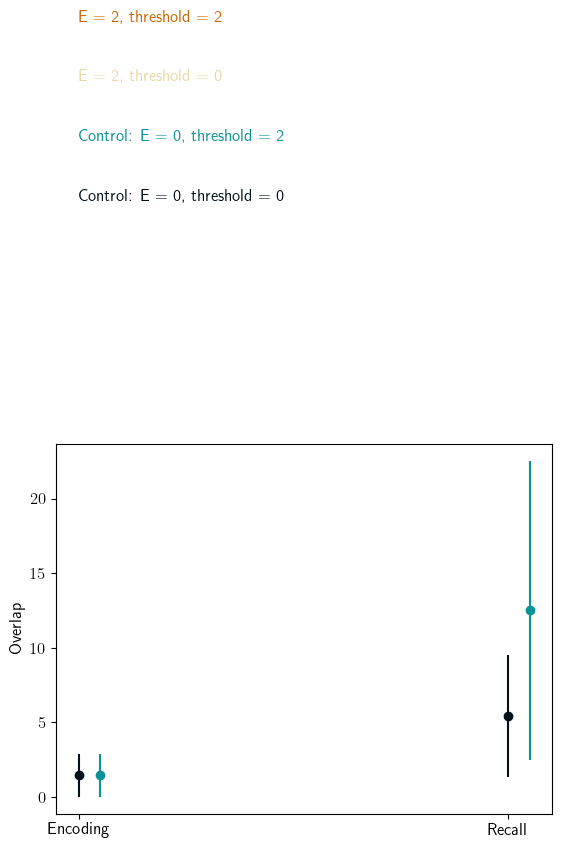

In [298]:
overlap_encod  = 100 * np.divide(np.sum(np.logical_and(encod_A, encod_B),axis = 2), size_encod_A)
overlap_recall = 100 * np.divide(np.sum(np.logical_and(recall_A, recall_B),axis = 2), size_recall_A)

#overlap_encod  = np.sum(np.logical_and(encod_A, encod_B),axis = 2)
#overlap_recall = np.sum(np.logical_and(recall_A, recall_B),axis = 2)


for scenario in [0,1,2,3]:
    plt.errorbar(np.array([0,1])+scenario/20,[np.mean(overlap_encod[:,scenario]),
                        np.mean(overlap_recall[:,scenario])],
                       [stats.sem(overlap_encod[:,scenario]),
                        stats.sem(overlap_recall[:,scenario])], color = color[scenario*2],marker = 'o', linestyle='None')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(0,40,'Control: E = 0, threshold = 0', color = color[0])
plt.text(0,44,'Control: E = 0, threshold = 2', color = color[2])
plt.text(0,48,'E = 2, threshold = 0', color = color[4])
plt.text(0,52,'E = 2, threshold = 2', color = color[6])
#for scenario in [0,1,2,3]:
##    for seed in range(Nseed):
 #       plt.plot([0,1],[overlap_encod[seed,scenario],
 #                           overlap_recall[seed,scenario]], 'k', alpha = .1)
#fo
plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.savefig('overlap.png',dpi = 500)

## Priming before, allocation

In [514]:
scaleE = 0

In [515]:
primed_before = True

In [516]:
# main function
def f(yt,t,dt):
    global TAG
    global TAG_r
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc = yt[index[2]][np.newaxis].T
    alpha = yt[index[3]][np.newaxis].T
    tag = yt[index[4]][np.newaxis].T

    if t == 0:
        np.random.seed(seed)
        
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0) 
        
    exc = exc0[np.newaxis].T + (r >= threshold_alpha) * scaleE*alpha

    dalphadt = np.zeros(N)[np.newaxis].T

    if primed_before:
        dalphadt[:int(N/2)] += (t<6000)*(1 - alpha[:int(N/2)])  / tau_alpha_up 
        dalphadt[:int(N/2)] += (t>6000)*(t<8000)*(0 - alpha[:int(N/2)])  / tau_alpha_up 
    
    dalphadt += (t>6000)*(TAG!=0) * (1 - alpha) * (t > TAG + delay_alpha) * (t < TAG + delay_alpha + delay_alpha_2) / tau_alpha_up 
    dalphadt += (TAG!=0) * (0 - alpha) * (t > TAG + delay_alpha + delay_alpha_2) / tau_alpha_down
    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc  ) )/taur
    
    #dWdt = r.dot(r.T) / tauw - W/decay

    dWdt = (1 + scaleW * alpha) * (r >= threshold_alpha) * r.dot(r.T) / tauw  + (r < threshold_alpha) * r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
      
 

    # excitability
    exc = yt[index[2]][np.newaxis].T
    dexcdt = np.zeros(N)
    dexcdt = (r >= threshold_alpha) * (scaleE*alpha - exc + exc0[np.newaxis].T) / tauE + (r < threshold_alpha) * (exc0[np.newaxis].T - exc) / tauE 
    TAG = TAG + (r >= threshold) * (TAG == 0) * t

    if t > 25000:
        TAG_r = TAG_r + (r >= threshold) * (TAG_r == 0) * t
        
    dtagdt = np.zeros(N)
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dalphadt.flatten(),
                           dtagdt.flatten()))

    return dydt

0


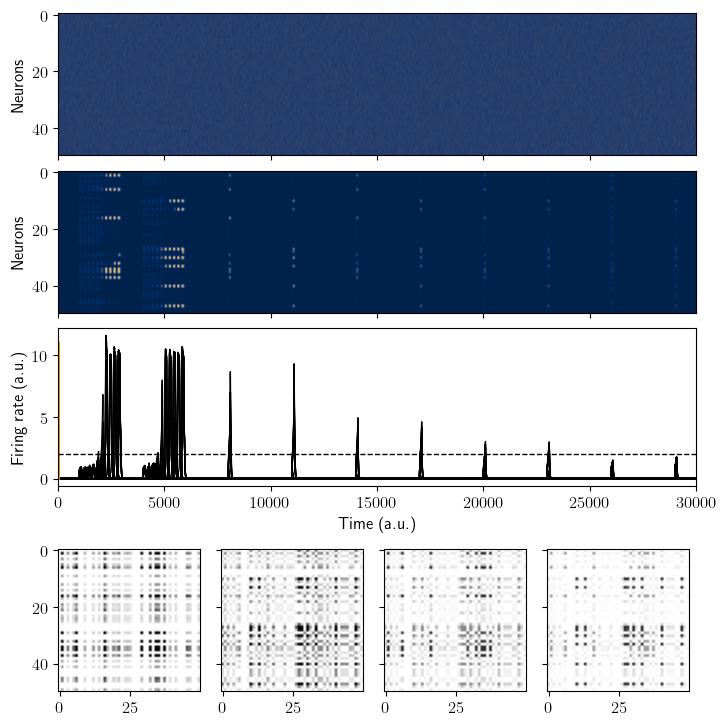

In [517]:
seed = 0
print(seed)
pc = False
np.random.seed(seed)
random.seed(seed)
# initialisation

r0 = np.zeros(N)
W0 = np.zeros(N*N)
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)
#exc0 = np.random.uniform(0,sigma,N)
alpha0 = np.zeros(N)

ctxA = np.zeros(N)
ctxA[:int(N/2)] = 1
random.shuffle(ctxA)
#ctxB = np.zeros(N)
#ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
#ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
ov = np.arange(0,N)
random.shuffle(ov)
ctxB = 1 - ctxA
for n in ov[:int(overlap*N)]:
    ctxB[n] = ctxA[n]



# run
y = run(INPUT)
exc = y[index[2][:],:]
r = y[index[0][:],:]
alpha = y[index[3][:],:]


plot_all()
#plt.savefig('all.png',dpi=500,bbox_inches='tight' )
plt.show()

In [518]:
alpha = y[index[3][:],:]

In [519]:
np.shape(alpha)

(50, 30000)

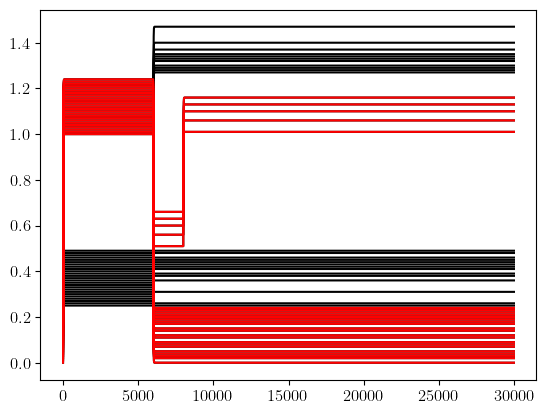

In [520]:
for n in range(N):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'k')

for n in range(int(N/2)):
    alpha = y[index[3][n],:]+n/100
    plt.plot(alpha, 'r')
plt.show()

### loop

In [525]:
scaleE = 0
scaleW = 0
Nseed = 10

weights_A = np.zeros((Nseed,4,nstep))
rates_A = np.zeros((Nseed,4,nstep))
priming_A = np.zeros((Nseed,4,nstep))

weights_B = np.zeros((Nseed,4,nstep))
rates_B = np.zeros((Nseed,4,nstep))
priming_B = np.zeros((Nseed,4,nstep))

rates = np.zeros((Nseed,4,N,nstep))

encod_A = np.zeros((Nseed,4,N))
encod_B = np.zeros((Nseed,4,N))
recall_A = np.zeros((Nseed,4,N))
recall_B = np.zeros((Nseed,4,N))
test = np.zeros((4,Nseed))

for seed in range(Nseed):
#for seed in [1]:
    
    np.random.seed(seed)
    random.seed(seed+2*Nseed)
    print('seed = '+str(seed))
    
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    alpha0 = np.zeros(N)
    

    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    
    #ctxB = np.zeros(N)
    #ctxB[:int(overlap*N)] = ctxA[:int(overlap*N)]
    #ctxB[int(overlap*N):] = 1 - ctxA[int(overlap*N):]
    
    ov = np.arange(0,N)
    random.shuffle(ov)
    ctxB = 1 - ctxA
    for n in ov[:int(overlap*N)]:
        ctxB[n] = ctxA[n]

    scenario = 0
    test[:,seed] = np.array([sum(ctxA[:int(N/2)]),sum(ctxA[int(N/2):]),sum(ctxB[:int(N/2)]),sum(ctxB[int(N/2):])])
    for scaleE in [1]:
        for scaleW in [0]:
            for threshold_alpha in [0,2]:
   # for scaleE in [0]:
    #    for scaleW in [0]:
    #        for threshold_alpha in [0]:
        #for I0b in [9.5,10,10.5]:
        #for scaleW in [0,2,5]:
            # run
                print([scaleE,threshold_alpha])
                y = run(INPUT)
                #weights[seed,scenario,:] = np.mean([y[index[1][n],:] for n in np.where(TAG != 0)[0]], axis = 0)
                TAG_A = TAG * (TAG < 3000)
                TAG_B = TAG * (np.logical_and(TAG > 3000, TAG < 6000))

                weights_A[seed,scenario,:] = get_weights_TAG_avg(y,TAG_A)
                rates_A[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)
                priming_A[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_A != 0)[0]], axis = 0)      

                weights_B[seed,scenario,:] = get_weights_TAG_avg(y,TAG_B)
                rates_B[seed,scenario,:] = np.mean([y[index[0][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)
                priming_B[seed,scenario,:] = np.mean([y[index[3][n],:] for n in np.where(TAG_B != 0)[0]], axis = 0)      

                #rates[seed,scenario,:,:] = y[index[0]]

                encod_A[seed,scenario,:] = np.sum(y[index[0],:3000] > threshold,1)>0
                encod_B[seed,scenario,:] = np.sum(y[index[0],3000:6000] > threshold,1)>0
                recall_A[seed,scenario,:] = np.sum(y[index[0],26000:26100] > threshold,1)>0
                recall_B[seed,scenario,:] = np.sum(y[index[0],29000:29100] > threshold,1)>0

                #n = 3
                #weights[seed,scenario,:] = y[index[1][:],:].reshape((N,N,nstep))[n,n,:]
                #rates[seed,scenario,:] = y[index[0][n],:]
                #priming[seed,scenario,:] = y[index[3][n],:]

                overlap_encod = np.sum(np.logical_and(encod_A[seed,scenario,:], encod_B[seed,scenario,:]))
                overlap_recall = np.sum(np.logical_and(recall_A[seed,scenario,:], recall_B[seed,scenario,:]))
                #print([np.sum(encod_A[seed,scenario,:]), np.sum(encod_B[seed,scenario,:]), np.sum(recall_A[seed,scenario,:]), np.sum(recall_B[seed,scenario,:])])
                #print(overlap_encod)
                #print(overlap_recall)
                #plt.show()

                #n = np.where(TAG != 0)[0][0]

                if seed == 990:

                    for n in range(N):
                        rate = y[index[0][n],:]
                        plt.plot(rate)
                    plt.show()


                    for n in range(N):
                        alpha = y[index[3][n],:]+n/100
                        plt.plot(alpha, 'k')
                        
                    for n in range(int(N/2)):
                        alpha = y[index[3][n],:]+n/100
                        plt.plot(alpha, 'r')
                    plt.show()

                    plt.plot(weights_A[seed,scenario,:])
                    plt.show()

                    plt.plot(weights_B[seed,scenario,:])
                    plt.show()

                    plt.imshow(y[index[1][:],:].reshape((N,N,nstep))[:,:,-1])
                    plt.show()
                    
                if seed == 990:
                    plot_all()
                    plt.show()
                scenario +=1 


seed = 0
[1, 0]


/tmp/ipykernel_359609/2420268201.py:8: RuntimeWarning: invalid value encountered in true_divide
  weights_TAG_avg =  weights_TAG_avg / len(TAG_list)
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gyd21/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1, 2]
seed = 1
[1, 0]
[1, 2]
seed = 2
[1, 0]
[1, 2]
seed = 3
[1, 0]
[1, 2]
seed = 4
[1, 0]
[1, 2]
seed = 5
[1, 0]
[1, 2]
seed = 6
[1, 0]
[1, 2]
seed = 7
[1, 0]
[1, 2]
seed = 8
[1, 0]
[1, 2]
seed = 9
[1, 0]
[1, 2]


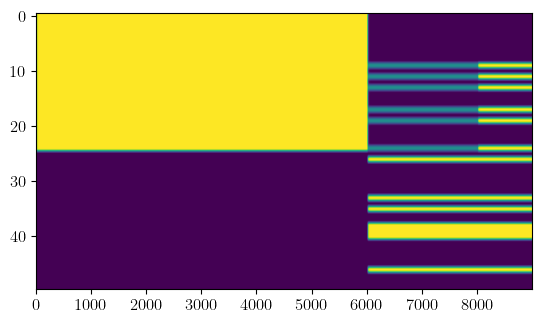

In [522]:
plt.imshow(y[index[3][:],:9000],aspect = 100)

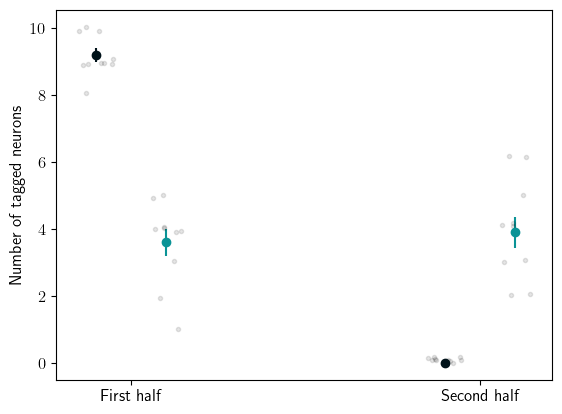

In [526]:
first =  np.sum(encod_A[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_A[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
#plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

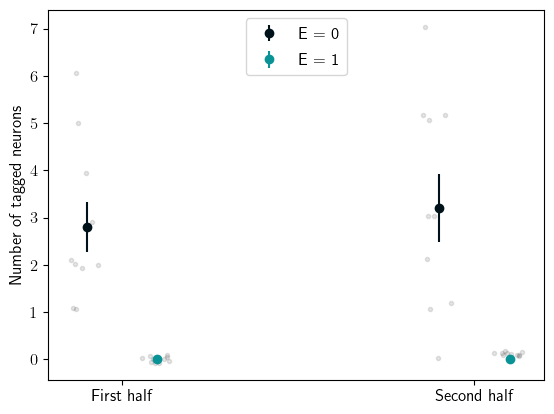

In [524]:
first =  np.sum(encod_B[:,:,:int(N/2)],axis = 2)
second = np.sum(encod_B[:,:,int(N/2):],axis = 2)

for scenario in [0,1]:
    plt.errorbar([0+scenario/5,1+scenario/5],[np.mean(first[:,scenario]),
                          np.mean(second[:,scenario]),
                          ],
                         [stats.sem(first[:,scenario]),
                          stats.sem(second[:,scenario]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*scenario])
plt.legend(['E = 0', 'E = 1'], loc='upper center')

for scenario in [0,1]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+scenario/5+random.random()/10-.05,[first[seed,scenario]+random.random()/5-.1,
                              second[seed,scenario]+random.random()/5],marker = '.', linestyle='None', color = 'k', alpha = .1)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+1/10,1+1/10],['First half','Second half']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

### Loop python half primed

In [297]:
R = np.load('results_allocation.npy')
scaleEL = np.arange(0,2,.5)
Nseed = 1000

In [298]:
firstA = R[:,:,0]
secondA = R[:,:,1]
firstB = R[:,:,2]
secondB = R[:,:,3]

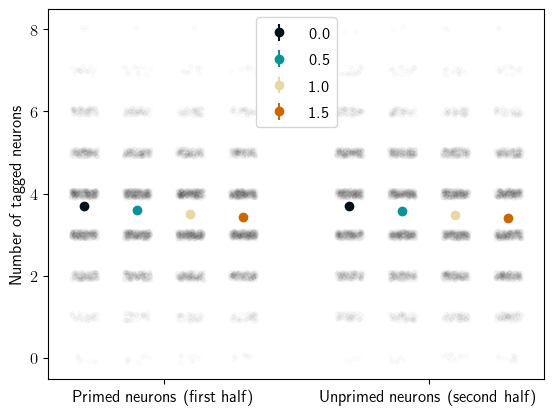

In [299]:
first = firstA
second = secondA

for e in [0,1,2,3]:
    plt.errorbar([0+e/5,1+e/5],[np.mean(first[e,:]),
                          np.mean(second[e,:]),
                          ],
                         [stats.sem(first[e,:]),
                          stats.sem(second[e,:]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*e])
plt.legend(scaleEL, loc='upper center')

for e in [0,1,2,3]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+e/5+random.random()/10-.05,
                 [first[e,seed]+random.random()/5-.1,
                              second[e,seed]+random.random()/5-.1],marker = '.', linestyle='None', color = 'k', alpha = .01)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+3/10,1+3/10],['Primed neurons (first half)','Unprimed neurons (second half)']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

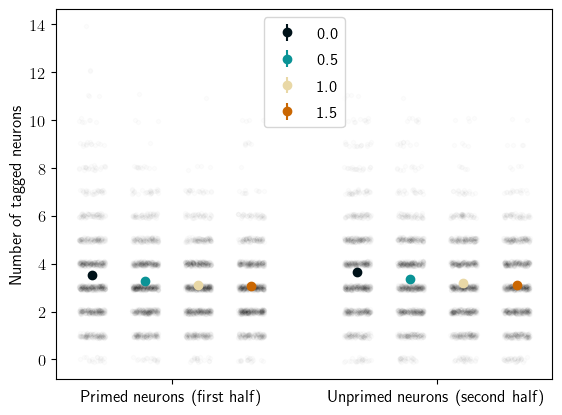

In [300]:
first = firstB
second = secondB

for e in [0,1,2,3]:
    plt.errorbar([0+e/5,1+e/5],[np.mean(first[e,:]),
                          np.mean(second[e,:]),
                          ],
                         [stats.sem(first[e,:]),
                          stats.sem(second[e,:]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*e])
plt.legend(scaleEL, loc='upper center')

for e in [0,1,2,3]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+e/5+random.random()/10-.05,[first[e,seed]+random.random()/5-.1,
                              second[e,seed]+random.random()/5-.1],marker = '.', linestyle='None', color = 'k', alpha = .01)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+3/10,1+3/10],['Primed neurons (first half)','Unprimed neurons (second half)']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

effect of competition of primed neurons: that's why decrease of size with E\
also, bigger range of size with memory B because of overlap: some neurons are similar to A, others are inversted and total is not 50/50

### Loop python quarter primed

In [292]:
R = np.load('results_allocation_quarter.npy')
scaleEL = np.arange(0,2,.5)
Nseed = 1000

In [293]:
firstA = R[:,:,0]
secondA = R[:,:,1]
firstB = R[:,:,2]
secondB = R[:,:,3]

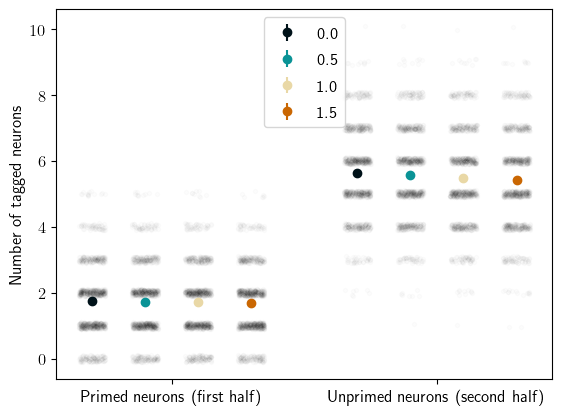

In [294]:
first = firstA
second = secondA

for e in [0,1,2,3]:
    plt.errorbar([0+e/5,1+e/5],[np.mean(first[e,:]),
                          np.mean(second[e,:]),
                          ],
                         [stats.sem(first[e,:]),
                          stats.sem(second[e,:]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*e])
plt.legend(scaleEL, loc='upper center')

for e in [0,1,2,3]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+e/5+random.random()/10-.05,
                 [first[e,seed]+random.random()/5-.1,
                              second[e,seed]+random.random()/5-.1],marker = '.', linestyle='None', color = 'k', alpha = .01)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+3/10,1+3/10],['Primed neurons (first half)','Unprimed neurons (second half)']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

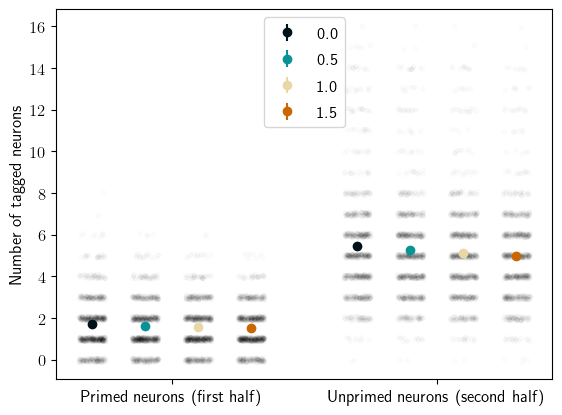

In [295]:
first = firstB
second = secondB

for e in [0,1,2,3]:
    plt.errorbar([0+e/5,1+e/5],[np.mean(first[e,:]),
                          np.mean(second[e,:]),
                          ],
                         [stats.sem(first[e,:]),
                          stats.sem(second[e,:]),
                          ]
                            ,marker = 'o', linestyle='None', color = color[2*e])
plt.legend(scaleEL, loc='upper center')

for e in [0,1,2,3]:
    for seed in range(Nseed):
        plt.plot(np.array([0,1])+e/5+random.random()/10-.05,[first[e,seed]+random.random()/5-.1,
                              second[e,seed]+random.random()/5-.1],marker = '.', linestyle='None', color = 'k', alpha = .01)
    
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0+3/10,1+3/10],['Primed neurons (first half)','Unprimed neurons (second half)']);
plt.ylabel('Number of tagged neurons')

#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_bis.png',dpi = 500)

## Plot upregulate/downregulate

### weights

In [318]:
scaleEL = np.arange(0,1.1,.1)
scaleWL = np.arange(0,0.4,.05)
threshold_alphaL = [0,2]
Nseed = 10

In [319]:
results = np.load('results_weights.npy')
np.shape(results)

(11, 11, 2, 100, 6, 5)

In [320]:
weights_A = results[:,:,:,:,0,:]
rates_A   = results[:,:,:,:,1,:]
priming_A = results[:,:,:,:,2,:]
weights_B = results[:,:,:,:,3,:]
rates_B   = results[:,:,:,:,4,:]
priming_B = results[:,:,:,:,5,:]

In [321]:
down = [0,0]
control = [2,2]
up =[4,4]

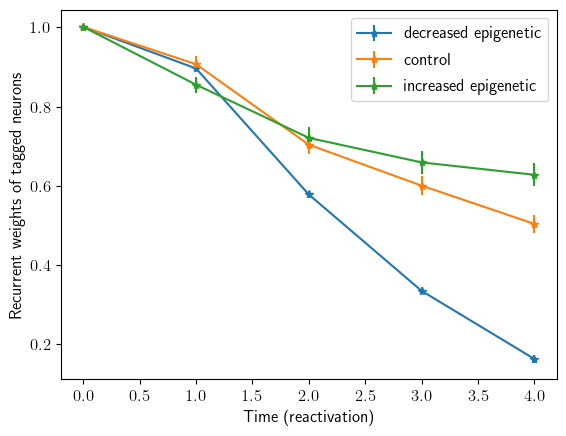

In [322]:
w = 0
th = 1
for [e,w] in [down,control,up]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(weights_A[e,w,th,:,:],axis = 0), stats.sem(weights_A[e,w,th,:,:],axis = 0),marker = '*')
    
plt.legend(scaleEL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Recurrent weights of tagged neurons')

plt.legend(['decreased epigenetic', 'control', 'increased epigenetic'])
plt.savefig('loop.png',dpi=500,bbox_inches='tight' )

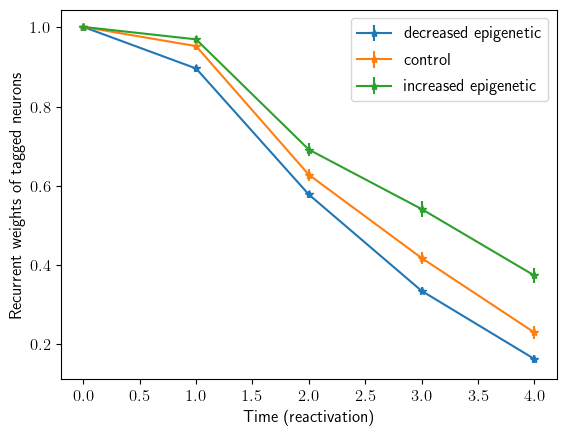

In [323]:
e = 0
th = 1
for w in [0,1,2]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(weights_A[e,w,th,:,:],axis = 0), stats.sem(weights_A[e,w,th,:,:],axis = 0),marker = '*')

plt.legend(scaleWL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Recurrent weights of tagged neurons')
plt.legend(['decreased epigenetic', 'control', 'increased epigenetic'])
plt.savefig('loop.png',dpi=500,bbox_inches='tight' )

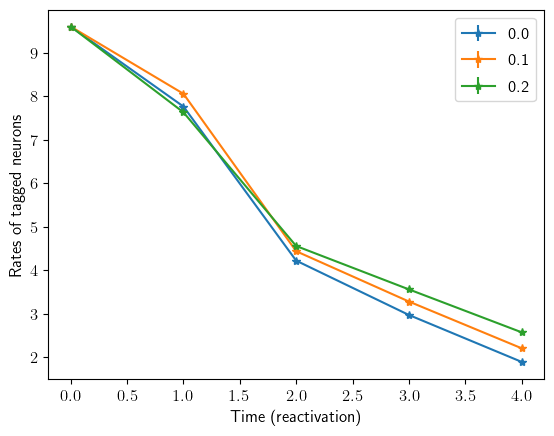

In [324]:
w = 1
th = 1
for e in [0,1,2]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(rates_A[e,w,th,:,:],axis = 0), stats.sem(weights_A[e,w,th,:,:],axis = 0),marker = '*')
    
plt.legend(scaleEL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Rates of tagged neurons')
plt.savefig('loop.png',dpi=500,bbox_inches='tight' )

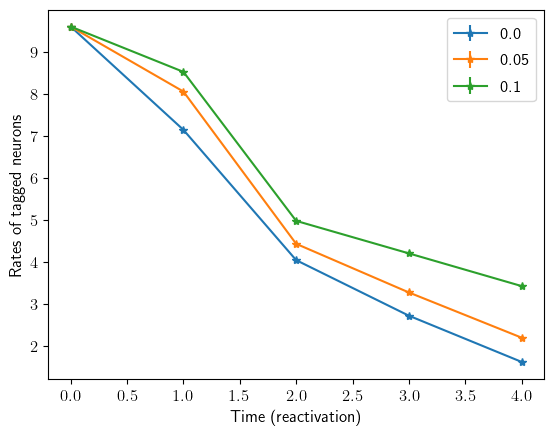

In [325]:
e = 1
th = 1
for w in [0,1,2]:
    plt.errorbar(np.array([0,1,2,3,4]), np.mean(rates_A[e,w,th,:,:],axis = 0), stats.sem(weights_A[e,w,th,:,:],axis = 0),marker = '*')
    
plt.legend(scaleWL)
plt.xlabel('Time (reactivation)')
plt.ylabel('Rates of tagged neurons')
plt.savefig('loop.png',dpi=500,bbox_inches='tight' )

### overlap

In [428]:
results = np.load('results_overlap_2.npy')
np.shape(results)

(8, 8, 2, 100, 8)

In [429]:
size_encod_A = results[:,:,1,:,0]
size_encod_B = results[:,:,1,:,1]
size_recall_A = results[:,:,1,:,2]
size_recall_B = results[:,:,1,:,3]
overlap_encod = results[:,:,1,:,4]
overlap_recall = results[:,:,1,:,5]

size_encod_A_th0 = results[:,:,0,:,0]
size_encod_B_th0 = results[:,:,0,:,1]
size_recall_A_th0 = results[:,:,0,:,2]
size_recall_B_th0 = results[:,:,0,:,3]
overlap_encod_th0 = results[:,:,0,:,4]
overlap_recall_th0 = results[:,:,0,:,5]

In [430]:
scaleEL = np.arange(0,1.1,.1)
scaleWL = np.arange(0,1.1,.1)
threshold_alphaL = [0,2]
Nseed = 100
down = [8,1]
control = [9,2]
up =[10,3]
print([scaleEL[down[0]], scaleWL[down[1]]])
print([scaleEL[control[0]], scaleWL[control[1]]])
print([scaleEL[up[0]], scaleWL[up[1]]])

[0.8, 0.1]
[0.9, 0.2]
[1.0, 0.30000000000000004]


In [431]:
scaleEL = np.arange(.7,1.05,.05)
scaleWL = np.arange(0,.4,.05)
threshold_alphaL = [0,2]
Nseed = 100
down = [1,1]
control = [4,2]
up =[7,3]
print([scaleEL[control[0]], scaleWL[control[1]]])

[0.9000000000000001, 0.1]


#### vs E and W

In [432]:
[e,w] = control

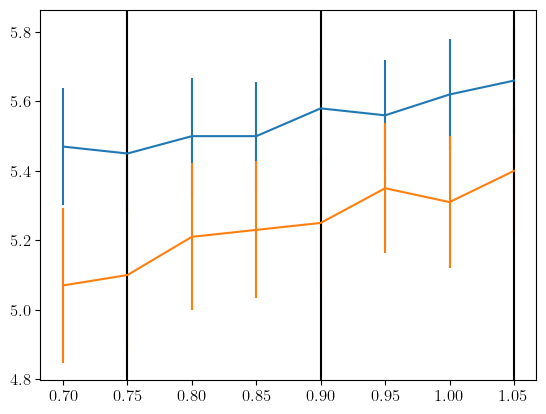

In [426]:
[e,w] = control
plt.errorbar(scaleEL,np.mean(size_recall_A[:,w,:],axis = 1), stats.sem(size_recall_A[:,w,:],axis = 1))
plt.errorbar(scaleEL,np.mean(size_recall_B[:,w,:],axis = 1), stats.sem(size_recall_B[:,w,:],axis = 1))
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')

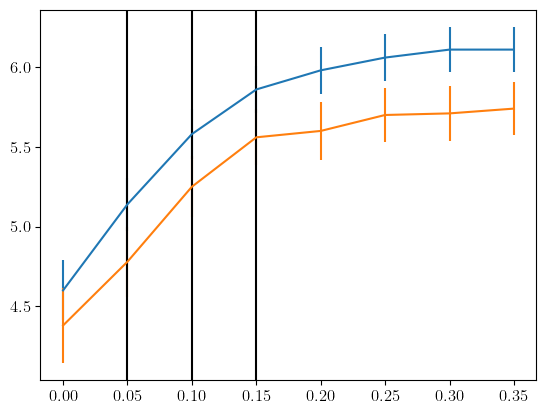

In [427]:
[e,w] = control
plt.errorbar(scaleWL,np.mean(size_recall_A[e,:,:],axis = 1), stats.sem(size_recall_A[e,:,:],axis = 1))
plt.errorbar(scaleWL,np.mean(size_recall_B[e,:,:],axis = 1), stats.sem(size_recall_B[e,:,:],axis = 1))
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

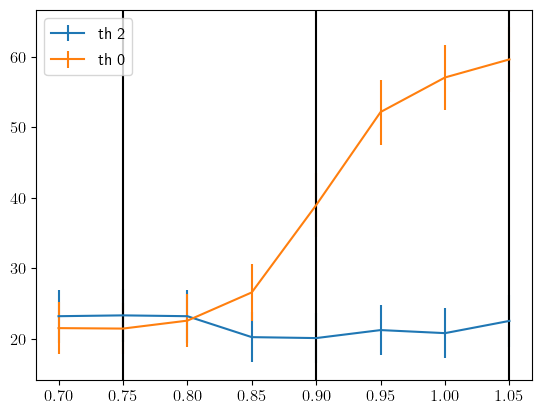

In [379]:
[e,w] = control
plt.errorbar(scaleEL,np.mean(overlap_recall[:,w,:],axis = 1), stats.sem(overlap_recall[:,w,:],axis = 1))
plt.errorbar(scaleEL,np.mean(overlap_recall_th0[:,w,:],axis = 1), stats.sem(overlap_recall_th0[:,w,:],axis = 1))
plt.legend(['th 2','th 0'])
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')


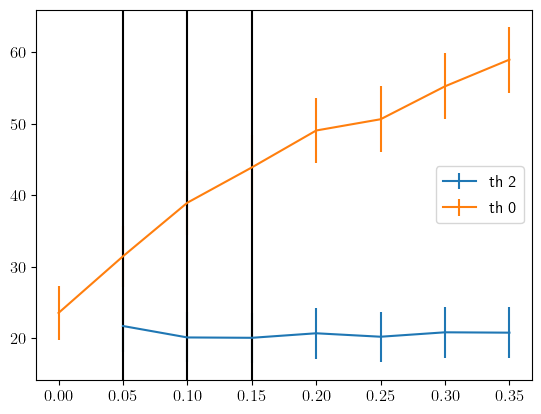

In [380]:
[e,w] = control
plt.errorbar(scaleWL,np.mean(overlap_recall[e,:,:],axis = 1), stats.sem(overlap_recall[e,:,:],axis = 1))
plt.errorbar(scaleWL,np.mean(overlap_recall_th0[e,:,:],axis = 1), stats.sem(overlap_recall_th0[e,:,:],axis = 1))
plt.legend(['th 2','th 0'])
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

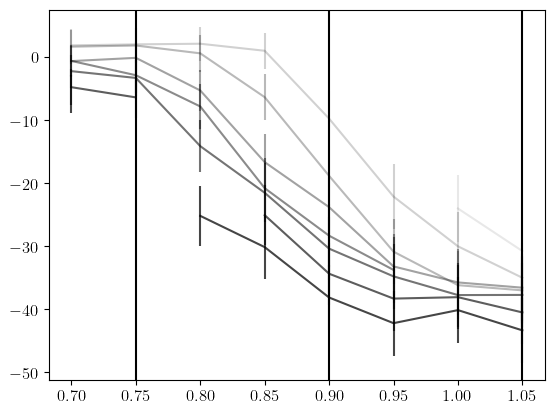

In [381]:
[e,w] = control
for w in range(len(scaleWL)):
    plt.errorbar(scaleEL,np.mean(overlap_recall[:,w,:]-overlap_recall_th0[:,w,:],axis = 1), stats.sem(overlap_recall[:,w,:]-overlap_recall_th0[:,w,:],axis = 1), color = 'k', alpha = (w+1)/11)
plt.axvline(x = scaleEL[down[0]],color = 'k')
plt.axvline(x = scaleEL[control[0]],color = 'k')
plt.axvline(x = scaleEL[up[0]],color = 'k')


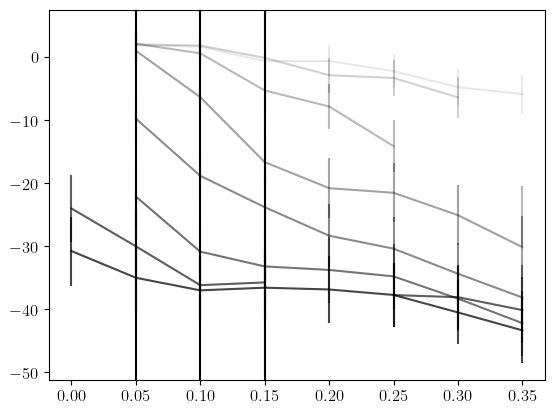

In [382]:
[e,w] = control
for e in range(len(scaleEL)):
    plt.errorbar(scaleWL,np.mean(overlap_recall[e,:,:]-overlap_recall_th0[e,:,:],axis = 1), stats.sem(overlap_recall[e,:,:]-overlap_recall_th0[e,:,:],axis = 1), color = 'k', alpha = (e+1)/11)
plt.axvline(x = scaleWL[down[1]],color = 'k')
plt.axvline(x = scaleWL[control[1]],color = 'k')
plt.axvline(x = scaleWL[up[1]],color = 'k')

#### manipulation

In [383]:
[e,w] = control

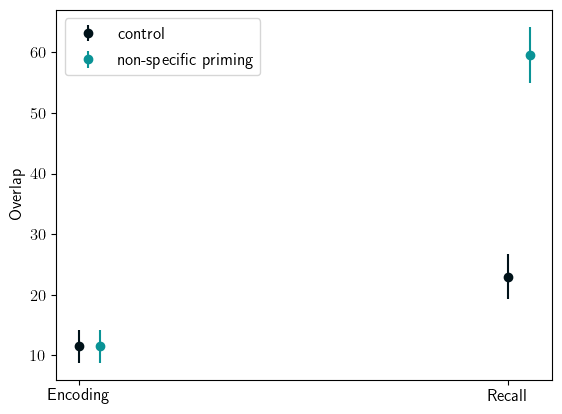

In [386]:
c = 0
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod[e,w,:]),
                        np.mean(overlap_recall[e,w,:])],
                       [stats.sem(overlap_encod[e,w,:]),
                        stats.sem(overlap_recall[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')
c = 1
plt.errorbar(np.array([0,1])+c/20,[np.mean(overlap_encod_th0[e,w,:]),
                        np.mean(overlap_recall_th0[e,w,:])],
                       [stats.sem(overlap_encod_th0[e,w,:]),
                        stats.sem(overlap_recall_th0[e,w,:])], color = color[c*2],marker = 'o', linestyle='None')

plt.legend(['control', 'non-specific priming'])

plt.ylabel('Overlap')
plt.xticks([0,1],['Encoding','Recall']);
plt.savefig('overlap_threshold.png',dpi = 500)

[1, 1]
[4, 2]
[7, 3]


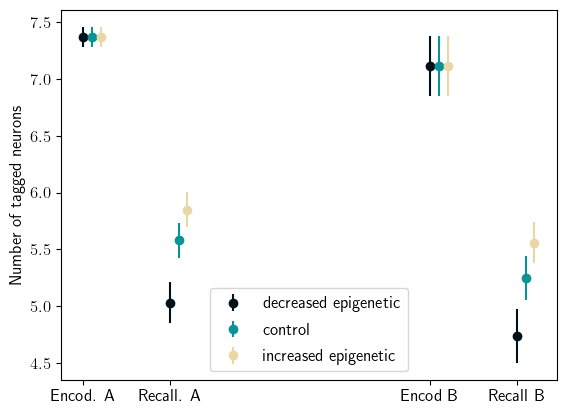

In [387]:
c = 0
for [e,w] in [down,control,up]:
    print([e,w])
    plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A[e,w,:]),
                              np.mean(size_recall_A[e,w,:]),
                              np.mean(size_encod_B[e,w,:]),
                              np.mean(size_recall_B[e,w,:])],
                             [stats.sem(size_encod_A[e,w,:]),
                              stats.sem(size_recall_A[e,w,:]),
                              stats.sem(size_encod_B[e,w,:]),
                              stats.sem(size_recall_B[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])
    c+=1
#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0,.5,2,2.5],['Encod. A','Recall. A','Encod B','Recall B']);
plt.ylabel('Number of tagged neurons')
plt.legend(['decreased epigenetic', 'control', 'increased epigenetic'])

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('size_3C.png',dpi = 500)

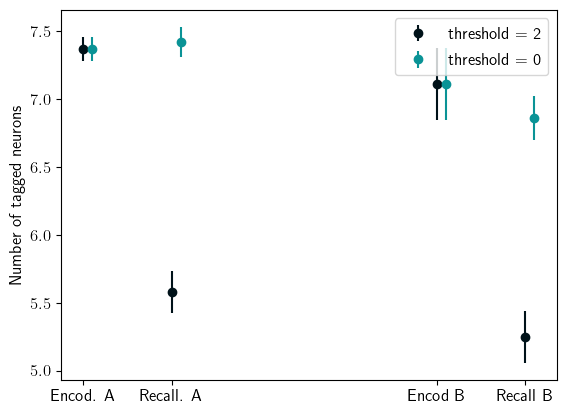

In [ ]:
[e,w] = control
c = 0
plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A[e,w,:]),
                          np.mean(size_recall_A[e,w,:]),
                          np.mean(size_encod_B[e,w,:]),
                          np.mean(size_recall_B[e,w,:])],
                         [stats.sem(size_encod_A[e,w,:]),
                          stats.sem(size_recall_A[e,w,:]),
                          stats.sem(size_encod_B[e,w,:]),
                          stats.sem(size_recall_B[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])

c = 1
plt.errorbar(np.array([0,.5,2,2.5]) + c/20,[np.mean(size_encod_A_th0[e,w,:]),
                          np.mean(size_recall_A_th0[e,w,:]),
                          np.mean(size_encod_B_th0[e,w,:]),
                          np.mean(size_recall_B_th0[e,w,:])],
                         [stats.sem(size_encod_A_th0[e,w,:]),
                          stats.sem(size_recall_A_th0[e,w,:]),
                          stats.sem(size_encod_B_th0[e,w,:]),
                          stats.sem(size_recall_B_th0[e,w,:])],marker = 'o', linestyle='None', color = color[2*c])

#for scenario in [0,1,2,3]:
#    for seed in range(Nseed):
#            plt.plot(np.array([0,1,2,3]) + scenario/15,[size_encod_A[seed,scenario],size_encod_B[seed,scenario],size_recall_A[seed,scenario],size_recall_B[seed,scenario]],marker = '.',linewidth = 0,color = 'k', alpha =.05)
plt.xticks([0,.5,2,2.5],['Encod. A','Recall. A','Encod B','Recall B']);
plt.ylabel('Number of tagged neurons')

plt.legend(['threshold = 2', 'threshold = 0'])
#plt.text(0,0,'Control: E = 0, threshold = 0', color = color[0])
#plt.text(0,.5,'Control: E = 0, threshold = 2', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('size_threshold.png',dpi = 500)

### Loop python half primed

In [347]:
R = np.load('results_allocation.npy')
Nseed = 1000
scaleE,scaleW = .9,.2 # control


In [348]:
first_encod_A = R[:,:,0]
second_encod_A = R[:,:,1]
first_encod_B = R[:,:,2]
second_encod_B = R[:,:,3]

first_recall_A = R[:,:,4]
second_recall_A = R[:,:,5]
first_recall_B = R[:,:,6]
second_recall_B = R[:,:,7]

In [349]:
np.shape(X)

(2,)

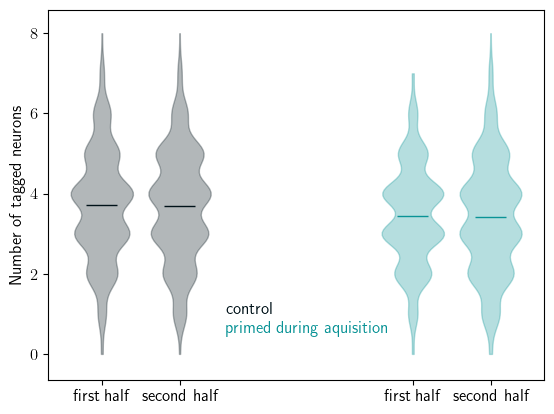

In [368]:
first = first_encod_A
second = second_encod_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,1,'control', color = color[0])
plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_encodA.png',dpi = 500)

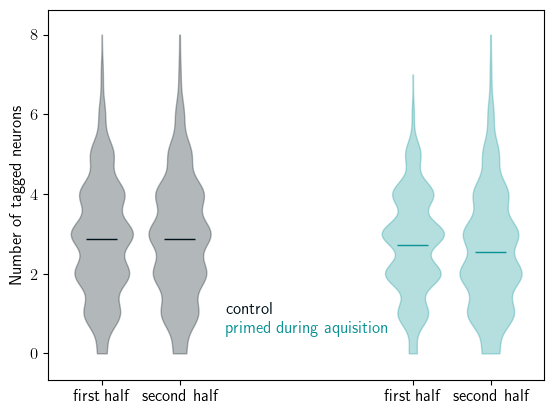

In [369]:
first = first_recall_A
second = second_recall_A

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,1,'control', color = color[0])
plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_recallA.png',dpi = 500)

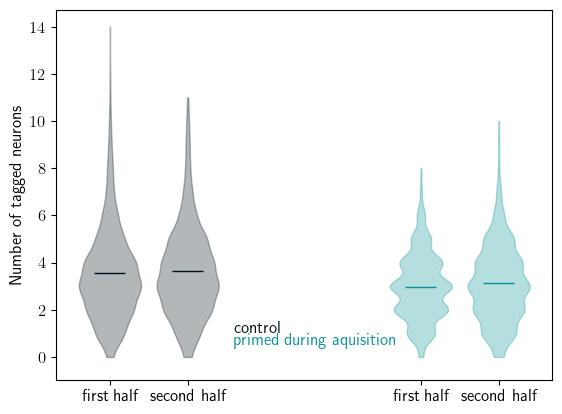

In [370]:
first = first_encod_B
second = second_encod_B

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,1,'control', color = color[0])
plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_encodB.png',dpi = 500)

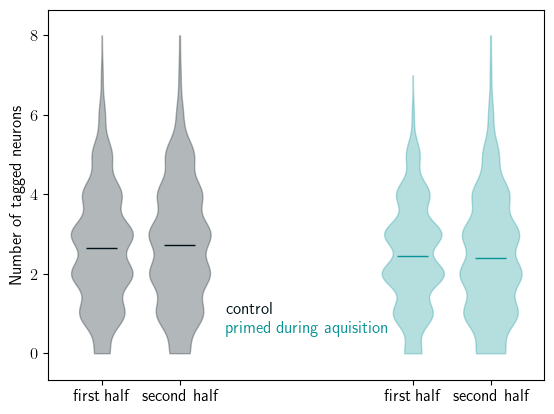

In [371]:
first = first_recall_B
second = second_recall_B

for p in [0,1]:
    X = p + np.array([0,1/4])
    
    parts = plt.violinplot([first[p,:],second[p,:]],X,widths = .2,showmeans=True, showmedians=False, showextrema=False)
    
    for pc in parts['bodies']:
        pc.set_facecolor(color[2*p])
        pc.set_edgecolor(color[2*p])
        #pc.set_alpha(1)

    for partname in ['cmeans']:
        vp = parts[partname]
        vp.set_edgecolor(color[2*p])
        vp.set_linewidth(1)


    for seed in range(Nseed):
        plt.plot(X+random.random()/10-1/20,np.array([first_encod_A[p,seed],
                                  second_encod_A[p,seed]])+random.random()/2-1/4
                                 ,marker = '.', linestyle='None', color = 'k', alpha = 1/Nseed)
plt.xticks([0,.25,1,1.25],['first half','second half','first half','second half']);

plt.ylabel('Number of tagged neurons')

#plt.legend(['E = 0, threshold = 0', 'E = 0, threshold = 2', 'E = 2, threshold = 0', 'E = 2, threshold = 2'])
plt.text(.4,1,'control', color = color[0])
plt.text(.4,.5,'primed during aquisition', color = color[2])
#plt.text(0,1,'E = 2, threshold = 0', color = color[4])
#plt.text(0,1.5,'E = 2, threshold = 2', color = color[6])


plt.savefig('primed_before_recallB.png',dpi = 500)

effect of competition of primed neurons: that's why decrease of size with E\
also, bigger range of size with memory B because of overlap: some neurons are similar to A, others are inversted and total is not 50/50